# ITI distributions

In [46]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import brainbox.behavior.wheel as wh
from brainbox.io.one import SessionLoader

from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import prepro
from design_functions import wheel_velocity

## Load sessions

In [47]:
# Choose a session with good QC
data_path = '/home/ines/repositories/representation_learning_variability/Video and wheel/'
# data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video and wheel/'

os.chdir(data_path)
pass_qc = pickle.load(open(data_path + "good_brainwide_sessions_metadata", "rb"))
pass_qc = pickle.load(open(data_path + "good_dlc_bwm_sessions_metadata", "rb"))


## Loop through sessions

In [48]:
def time_intervals(session_trials):
    
    session_trials = prepro(session_trials)
    session_trials['ITI'] = session_trials['intervals_1'] - session_trials['stimOff_times']
    session_trials['feedback_time'] = session_trials['stimOff_times'] - session_trials['feedback_times']
    session_trials['movement_time'] = session_trials['feedback_times'] - session_trials['firstMovement_times']
    session_trials['failing_quiescence'] = session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod'] - session_trials['intervals_0']
    session_trials['full_ITI'] = session_trials['ITI']*np.NaN
    session_trials['full_ITI'][:-1] = np.array(session_trials['intervals_0'][1:]) - np.array(session_trials['stimOff_times'][:-1])
    session_trials['feedback_ITI'] = session_trials['ITI']*np.NaN
    session_trials['feedback_ITI'][:-1] = np.array(session_trials['intervals_0'][1:]) - np.array(session_trials['feedback_times'][:-1])
    session_trials['prev_feedback'] = session_trials['feedbackType'] * np.nan
    session_trials['prev_feedback'][1:] = session_trials['feedbackType'][:-1]   
    session_trials['long_ITI'] =  session_trials['ITI']*np.NaN
    session_trials['long_ITI'][:-1] =  np.array(session_trials['goCueTrigger_times'][1:]) - np.array(session_trials['feedback_times'][:-1])
    session_trials['elongated_quiesc'] = session_trials['failing_quiescence']
    session_trials.loc[session_trials['elongated_quiesc'] < 0.1, 'elongated_quiesc'] = 0
    session_trials.loc[session_trials['elongated_quiesc'] >= 0.1, 'elongated_quiesc'] = 1
    
    return session_trials


# From chatGPT
def find_periods_below_threshold(velocity, threshold, min_period):
    below_threshold = np.abs(velocity) < threshold
    start_idx = np.flatnonzero(np.diff(below_threshold, prepend=0, append=0) == 1)
    end_idx = np.flatnonzero(np.diff(below_threshold, prepend=0, append=0) == -1)
    durations = end_idx - start_idx
    periods = np.stack((start_idx, end_idx), axis=1)[durations >= min_period]
    return periods

# From chatGPT
def create_movement_array(velocity, periods_below_threshold):
    movement_array = np.ones_like(velocity)
    for start, end in periods_below_threshold:
        movement_array[start:end] = 0
    return movement_array


def stack_trial_events(session_trials, trials_to_plot, session_eid, time_max):

    # PLOT
    fig, axs = plt.subplots(nrows=trials_to_plot, ncols=1, sharex=True, sharey=False, figsize=[18, 14])
    plt.rc('font', size=12)
    y = [-10, 10]
    bin_size = 0.05
    time_min = -0.1
    threshold = 0.25 # Need to check if this makes sense
    min_period = 200 # This is approximately 200 ms

    use_data = session_trials.reset_index()
    for t, trial in enumerate(range(trials_to_plot)):

        trial_start = use_data.loc[use_data['index']==t, 'intervals_0']
        next_trial = use_data.loc[use_data['index']==t+1]
        trial_data = use_data.loc[use_data['index']==t]
        trial_feedback = trial_data['feedbackType']

        axs[t].vlines(np.array(trial_data['stimOn_times']) - trial_start,
                        -10, 10, label='Stim On', color='Black')
        if list(trial_feedback)[0] == 1:
            axs[t].vlines(np.array(trial_data['feedback_times']) - trial_start,
                        -10, 10, label='Correct', color='Green', linewidth=2)
            axs[t].fill_betweenx(y, list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], 
                          list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='green', alpha=0.3)
            axs[t].fill_betweenx(y, list(trial_data['feedback_times'])[0]-list(trial_start)[0], 
                          list(trial_data['stimOff_times'])[0]-list(trial_start)[0], color='green', alpha=0.6)
        else:
            axs[t].vlines(np.array(trial_data['feedback_times']) - trial_start,
                        -10, 10, label='Incorrect', color='Red', linewidth=2)
            axs[t].fill_betweenx(y, list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], 
                          list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='red', alpha=0.3)
            axs[t].fill_betweenx(y, list(trial_data['feedback_times'])[0]-list(trial_start)[0], 
                          list(trial_data['stimOff_times'])[0]-list(trial_start)[0], color='red', alpha=0.6)
            
        axs[t].vlines(np.array(trial_data['firstMovement_times']) - trial_start, -10, 10, 
                        label='First movement', color='Blue')
        axs[t].vlines(np.array((trial_data['goCueTrigger_times'] - trial_data['quiescencePeriod'])) - trial_start,
                        -10, 10, label='Quiescence start', color='Purple')
        axs[t].vlines(np.array(trial_data['stimOff_times']) - trial_start,
                        -10, 10, label='Stim Off', color='Brown')
        axs[t].vlines(np.array(trial_data['intervals_1']) - trial_start,
                        -10, 10, label='Trial end', color='Orange')
        axs[t].vlines(np.array(next_trial['intervals_0']) - trial_start,
                        -10, 10, label='Next trial start', color='Grey')  
        axs[t].vlines(np.array((next_trial['goCueTrigger_times'] - next_trial['quiescencePeriod'])) - trial_start,
                        -10, 10, label='Quiescence start', color='Purple')

        axs[t].fill_betweenx(y, 0, list(trial_data['goCueTrigger_times'] - 
                          trial_data['quiescencePeriod'])[0]-list(trial_start)[0], color='purple', alpha=0.6)
        axs[t].fill_betweenx(y, list(trial_data['goCueTrigger_times'] - 
                          trial_data['quiescencePeriod'])[0]-list(trial_start)[0], 
                          list(trial_data['stimOn_times'])[0]-list(trial_start)[0], color='purple', alpha=0.3)
        axs[t].fill_betweenx(y, list(trial_data['stimOn_times'])[0]-list(trial_start)[0],
                             list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], color='blue', alpha=0.3)
        axs[t].fill_betweenx(y, list(trial_data['stimOff_times'])[0]-list(trial_start)[0],
                             list(trial_data['intervals_1'])[0]-list(trial_start)[0], color='orange', alpha=0.3)
        axs[t].fill_betweenx(y, list(next_trial['intervals_0'])[0] - list(trial_start)[0], 
                             list(next_trial['goCueTrigger_times'] - 
                          next_trial['quiescencePeriod'])[0]-list(trial_start)[0], color='purple', alpha=0.6)
        
        # Wheel
        wheel_data = one.load_object(session_eid, 'wheel', collection='alf')
        pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
        # Calculate wheel velocity
        wheel_vel = wheel_velocity(bin_size, wheel_times, pos, use_data)
        wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

        xx = wheel_times - list(trial_start)[0]
        yy = wheel_trace

        trial_time_max = list(np.array(next_trial['goCueTrigger_times'] - 
                                        next_trial['quiescencePeriod']) - trial_start)[0]
        mask = np.where((xx <trial_time_max) & (xx> time_min))
        wheel_max = np.max(wheel_trace[mask])
        wheel_min = np.min(wheel_trace[mask])

        # Plot wheel
        axs[t].plot(xx[mask], yy[mask], color='Black')

        # Compute stillness
        periods_below_threshold = find_periods_below_threshold(wheel_trace, threshold, min_period)
        stillness_array = create_movement_array(wheel_trace, periods_below_threshold)
        movement_array = stillness_array.copy()
        movement_array[movement_array >0] = np.nan 
        stillness_array[stillness_array==0] = np.nan 
        stillness_array[stillness_array==1] = 0

        # Plot movement and stilness
        axs[t].plot(xx[mask], stillness_array[mask], color='Orange')
        axs[t].plot(xx[mask], movement_array[mask], color='Blue')
        
        axs[t].set_ylim([wheel_min, wheel_max])
        axs[t].set_yticks([] ,[])
    axs[t].set_xlabel(str('Time from trial start (s)'))
    axs[t].set_xlim([time_min, time_max])
    axs[t].legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.show()


def wheel_trial_epoch(session_trials, session_eid, bin_size):

    threshold = 0.25 # Need to check if this makes sense
    min_period = 200 # This is approximately 200 ms
    
    use_data = prepro(session_trials.reset_index())

    df = pd.DataFrame(columns=['trial', 'time', 'wheel', 'movement', 'trial_epoch', 'feedback', 'prev_feedback', 'signed_contrast'])

    # Wheel
    wheel_data = one.load_object(session_eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    # Calculate wheel velocity
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, use_data)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    # Session loader does not seem to be faster
    # sess_loader = SessionLoader(one, session_eid)
    # # get wheel speed
    # sess_loader.load_wheel()
    # wheel = sess_loader.wheel
    # wheel_trace = wheel['velocity']
    # wheel_times = wheel['times']
    
    # Compute stillness
    periods_below_threshold = find_periods_below_threshold(wheel_trace, threshold, min_period)
    movement_array = create_movement_array(wheel_trace, periods_below_threshold)

    # Save data on dataframe
    df['time'] = wheel_times
    df['wheel'] = wheel_trace
    df['movement'] = movement_array
        
    for t, trial in enumerate(range(len(use_data)-1)):

        
        trial_data = use_data.loc[use_data['index']==t]
        next_trial = use_data.loc[use_data['index']==t+1]
            
        # Compute timings
        trial_start = list(trial_data['intervals_0'])[0]
        quiescence_start = list(trial_data['goCueTrigger_times'] - trial_data['quiescencePeriod'])[0]
        stim_on = list(trial_data['stimOn_times'])[0]
        first_movement = list(trial_data['firstMovement_times'])[0]
        response_time = list(trial_data['response_times'])[0]
        stim_off = list(trial_data['stimOff_times'])[0]
        trial_end = list(trial_data['intervals_1'])[0]
        next_trial_start = list(next_trial['intervals_0'])[0]

        # Compute intervals
        df.loc[(df['time'] >= trial_start) & (df['time'] < quiescence_start), 'trial_epoch'] = 'trial_start'
        df.loc[(df['time'] >= quiescence_start) & (df['time'] < stim_on), 'trial_epoch'] = 'quiescence'
        df.loc[(df['time'] >= stim_on) & (df['time'] < first_movement), 'trial_epoch'] = 'stim_on'
        df.loc[(df['time'] >= first_movement) & (df['time'] < response_time), 'trial_epoch'] = 'movement'
        # df.loc[(df['time'] >= response_time) & (df['time'] < stim_off), 'trial_epoch'] = 'feedback'
        # df.loc[(df['time'] >= response_time) & (df['time'] < (response_time+2)), 'trial_epoch'] = 'short_feedback'
        df.loc[(df['time'] >= response_time) & (df['time'] < next_trial_start), 'trial_epoch'] = 'post_choice'
        # df.loc[(df['time'] >= stim_off) & (df['time'] < trial_end), 'trial_epoch'] = 'iti'
        # df.loc[(df['time'] >= trial_end) & (df['time'] < next_trial_start), 'trial_epoch'] = 'iti+'
        
        df.loc[(df['time'] >= trial_start) & (df['time'] < next_trial_start), 'feedback'] = list(trial_data['feedbackType'])[0]
        df.loc[(df['time'] >= trial_start) & (df['time'] < next_trial_start), 'prev_feedback'] = list(next_trial['feedbackType'])[0]
        df.loc[(df['time'] >= trial_start) & (df['time'] < next_trial_start), 'signed_contrast'] =  list(trial_data['signed_contrast'])[0]
        df.loc[(df['time'] >= trial_start) & (df['time'] < next_trial_start), 'trial'] =  trial
        
    return df


def process_quiescence(df):
    
    # Process data
    new = df[['trial', 'trial_epoch', 'feedback', 'prev_feedback', 'signed_contrast', 'movement']]

    # Identify consecutive duplicates
    consecutive_duplicates_mask = new.eq(new.shift())

    # Filter DataFrame to remove consecutive duplicates
    df_no_consecutive_duplicates = new[~consecutive_duplicates_mask.all(axis=1)].reset_index()

    time_df = df[['time']].reset_index()
    merged_df = df_no_consecutive_duplicates.merge(time_df, on='index')
    merged_df = merged_df.rename(columns={'time': 'movement_onset'})

    # Get trial onset
    epoch_onset = pd.DataFrame(merged_df.groupby(['trial', 'trial_epoch'])['movement_onset'].min())
    epoch_onset = epoch_onset.reset_index(level=[0, 1])
    epoch_onset = epoch_onset.rename(columns={'movement_onset': 'epoch_onset'})

    new_df = merged_df.merge(epoch_onset)
    new_df['movement_duration'] = new_df['movement_onset'] * np.NaN
    new_df['movement_duration'][1:] = np.diff(new_df['movement_onset'])
        
        
    actual_quiescence = pd.DataFrame(columns=['trial', 'quiesc_length', 'time_to_quiesc', 
                                            'pre_quiesc_move_duration', 'pre_quiesc_move_count'], 
                                    index=new_df['trial'].unique())

    for t, trial in enumerate(new_df['trial'].unique()[:-1]):
        
        trial_data = new_df.loc[new_df['trial']==t]
        next_trial = new_df.loc[new_df['trial']==t+1]
        
        # Some timepoints
        # next_onset = list(next_trial.loc[next_trial['trial_epoch']=='trial_start', 'epoch_onset'])[0]
        next_quiescence = list(next_trial.loc[next_trial['trial_epoch']=='quiescence', 'epoch_onset'])[0]
        
        post_choice_stillness = trial_data.loc[(trial_data['trial_epoch']=='post_choice') & 
                                                (trial_data['movement']==0), 'movement_onset']
        next_trial_init_stillness = next_trial.loc[(next_trial['trial_epoch']=='trial_start') & 
                                                (next_trial['movement']==0), 'movement_onset']
        
        if len(next_trial_init_stillness) > 0:
            last_stillness_onset = list(next_trial_init_stillness)[-1]
        else:
            last_stillness_onset = list(post_choice_stillness)[-1]
            
        response_time = list(trial_data.loc[trial_data['trial_epoch']=='post_choice', 'epoch_onset'])[0]
        # trial_data['movement_duration'] = trial_data['movement_onset'] * np.NaN
        # trial_data['movement_duration'][1:] = np.diff(trial_data['movement_onset'])
        
        # Save data
        actual_quiescence['trial'][t] = trial
        actual_quiescence['quiesc_length'][t] = next_quiescence - last_stillness_onset
        actual_quiescence['time_to_quiesc'][t] = last_stillness_onset - response_time
        actual_quiescence['pre_quiesc_move_duration'][t] = np.sum(trial_data.loc[(trial_data['trial_epoch']=='post_choice') & 
                                                                        (trial_data['movement']==1), 'movement_duration']) + np.sum(next_trial.loc[(next_trial['trial_epoch']=='trial_start') & 
                                                                        (next_trial['movement']==1), 'movement_duration']) 
        
        actual_quiescence['pre_quiesc_move_count'][t] = len(trial_data.loc[(trial_data['trial_epoch']=='post_choice') & 
                                                                        (trial_data['movement']==1)]) + len(next_trial.loc[(next_trial['trial_epoch']=='trial_start') & 
                                                                        (trial_data['movement']==1)])

    processed_df = new_df.merge(actual_quiescence)
    
    return processed_df

### Correlations

In [138]:
hue = 'prev_feedback'
# hue='feedbackType'
vars_to_plot = ['failing_quiescence', 'response_time']
for s, session in enumerate(pass_qc['session_uuid']):
    
    # Get trials
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    
    use_trials = time_intervals(session_trials)
    use_trials = use_trials.loc[use_trials['elongated_quiesc']==1]

    # Plot distributions
    correct_data = use_trials.loc[use_trials[hue]==1]
    incorrect_data = use_trials.loc[use_trials[hue]==-1]
    plt.scatter(correct_data[vars_to_plot[0]], correct_data[vars_to_plot[1]], color='green', alpha=0.5)
    plt.scatter(incorrect_data[vars_to_plot[0]], incorrect_data[vars_to_plot[1]], color='red', alpha=0.5)
    plt.xlabel(vars_to_plot[0])
    plt.ylabel(vars_to_plot[1])
    plt.show()


KeyError: 'response_time'

### Barplots

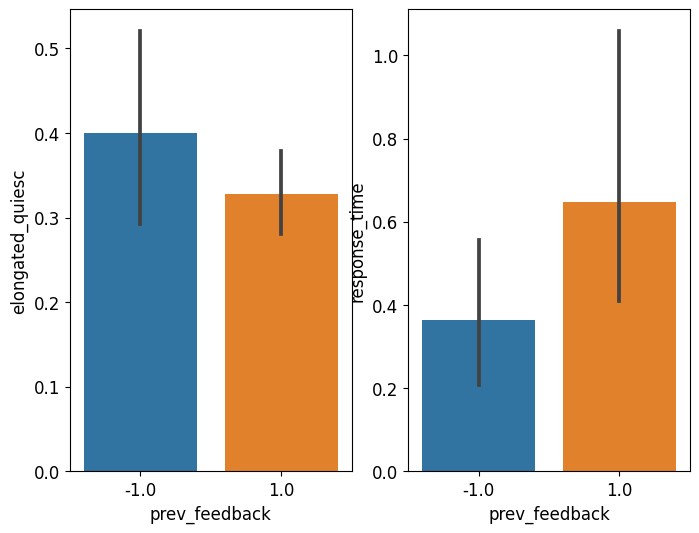

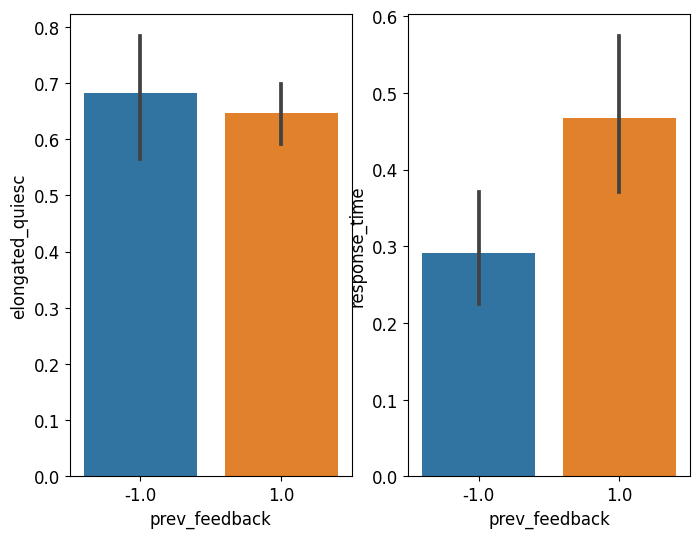

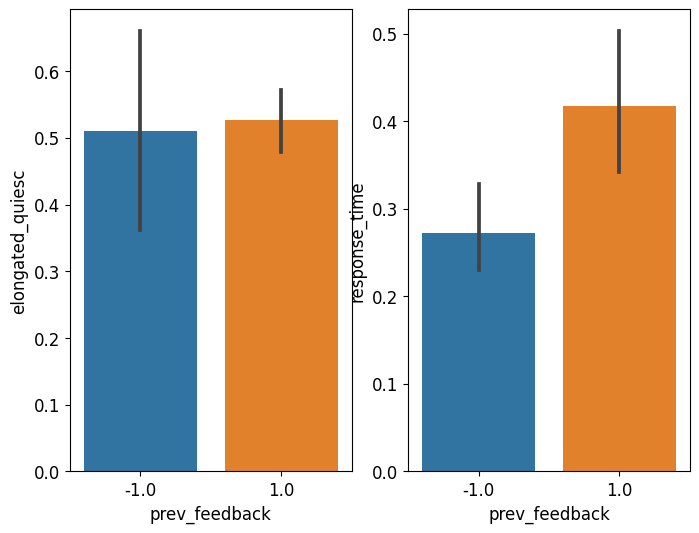

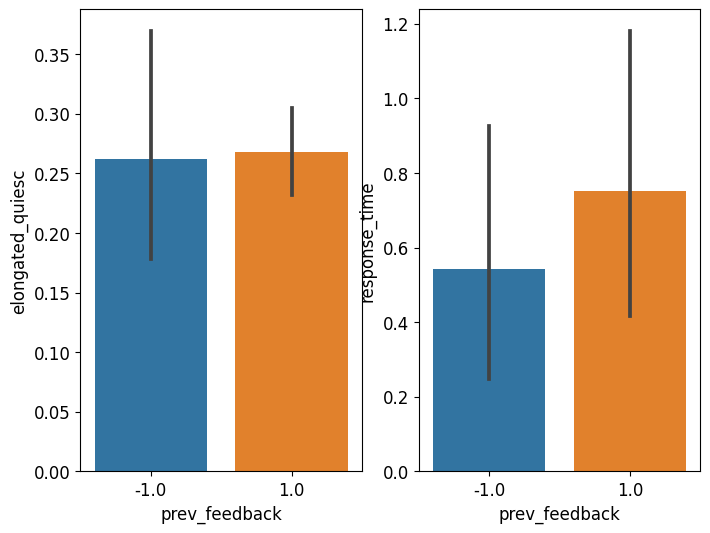

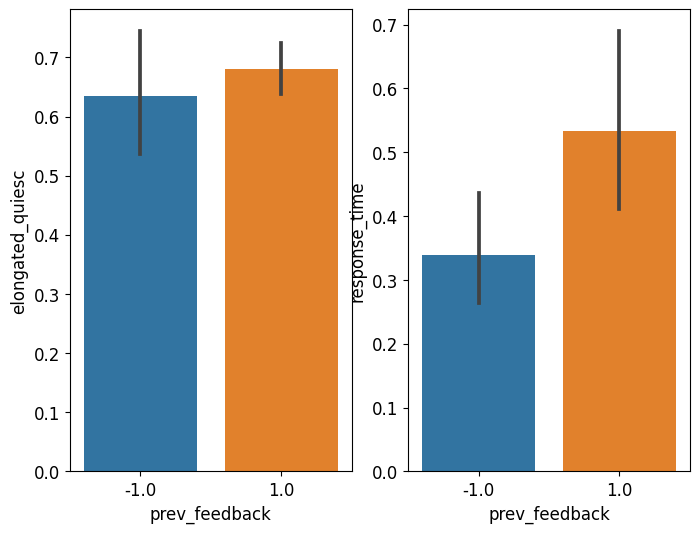

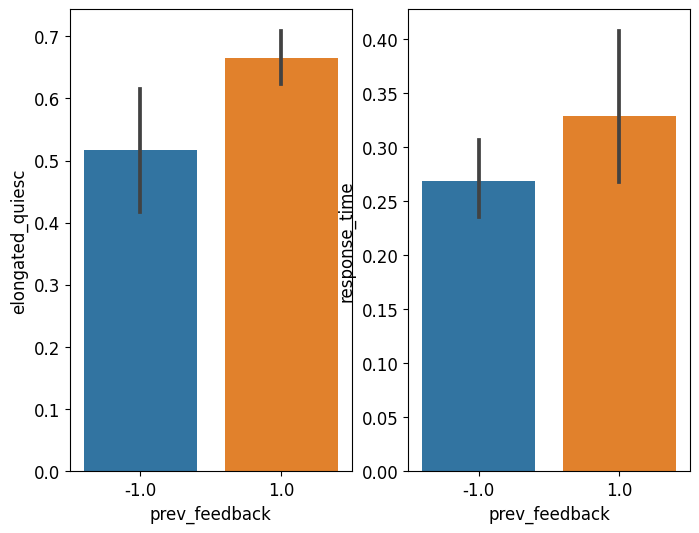

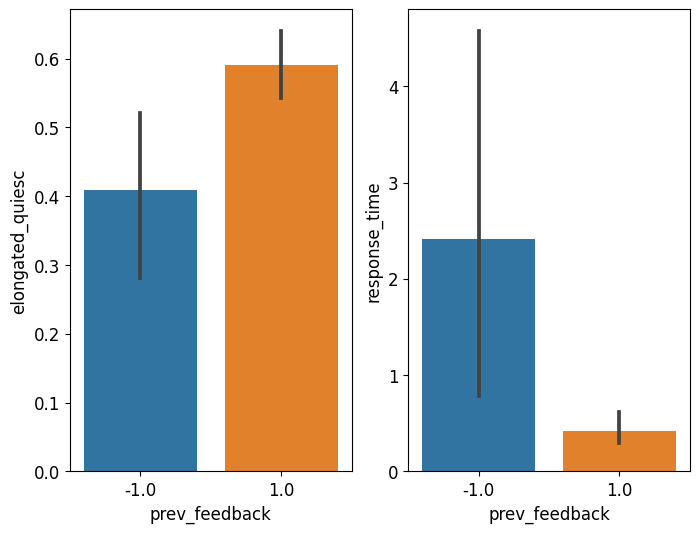

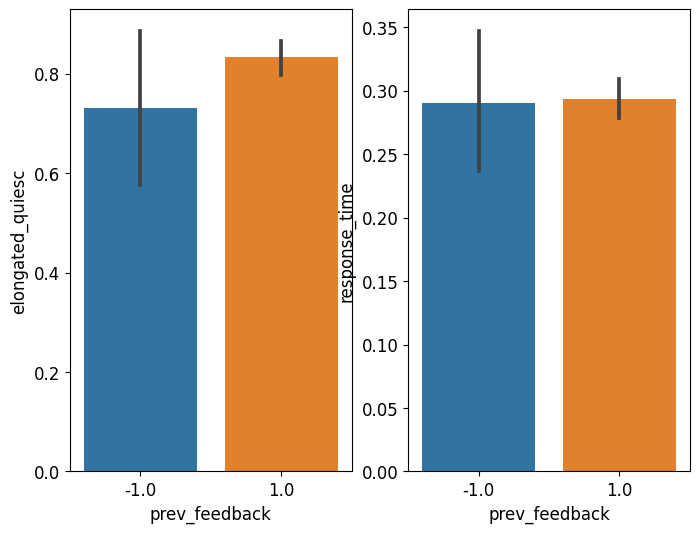

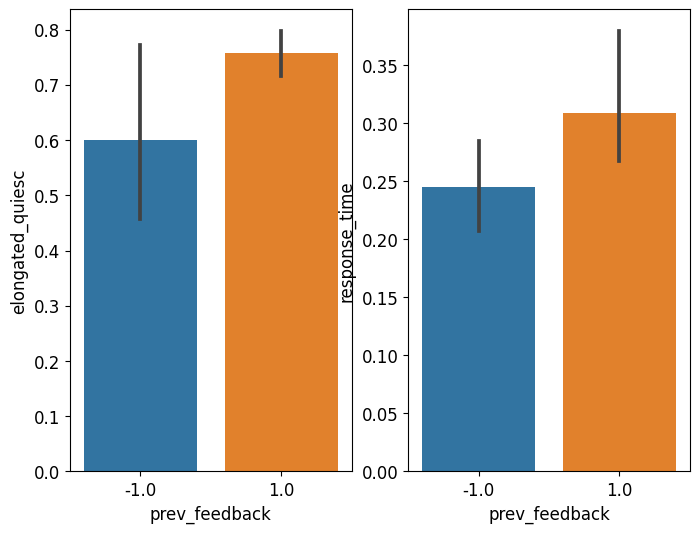

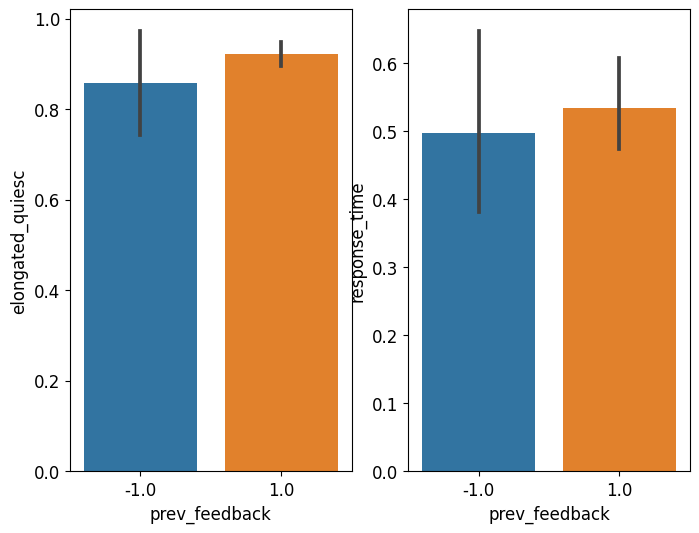

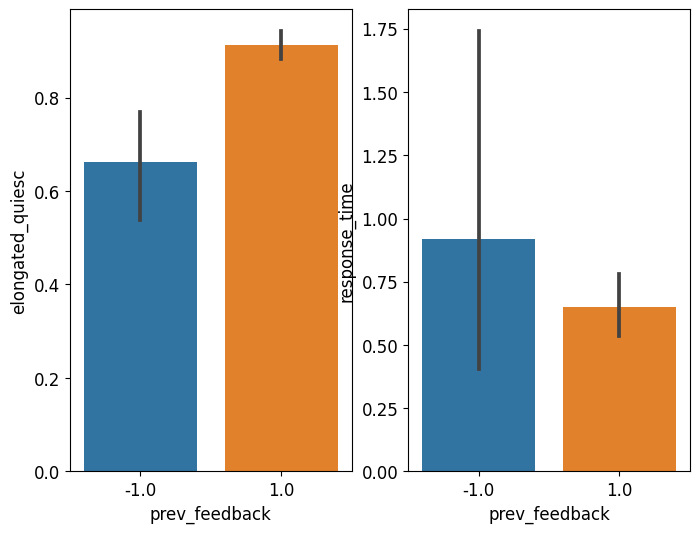

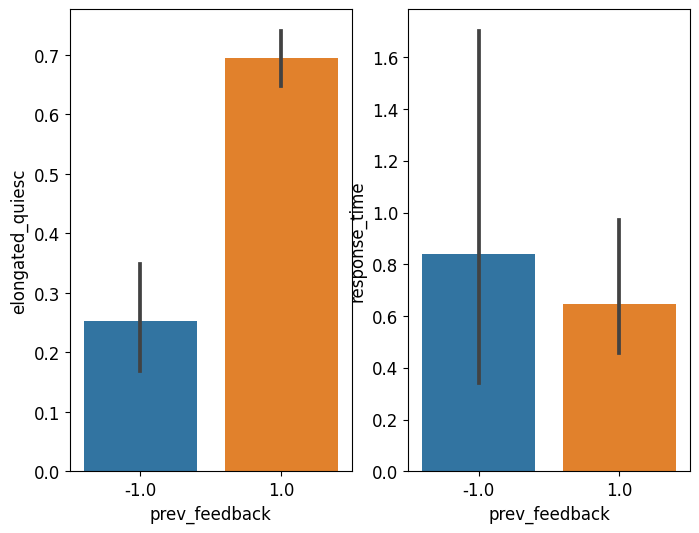

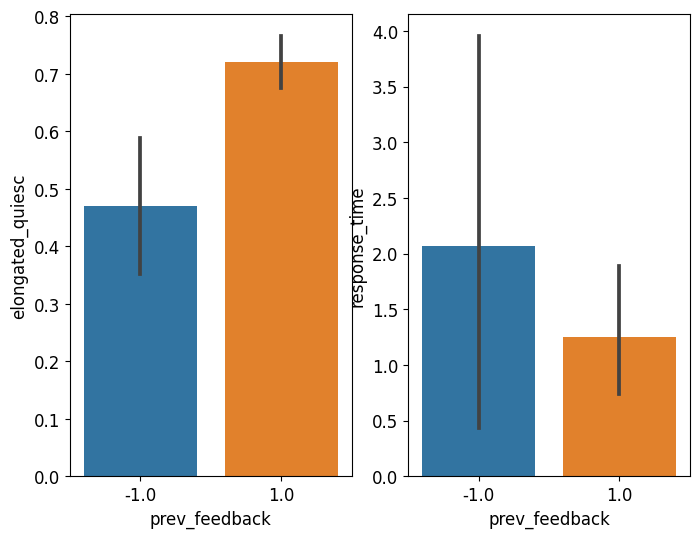

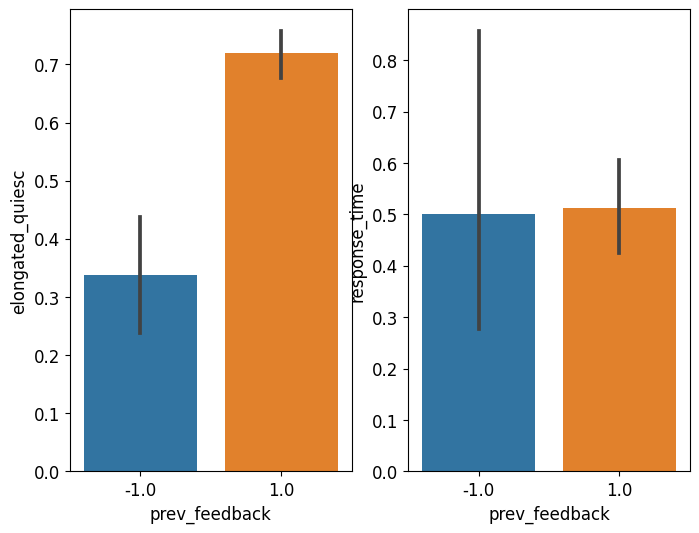

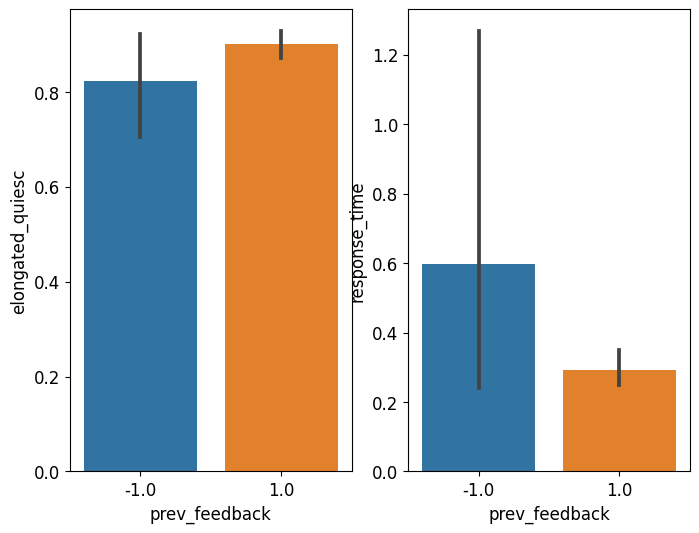

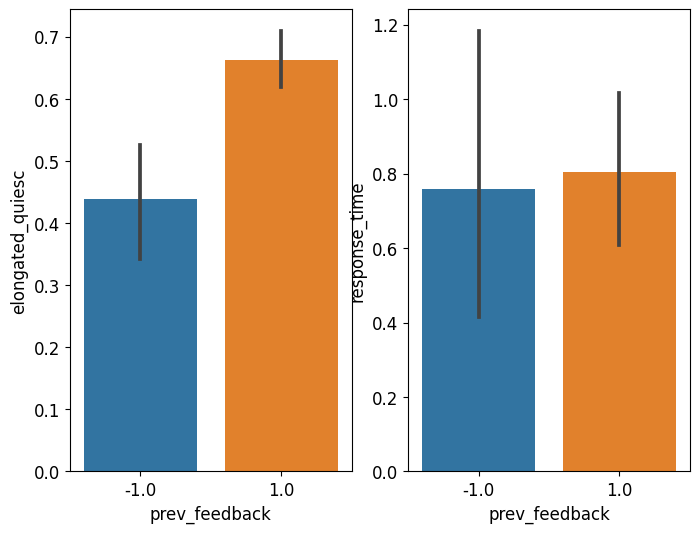

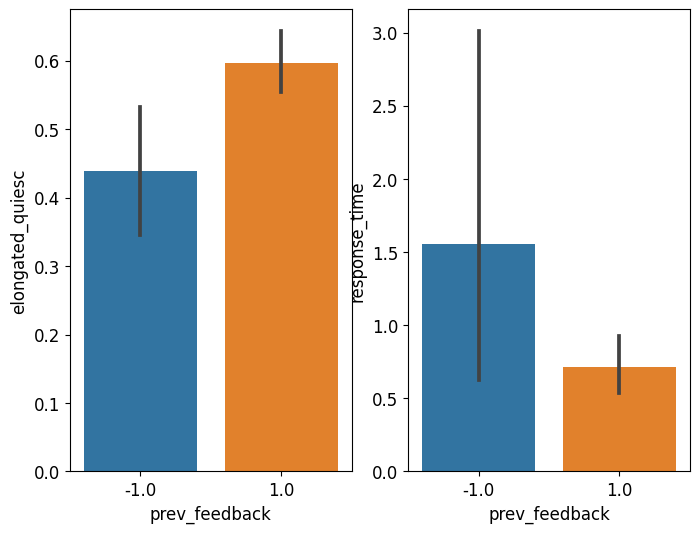

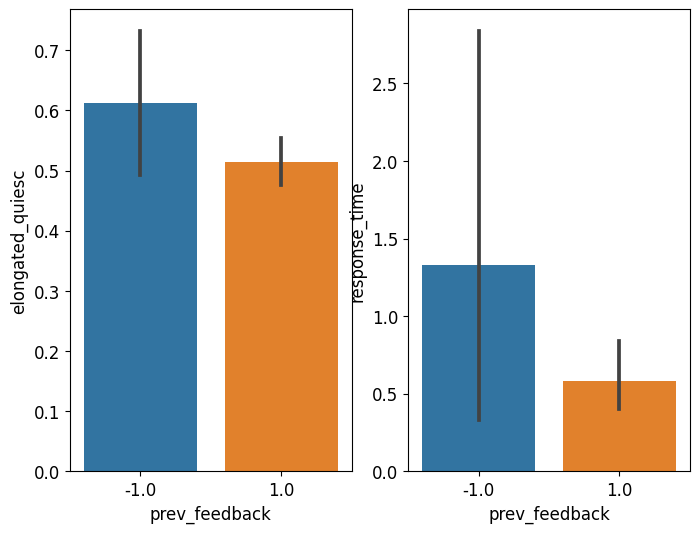

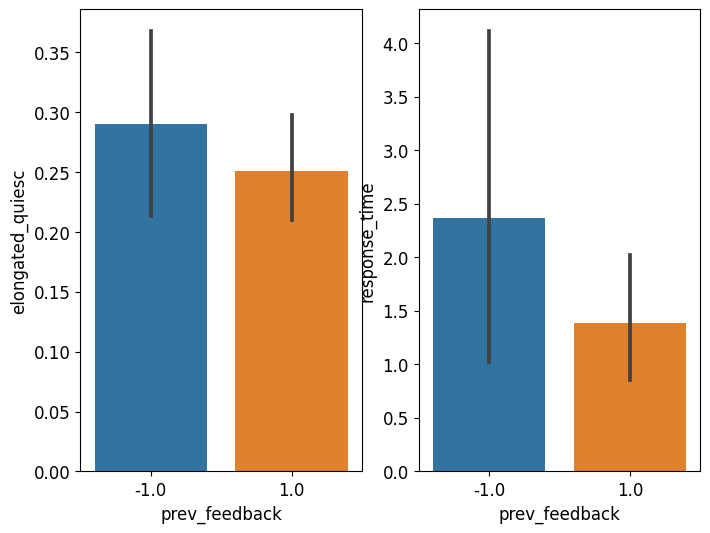

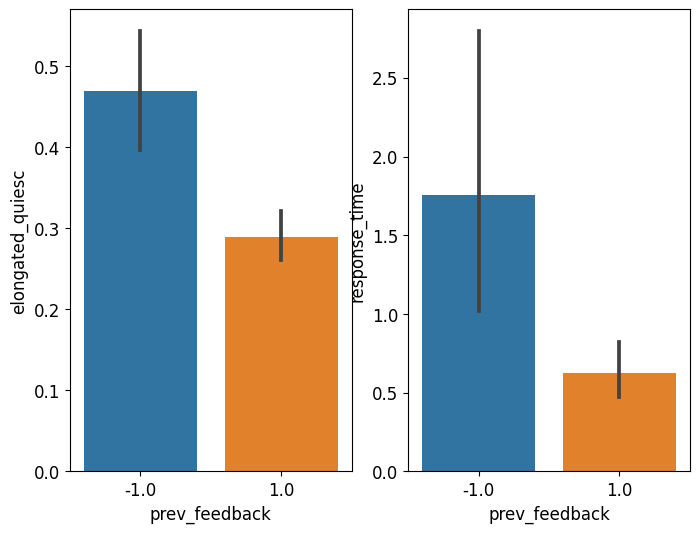

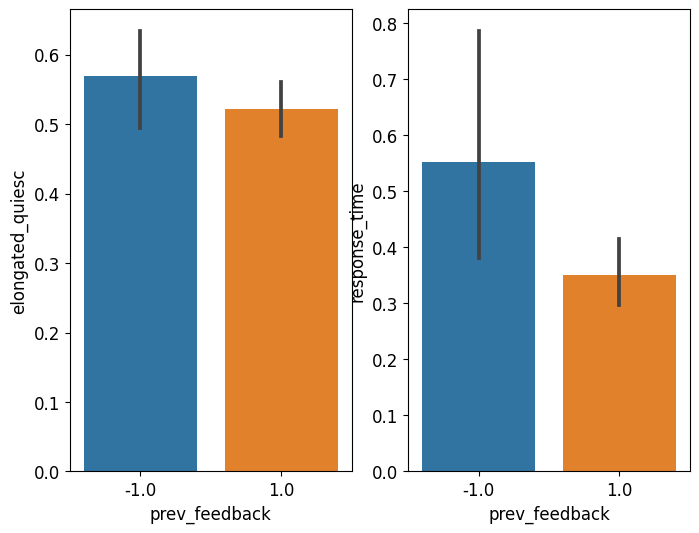

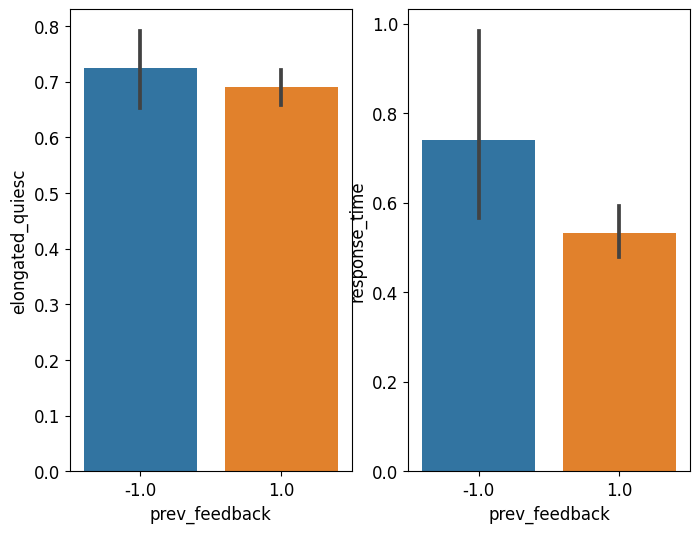

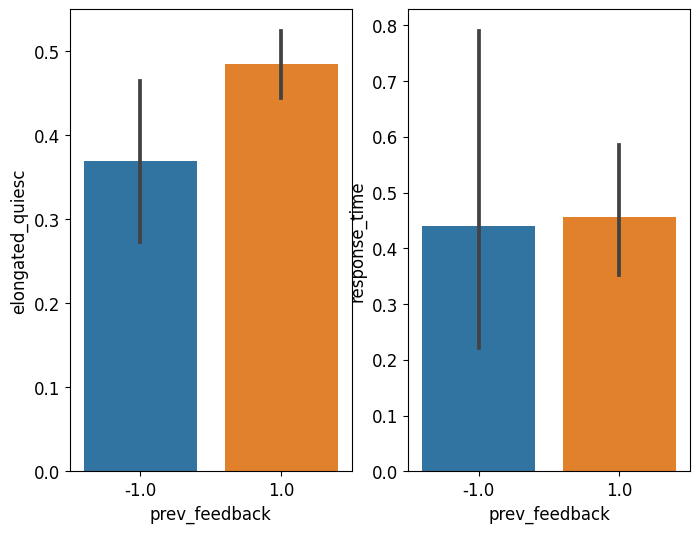

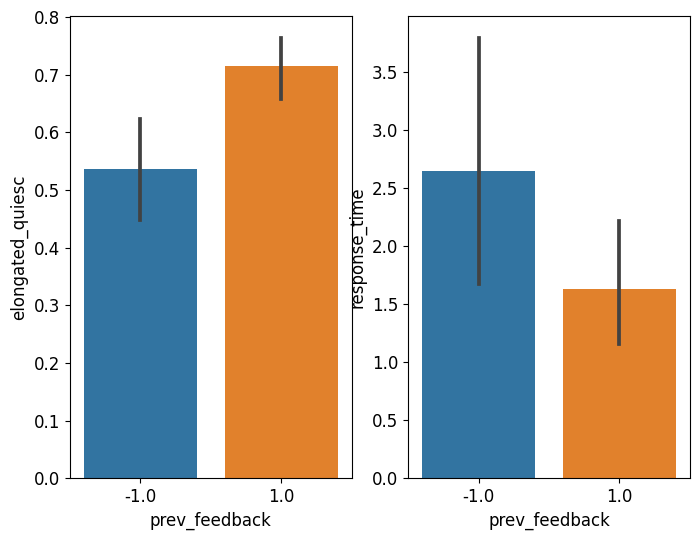

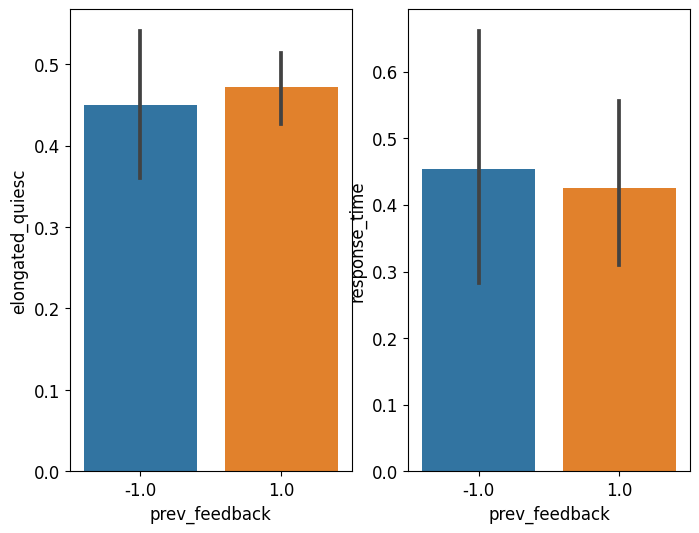

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 16.8kB/s]


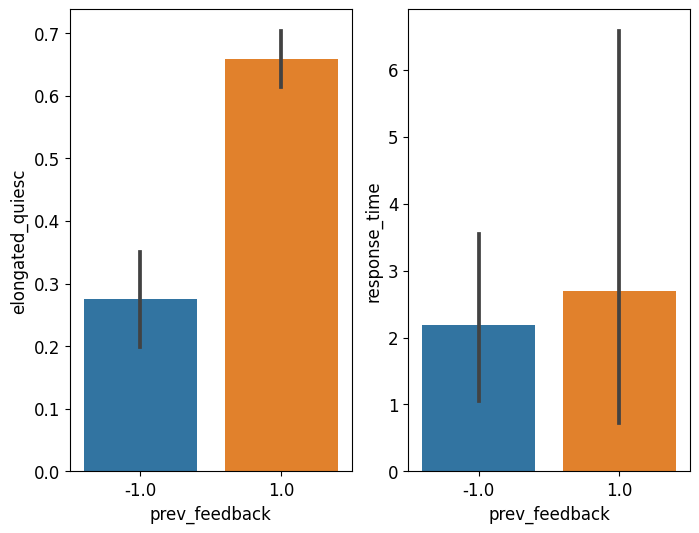

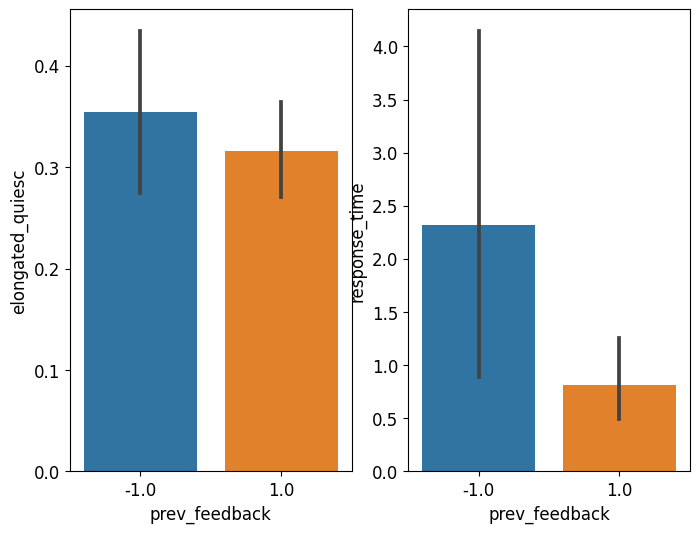

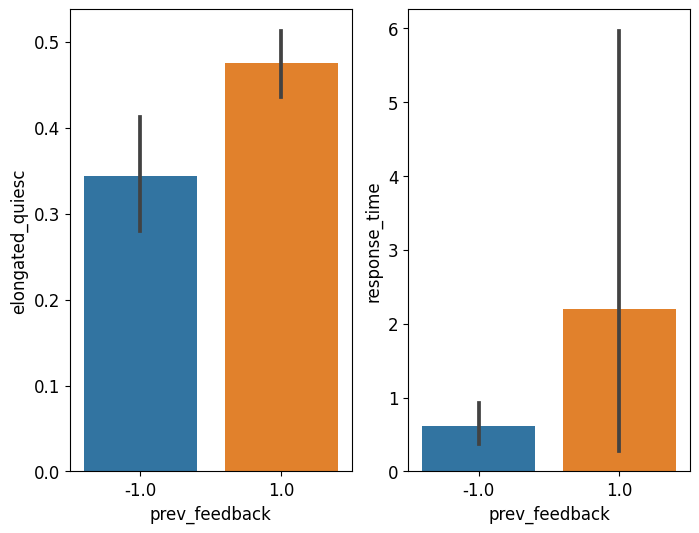

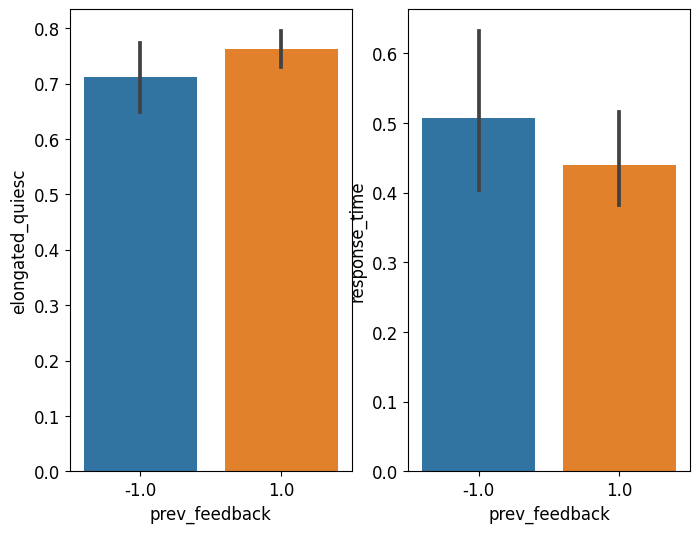

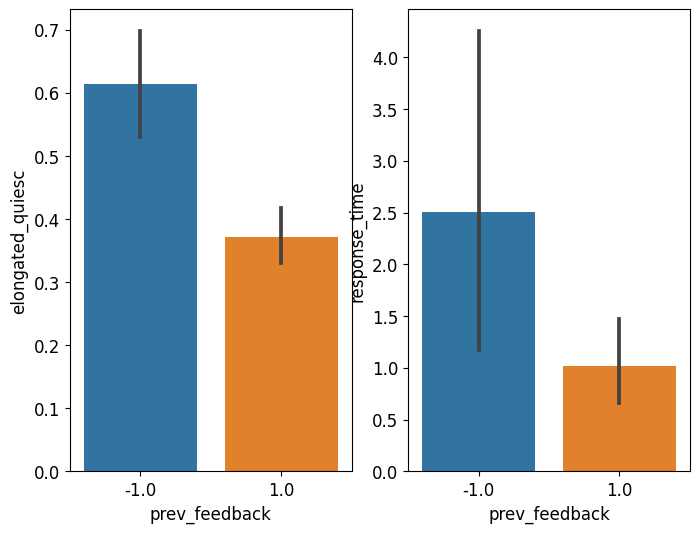

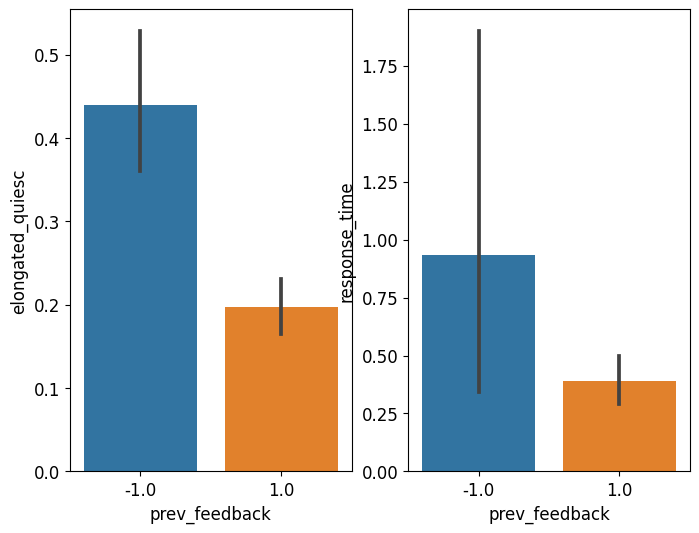

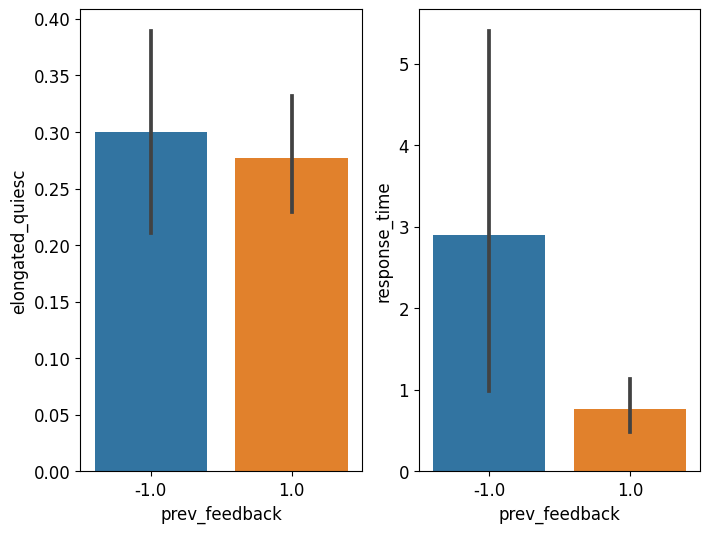

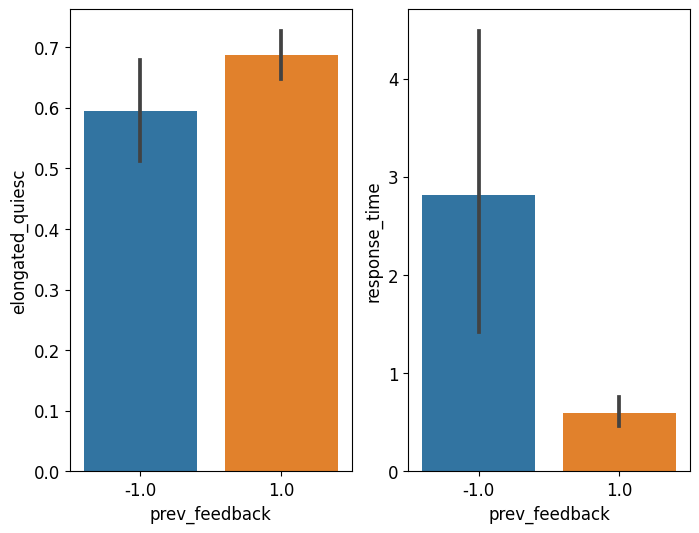

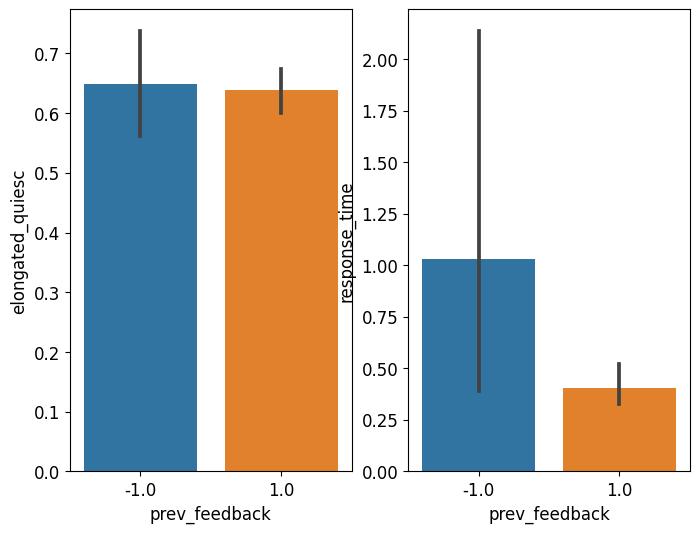

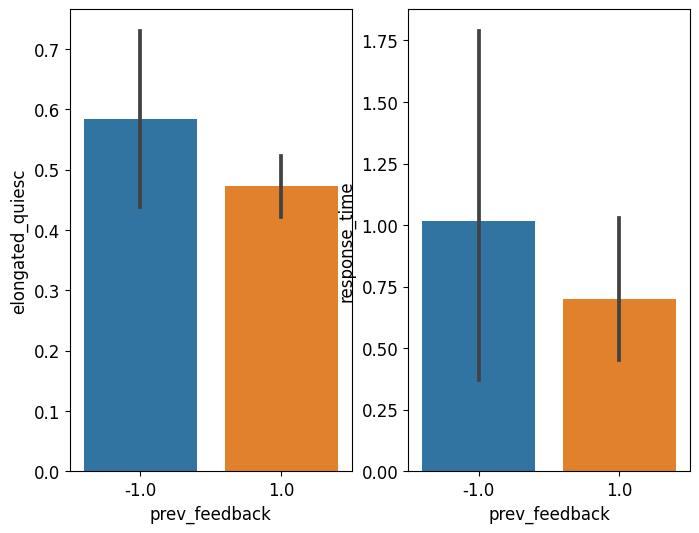

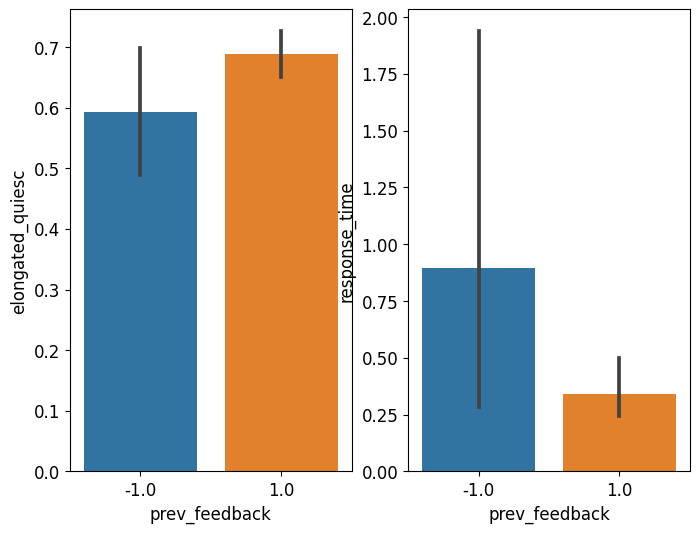

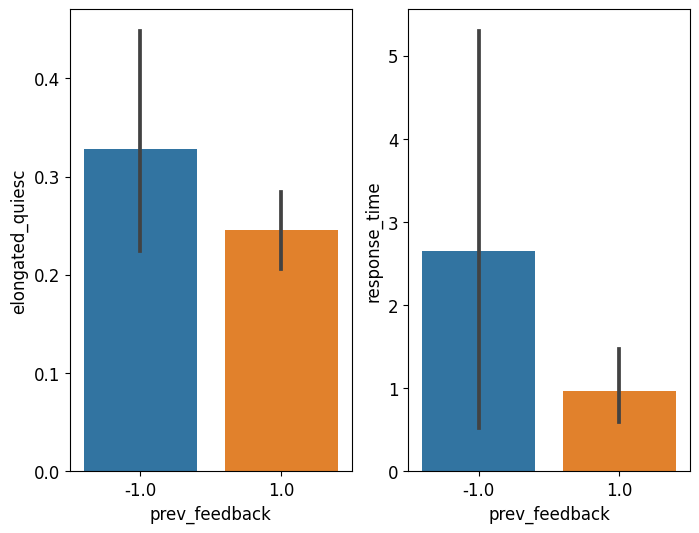

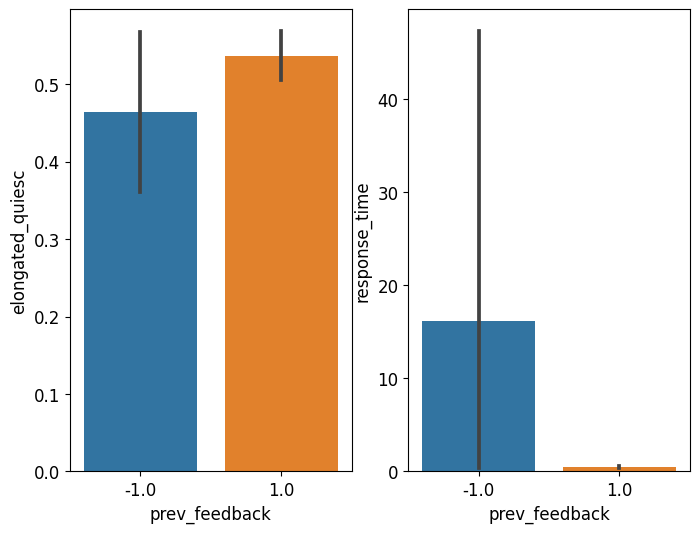

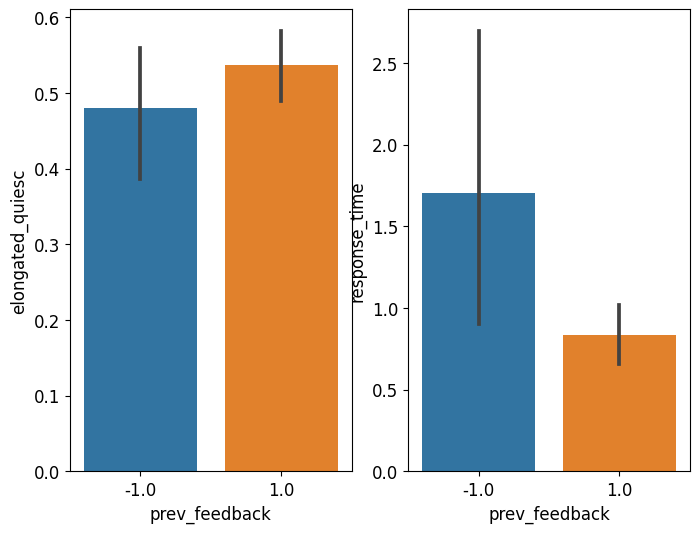

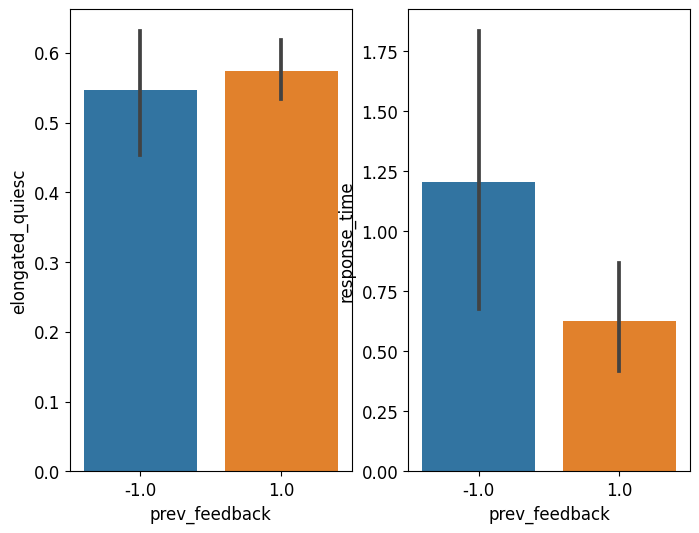

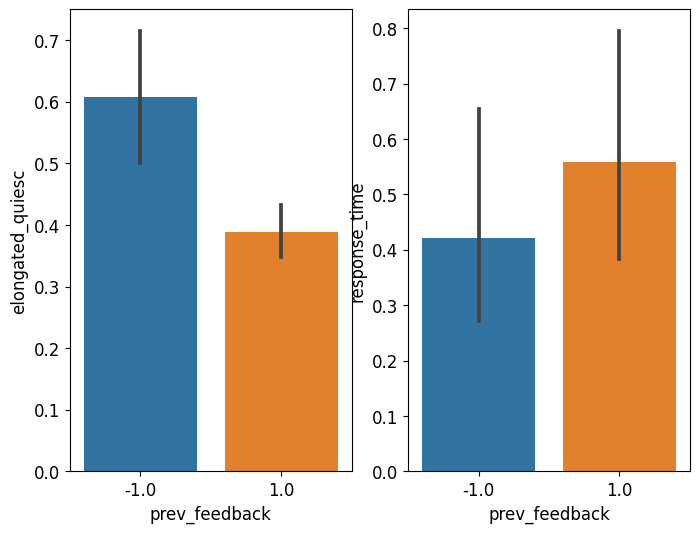

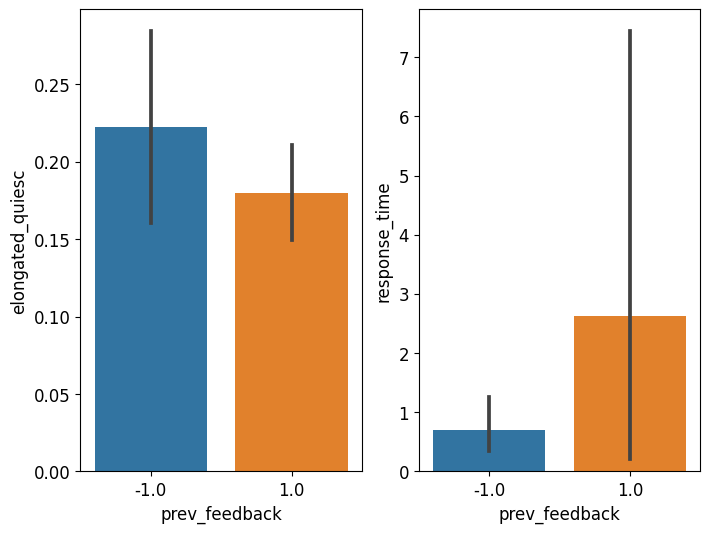

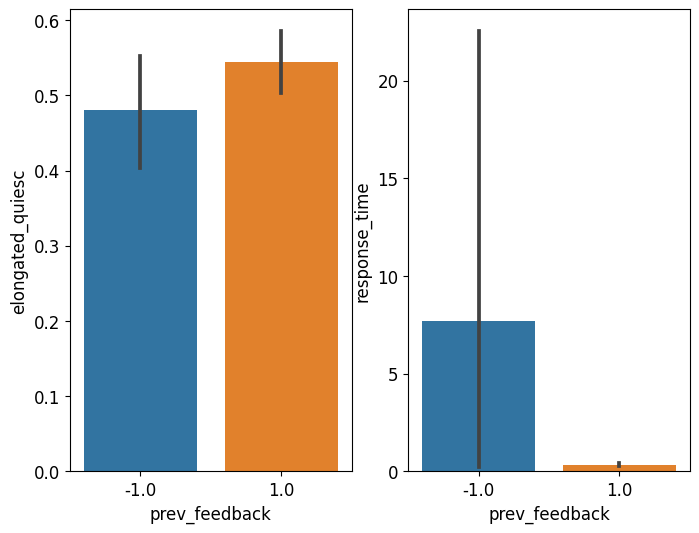

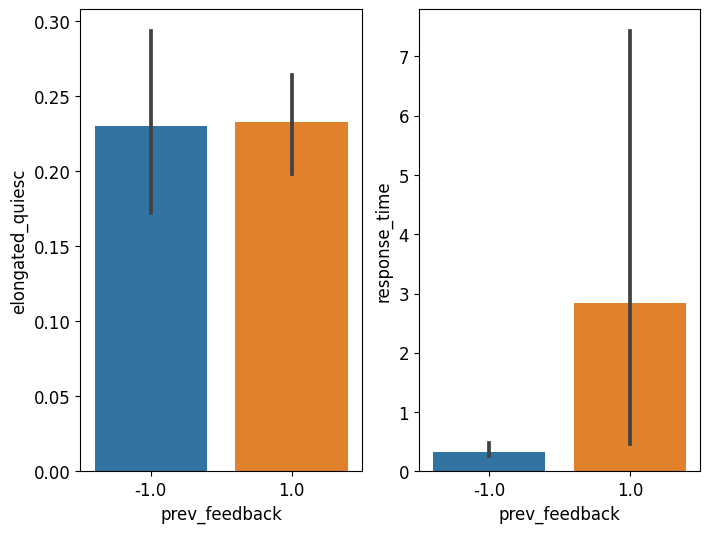

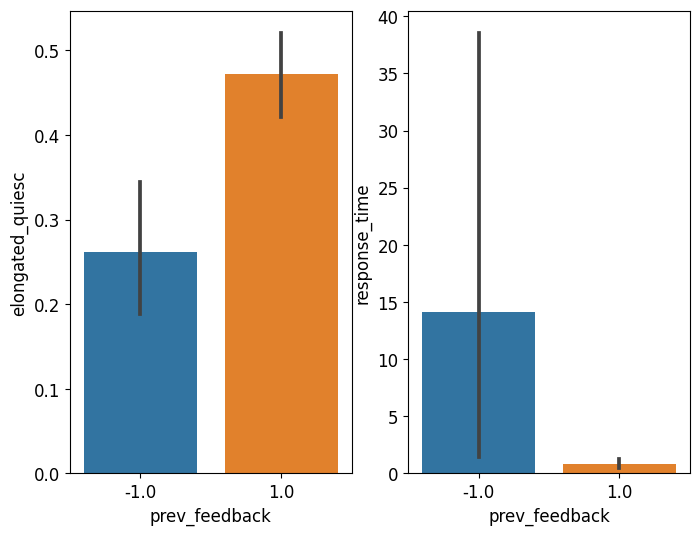

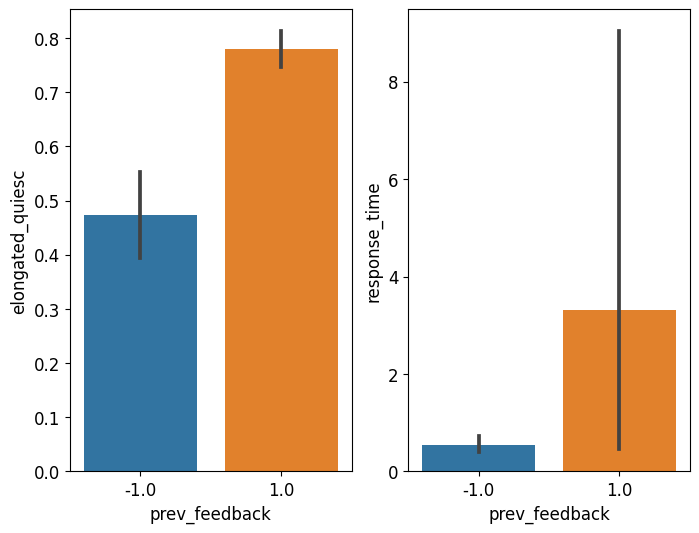

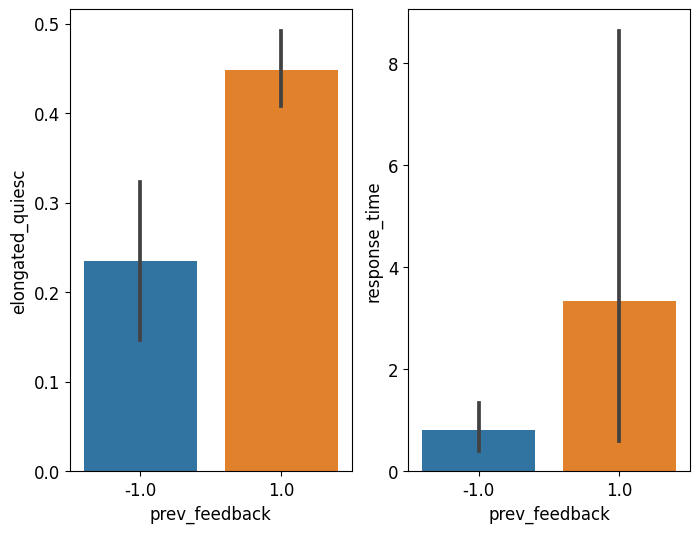

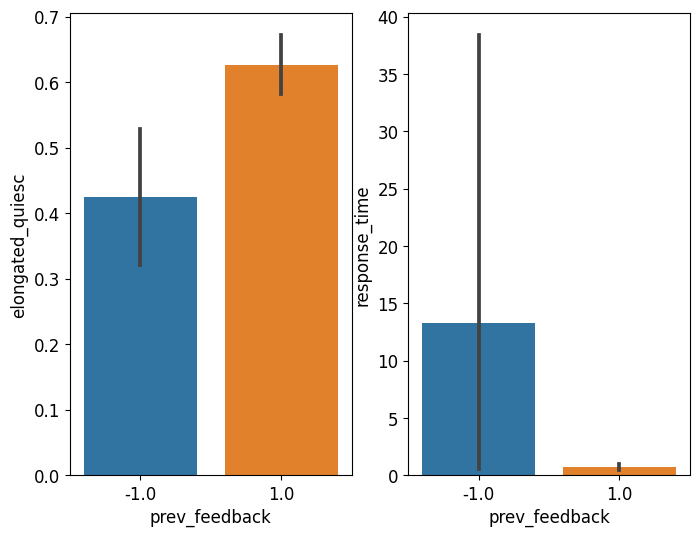

local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 15.4kB/s]


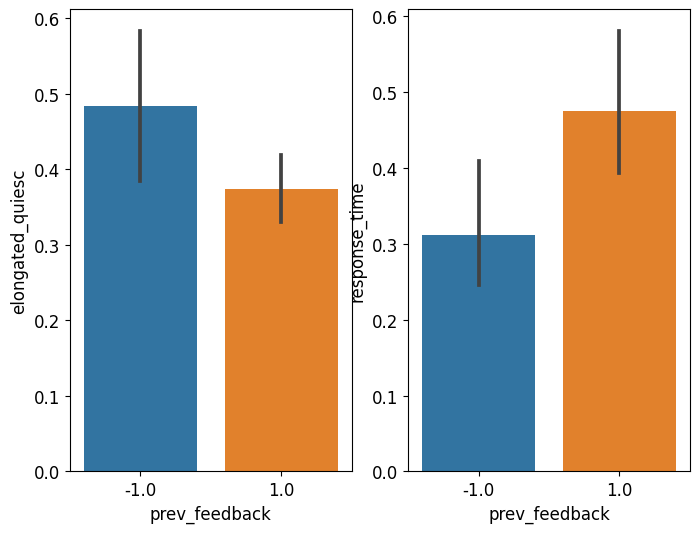

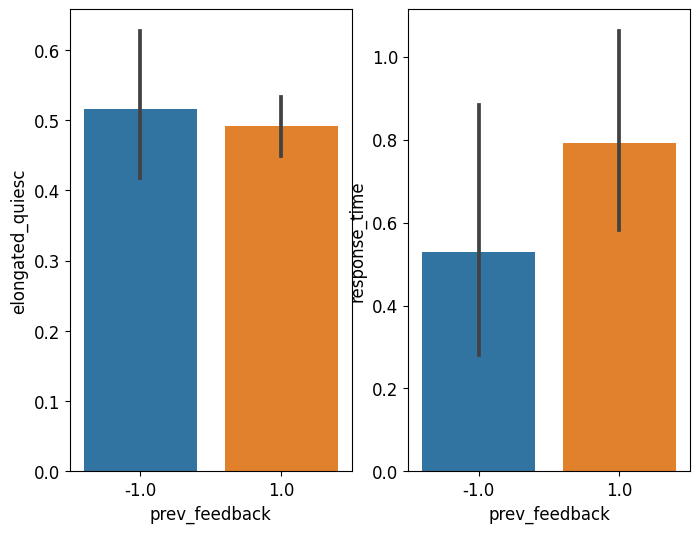

local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 19.1kB/s]


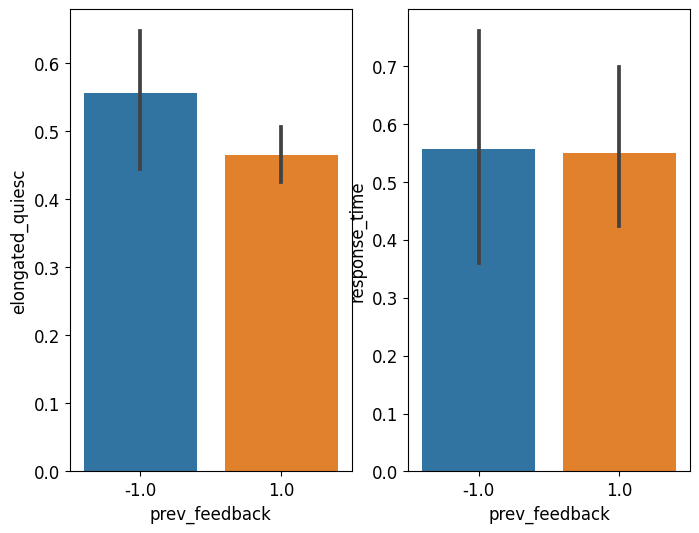

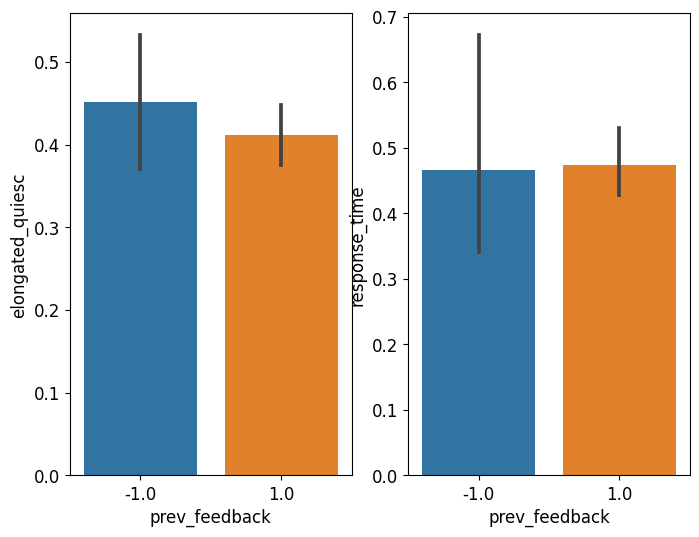

local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 18.7kB/s]


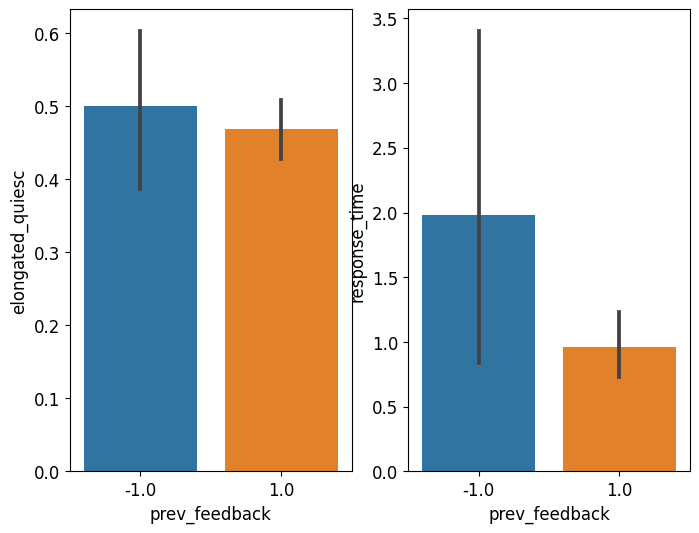

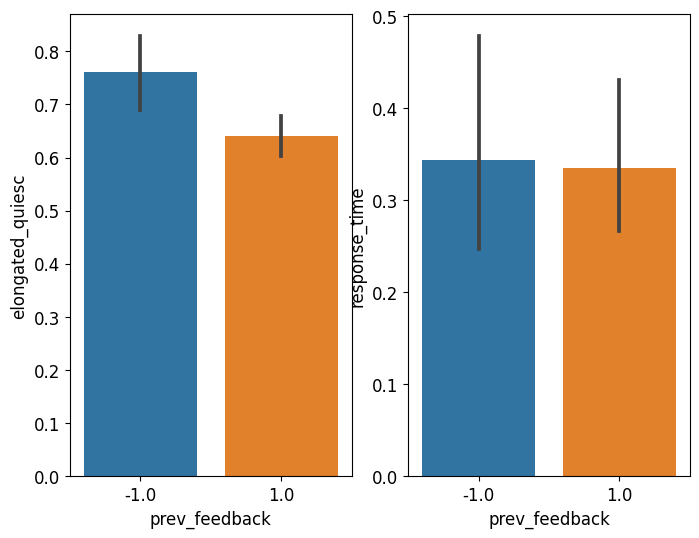

local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.53k/6.53k [00:00<00:00, 23.9kB/s]


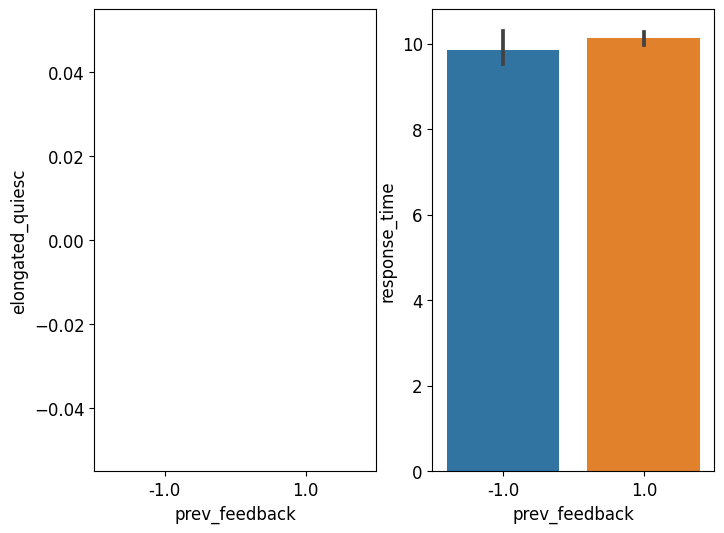

local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 17.6kB/s]


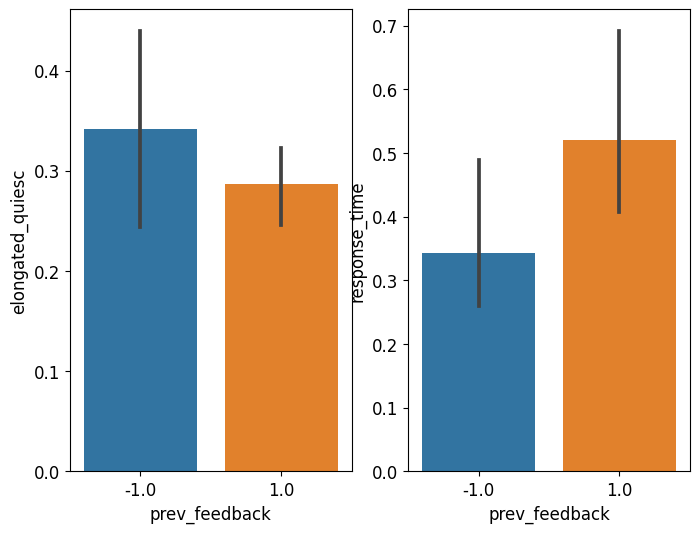

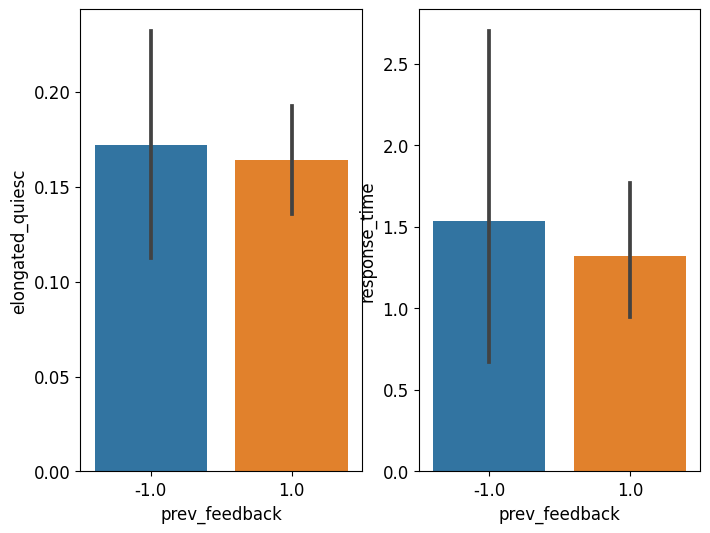

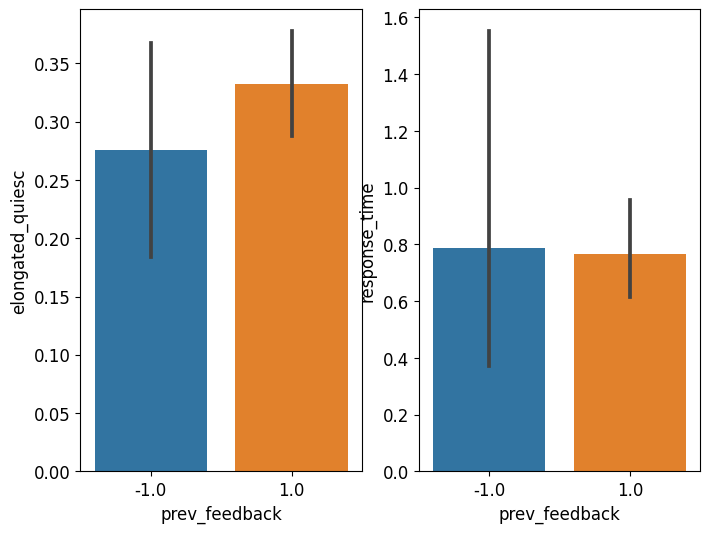

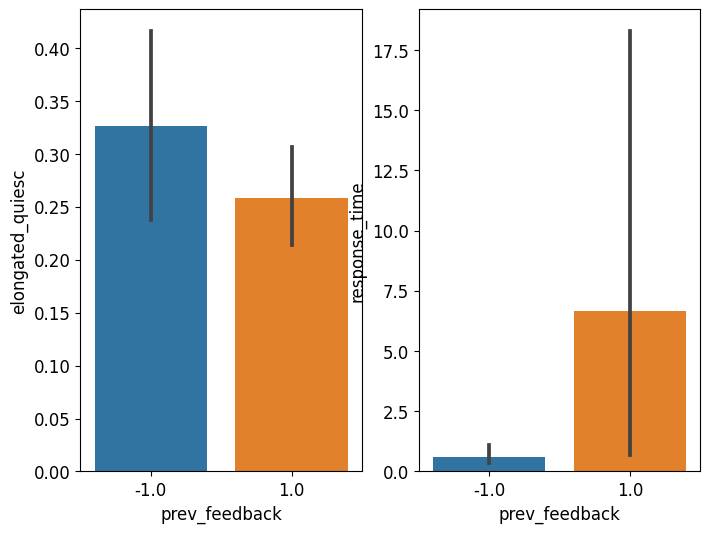

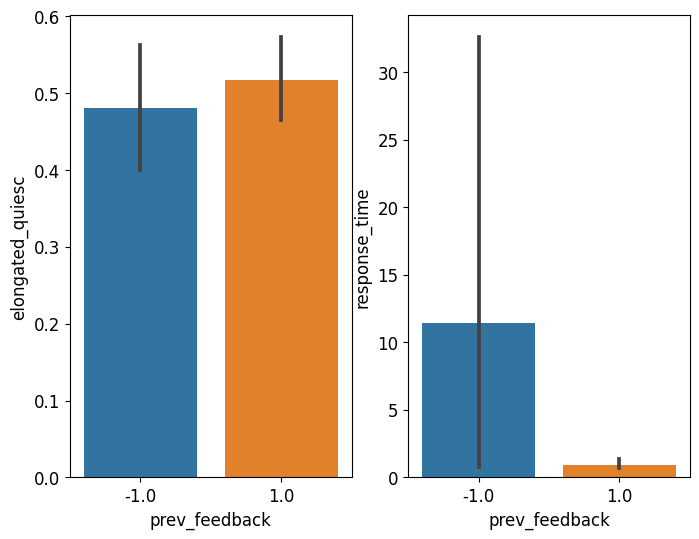

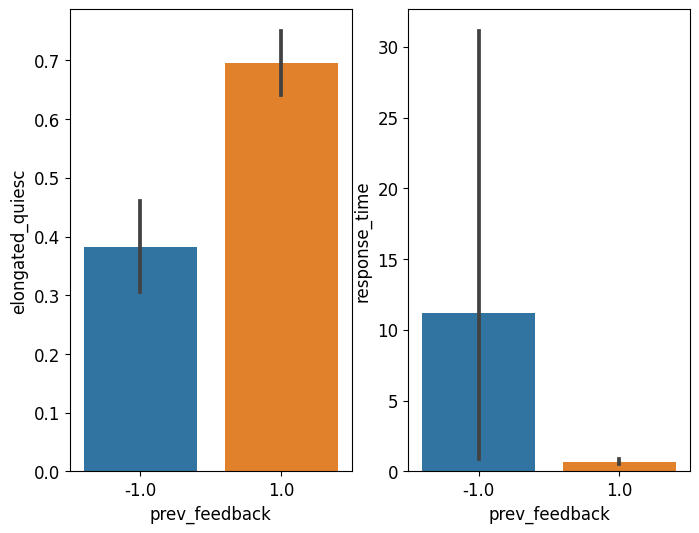

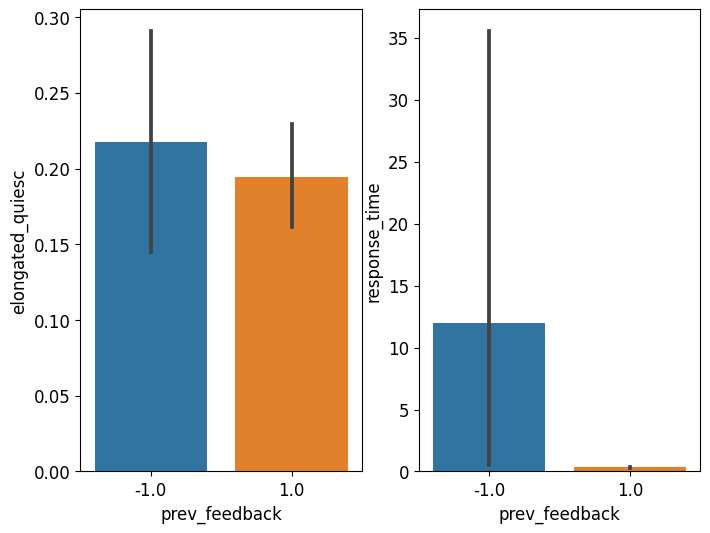

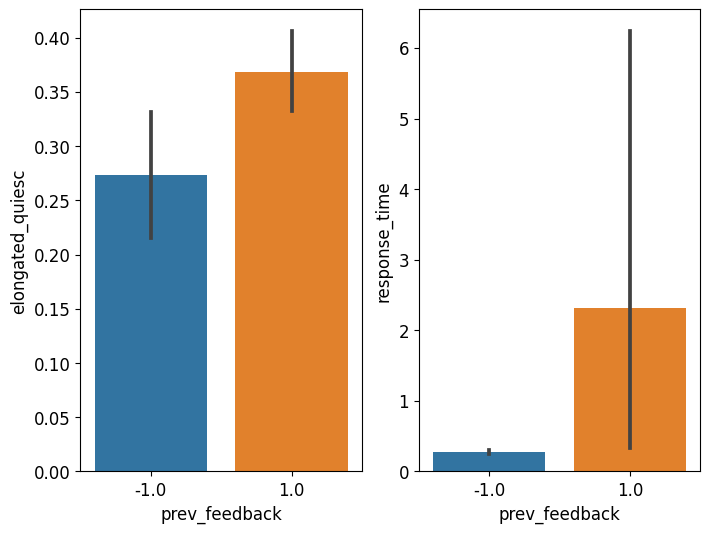

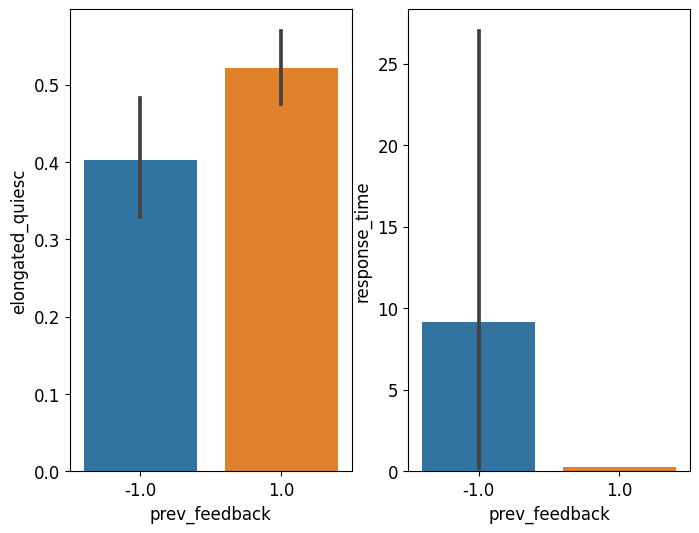

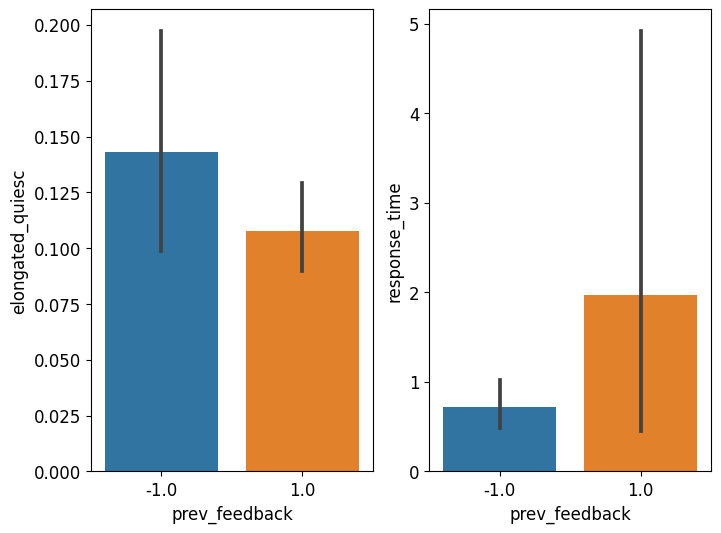

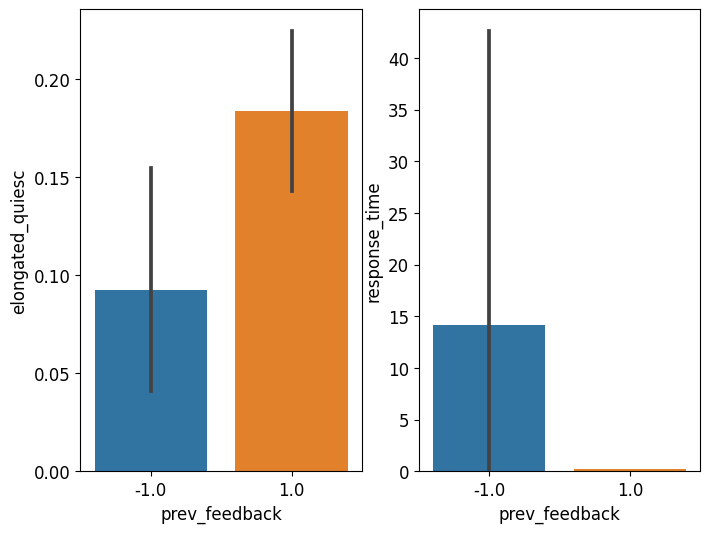

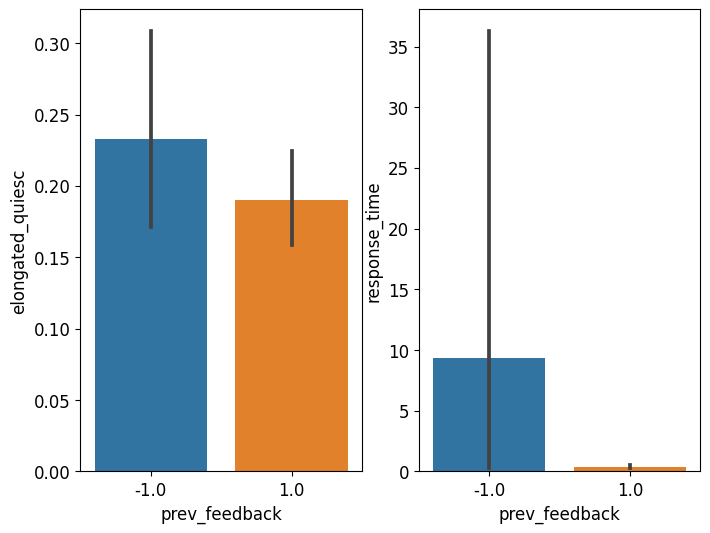

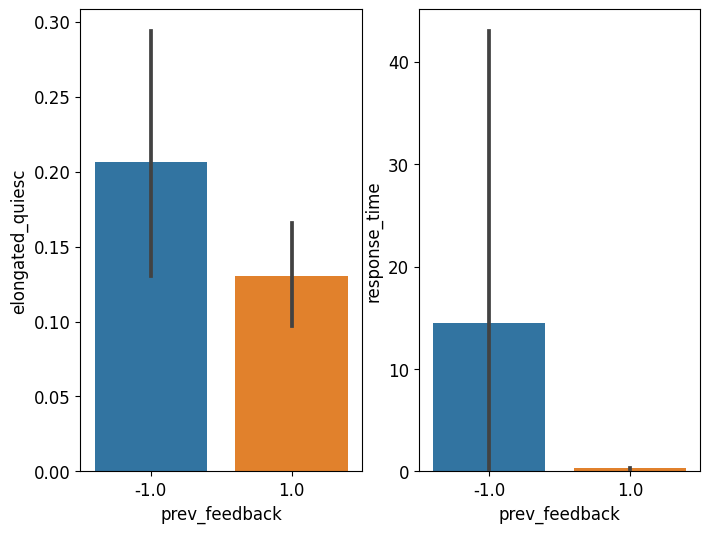

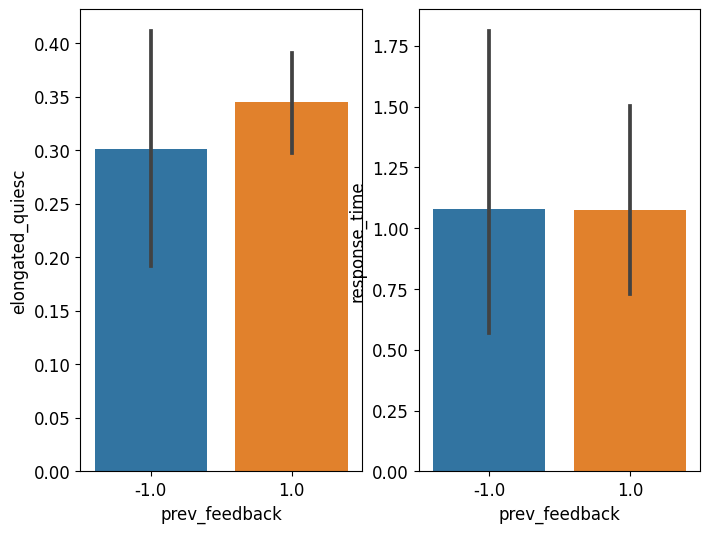

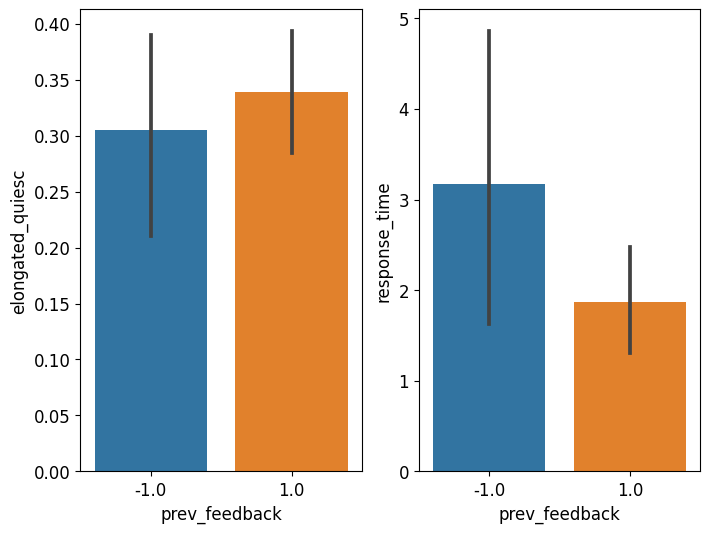

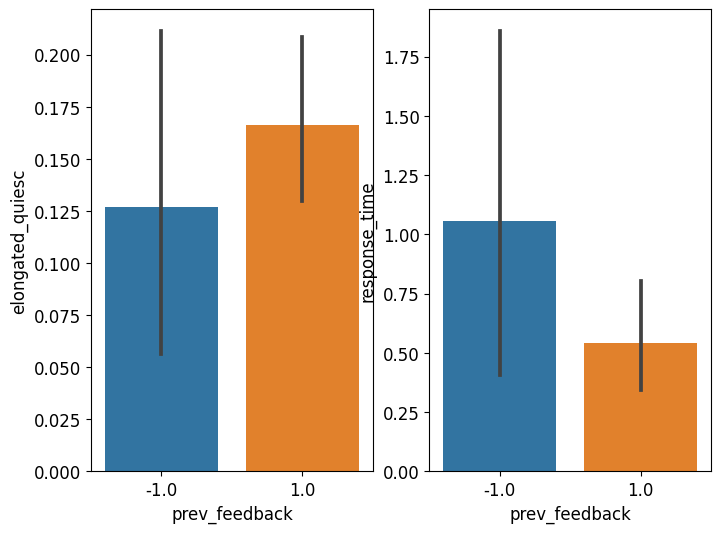

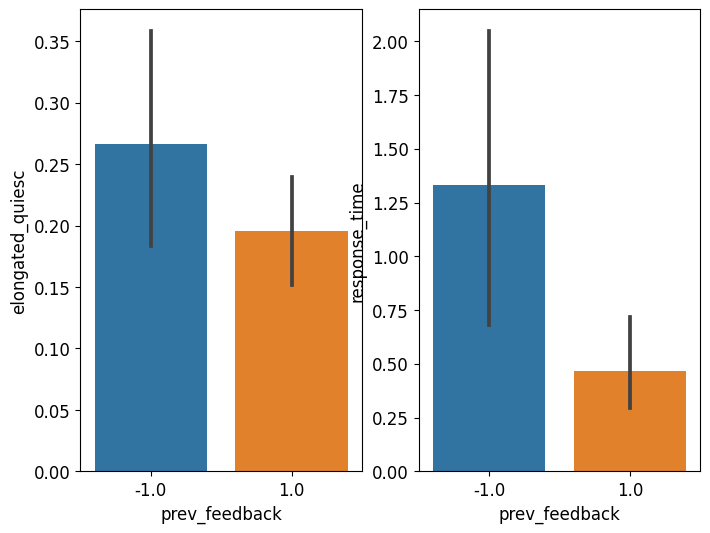

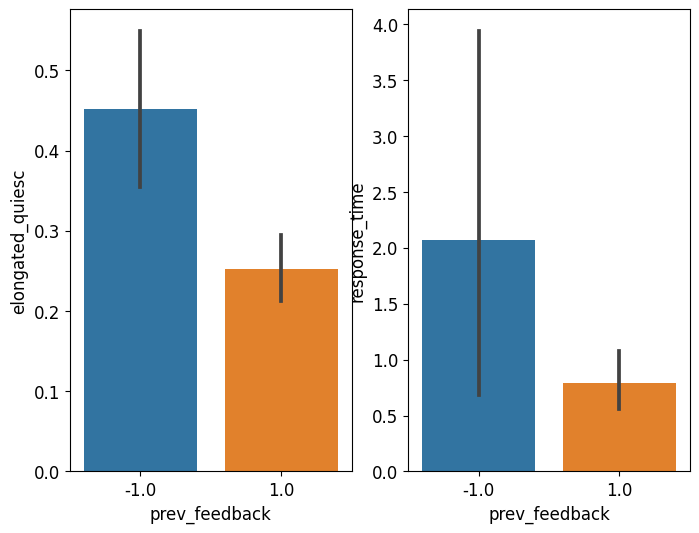

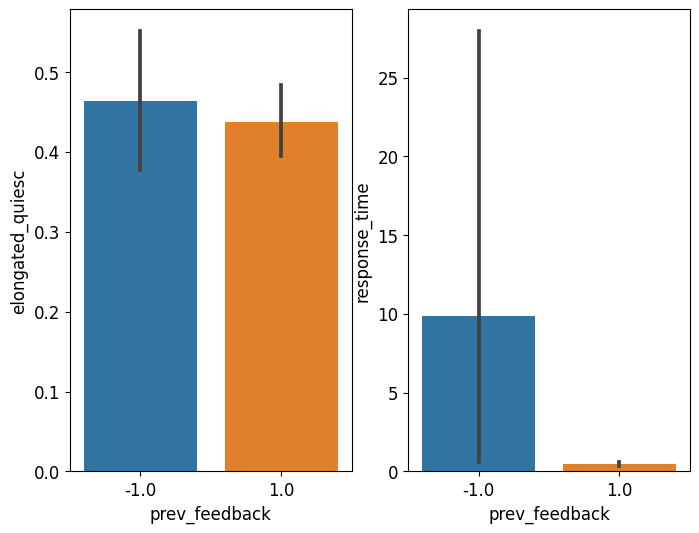

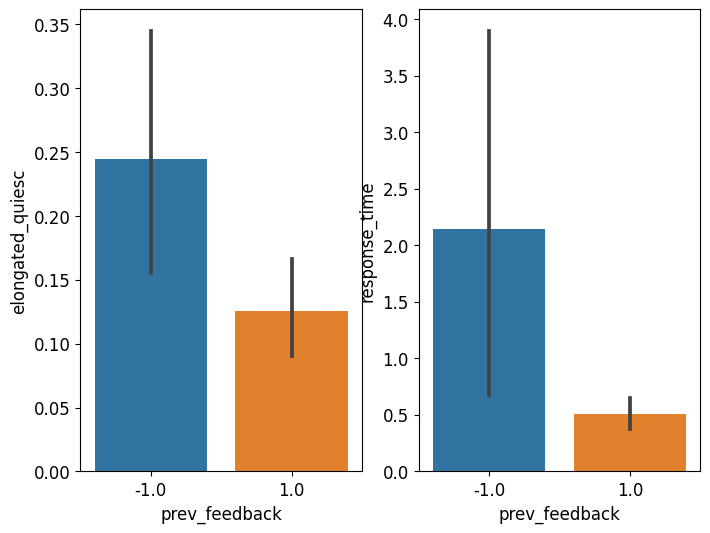

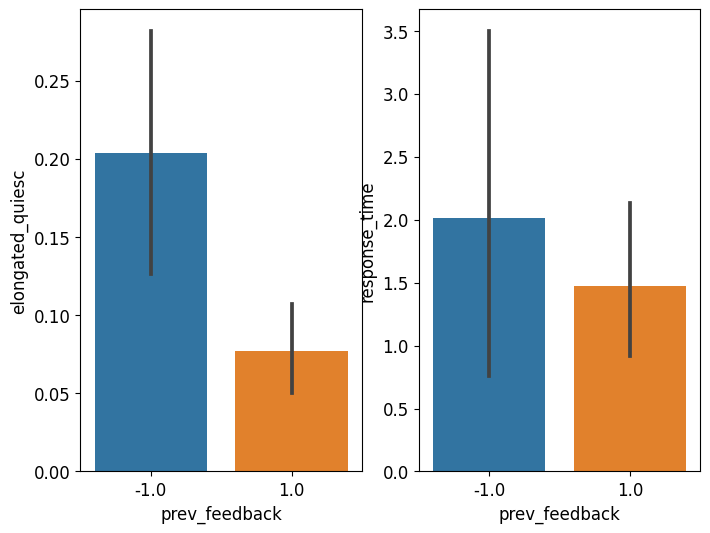

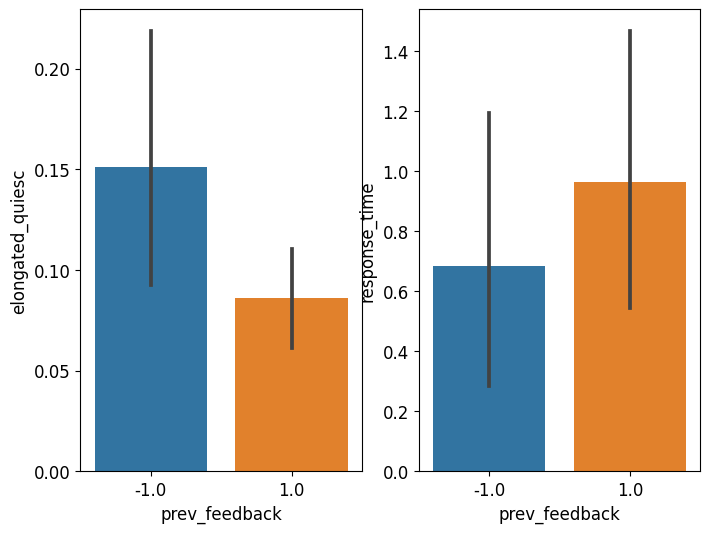

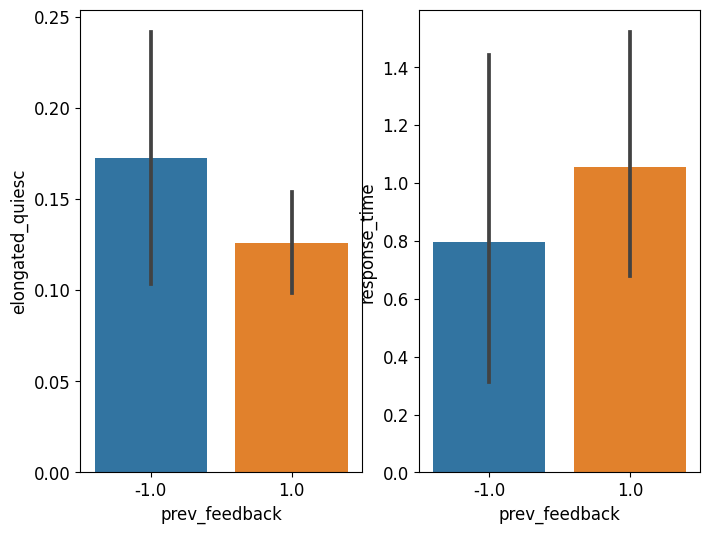

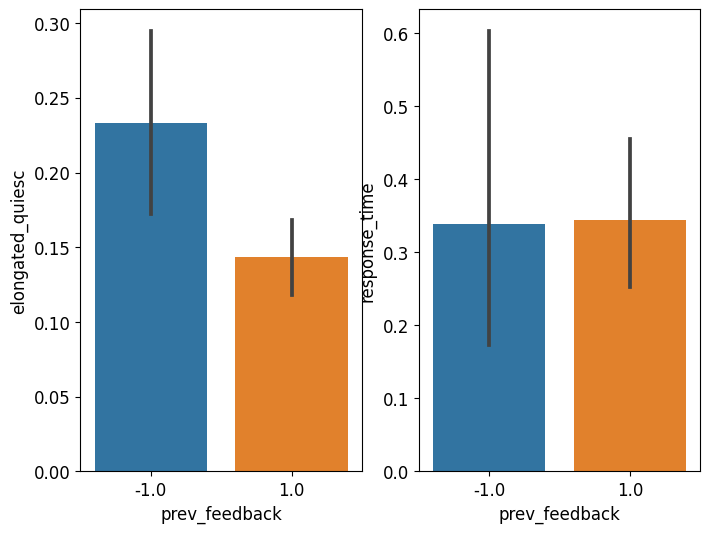

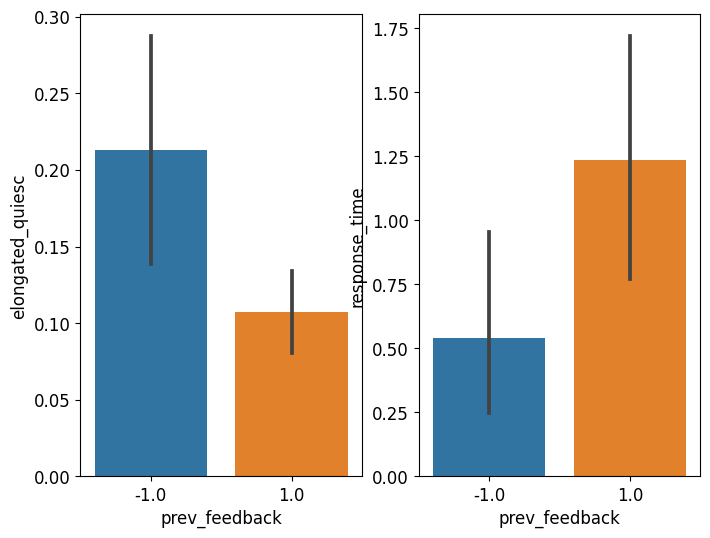

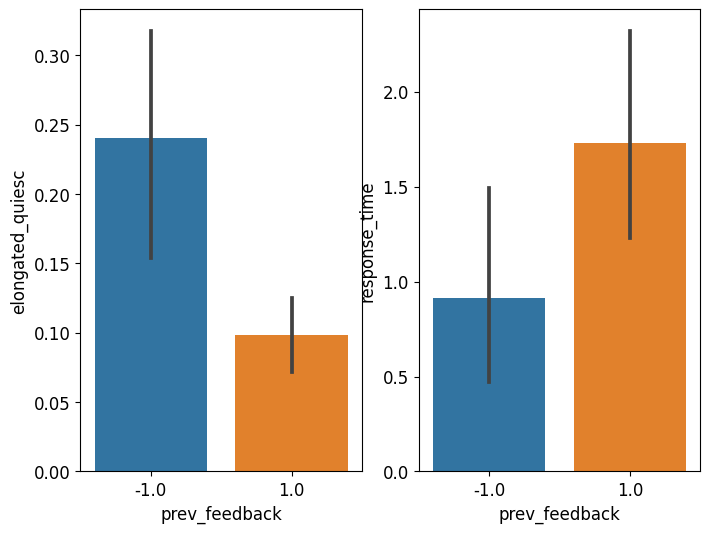

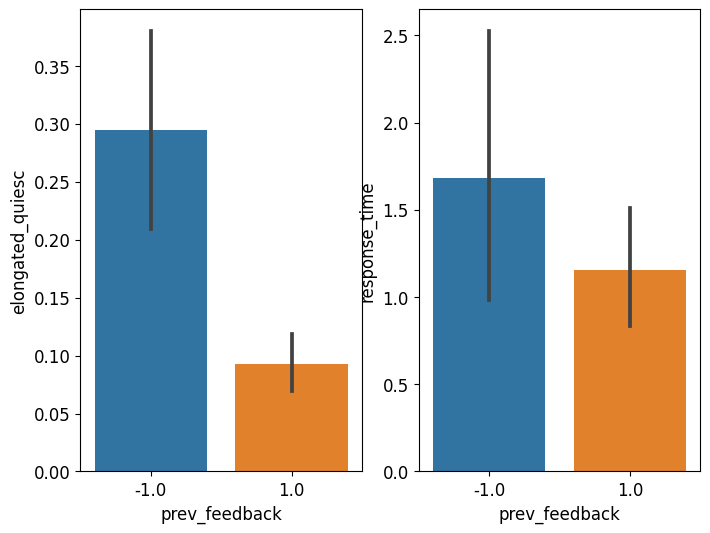

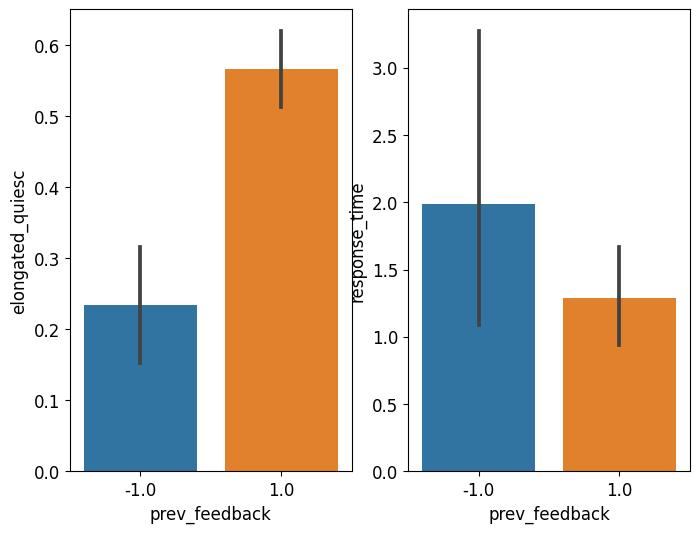

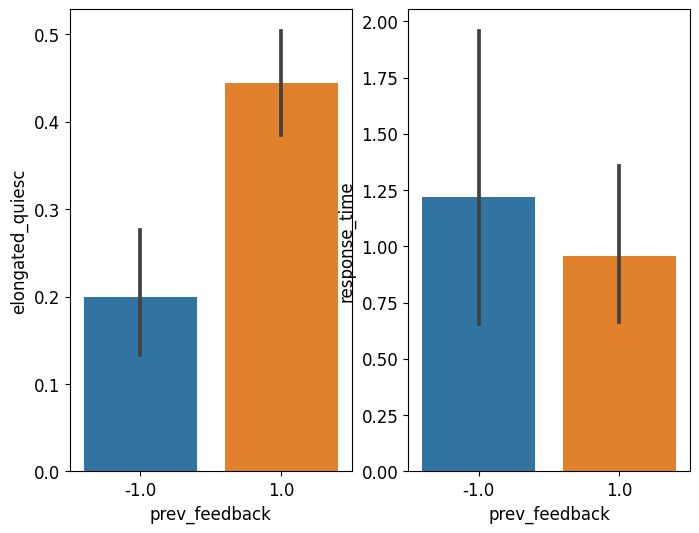

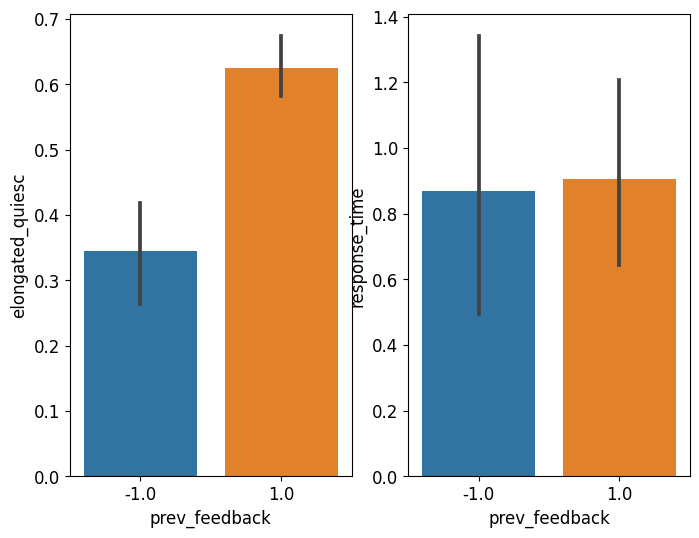

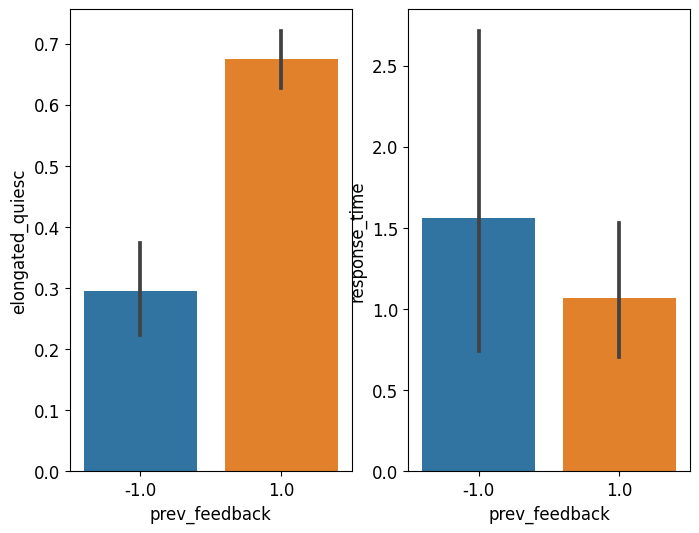

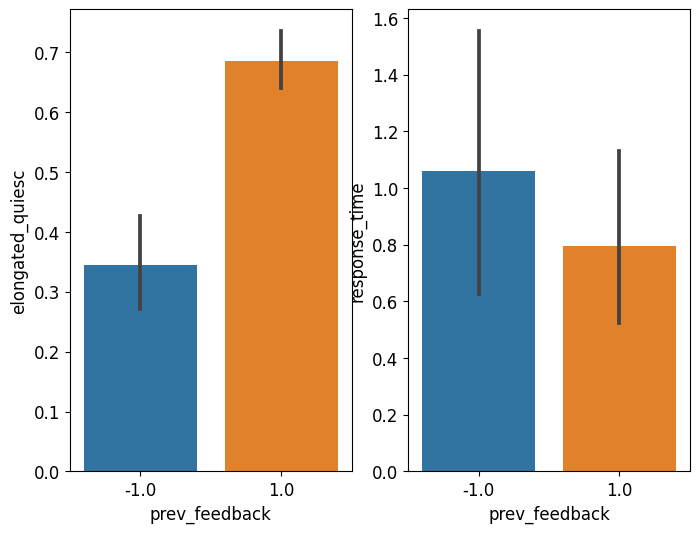

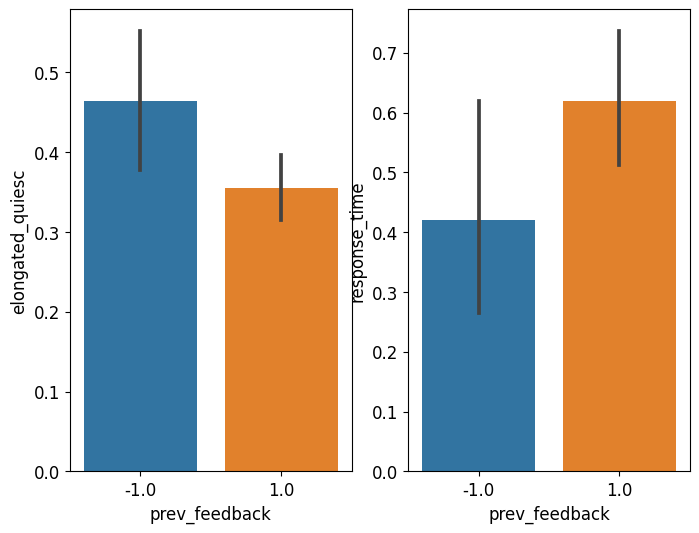

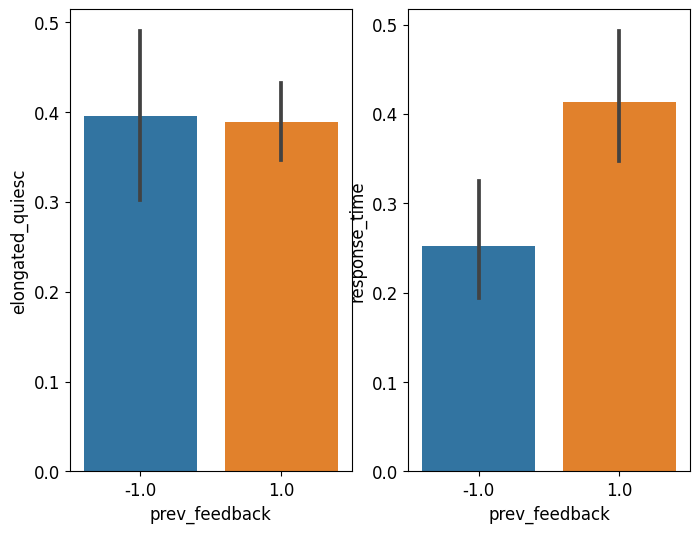

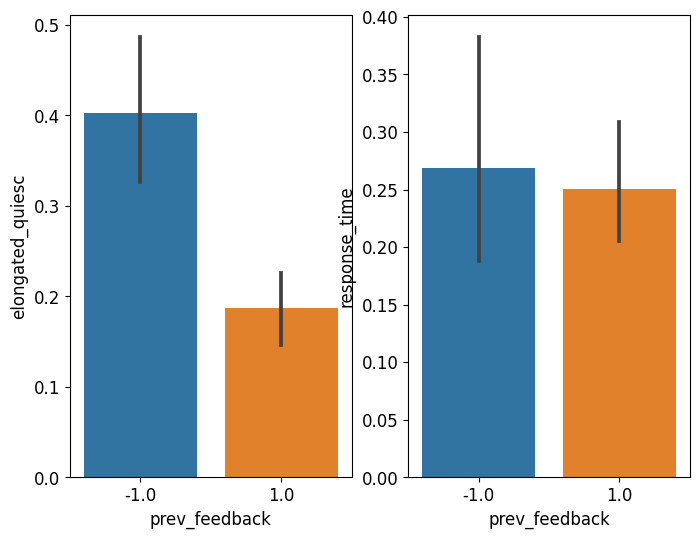

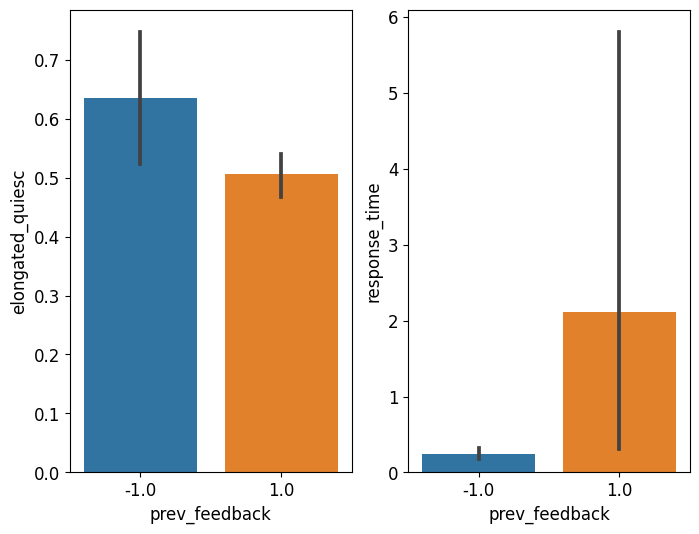

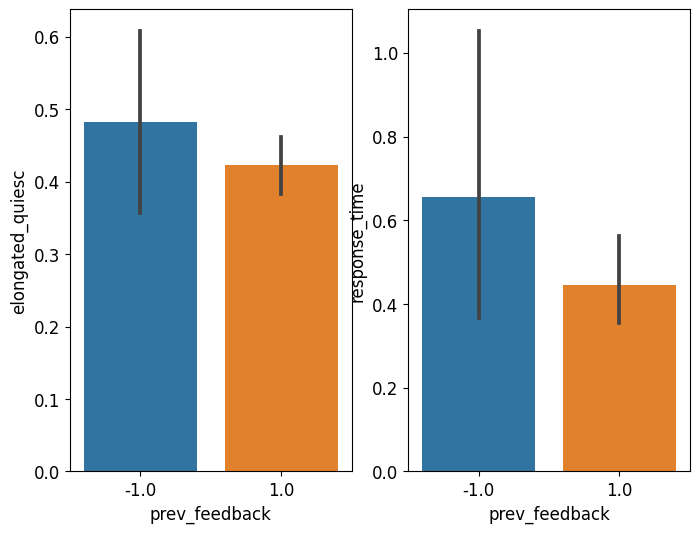

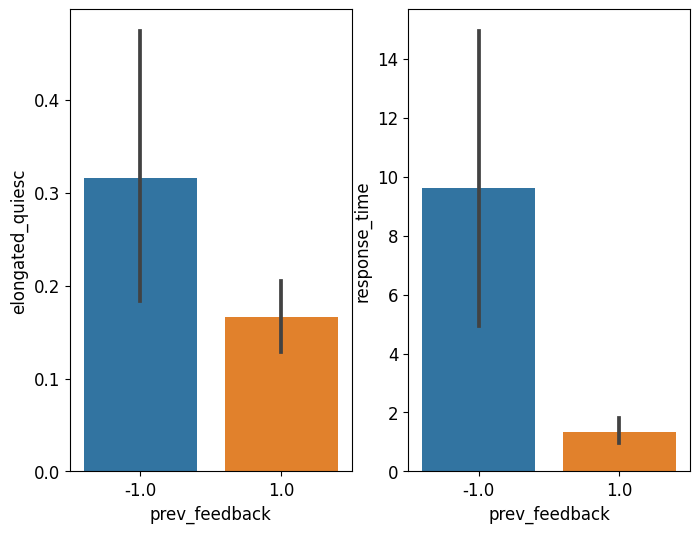

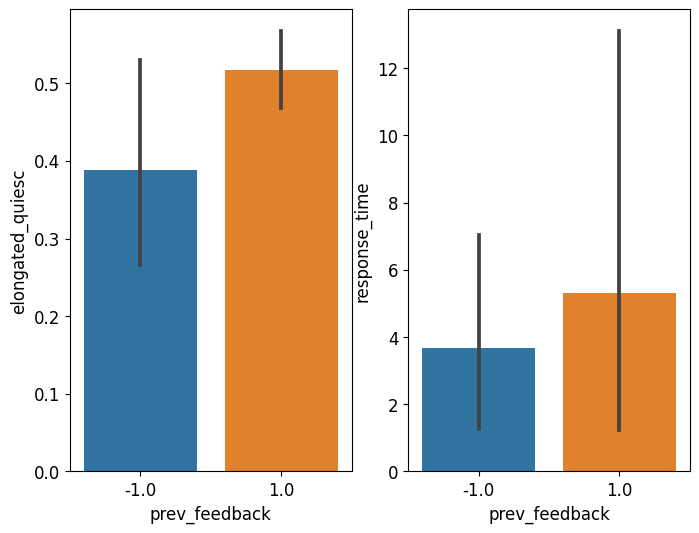

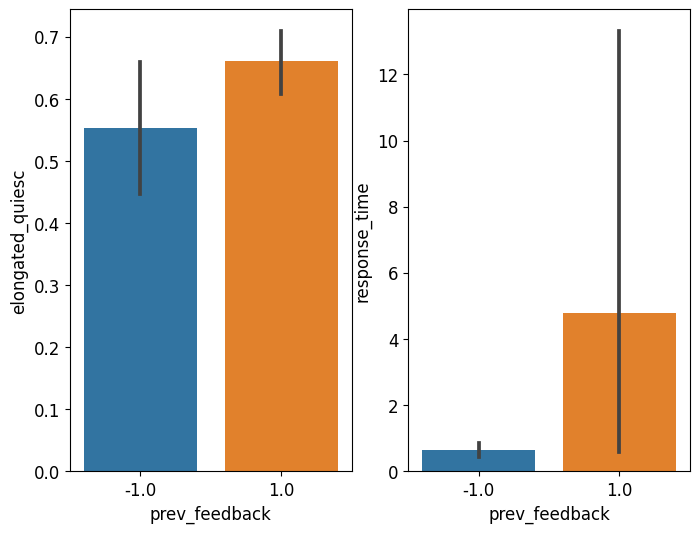

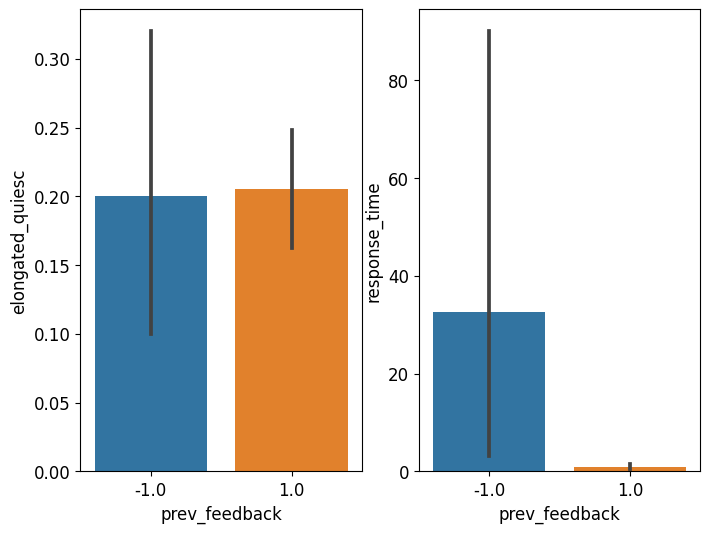

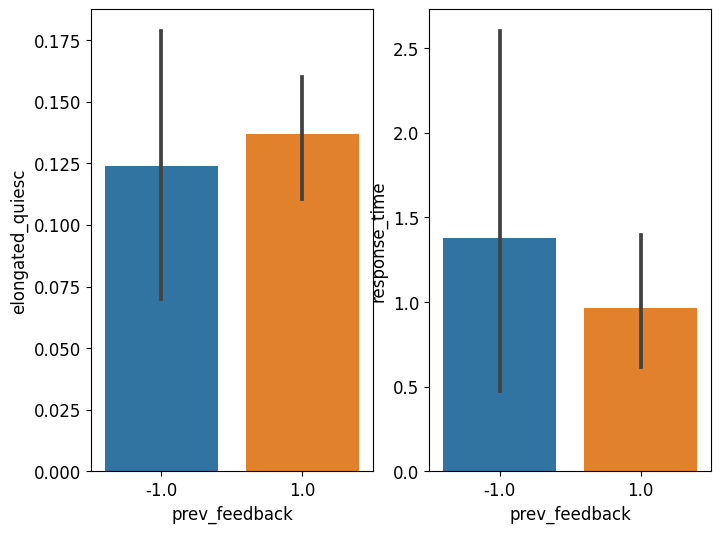

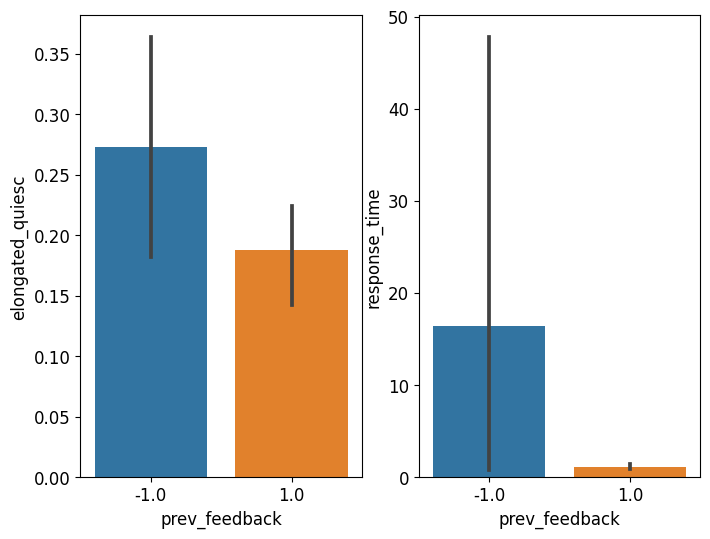

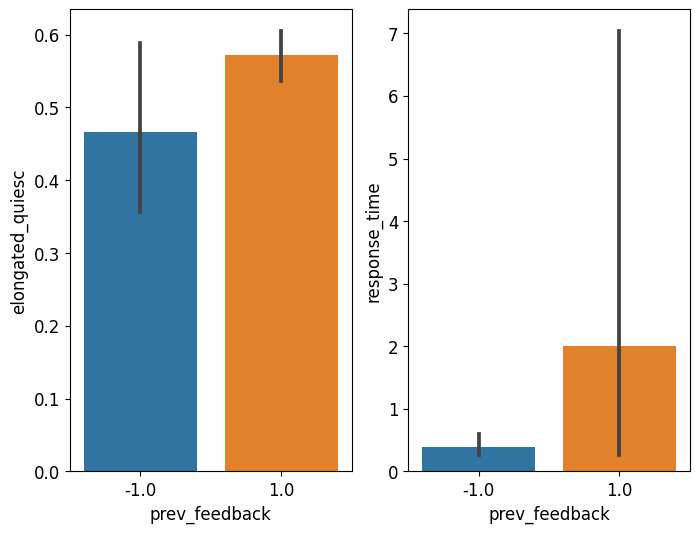

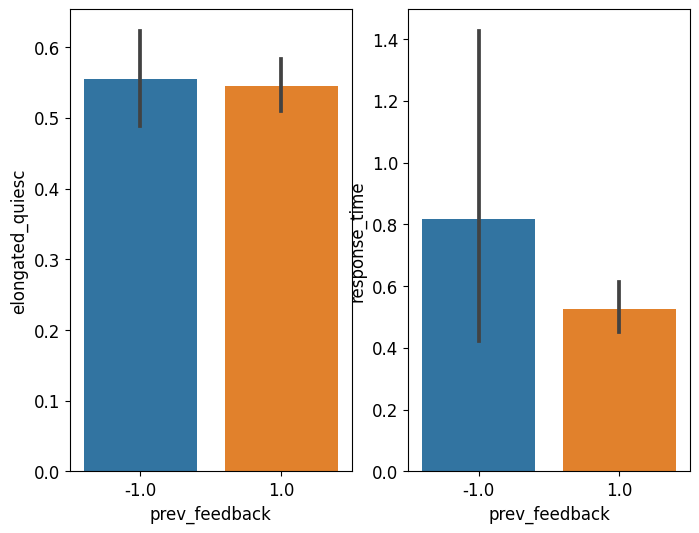

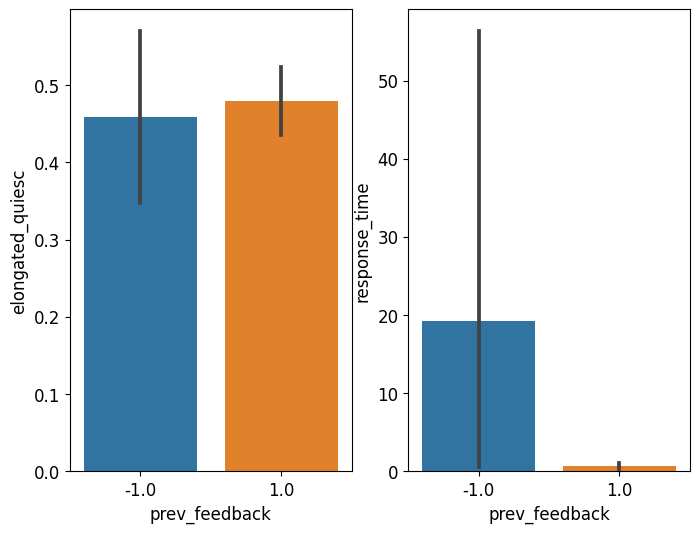

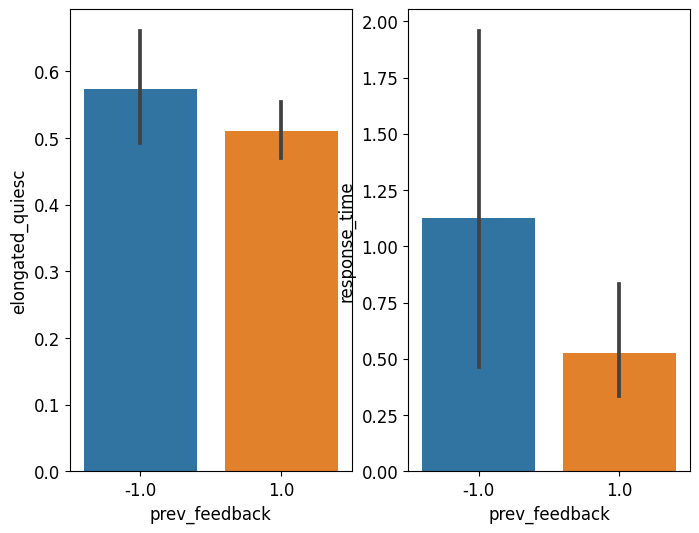

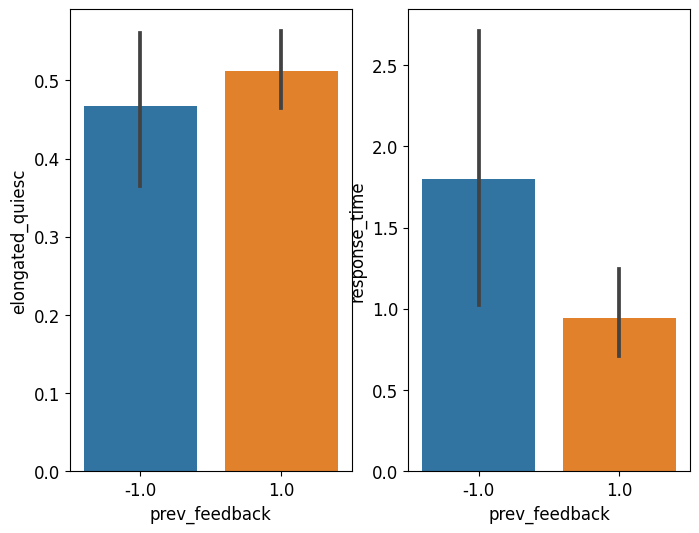

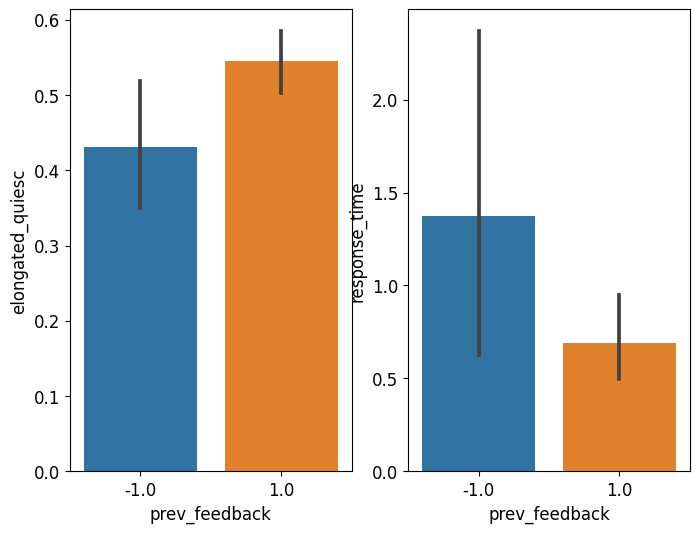

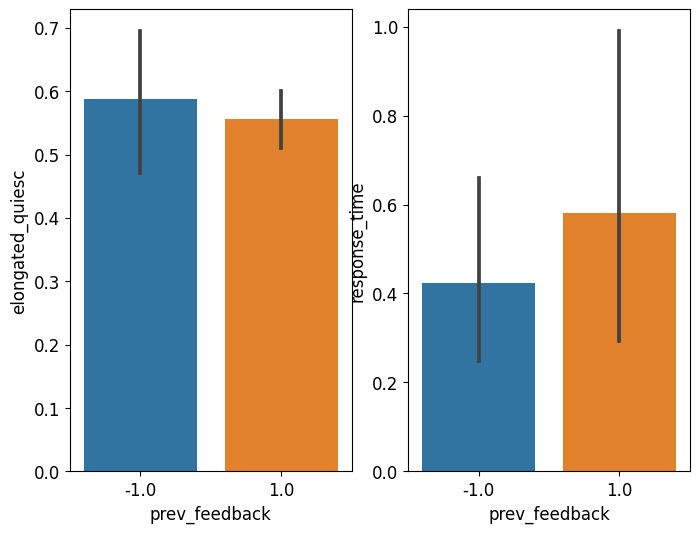

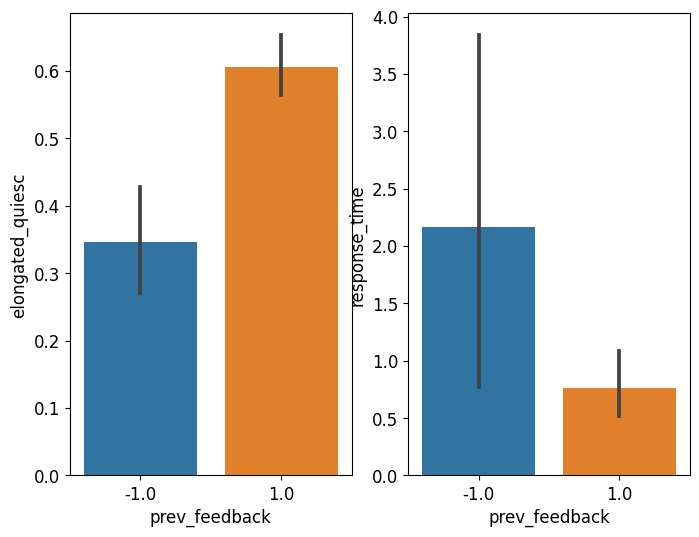

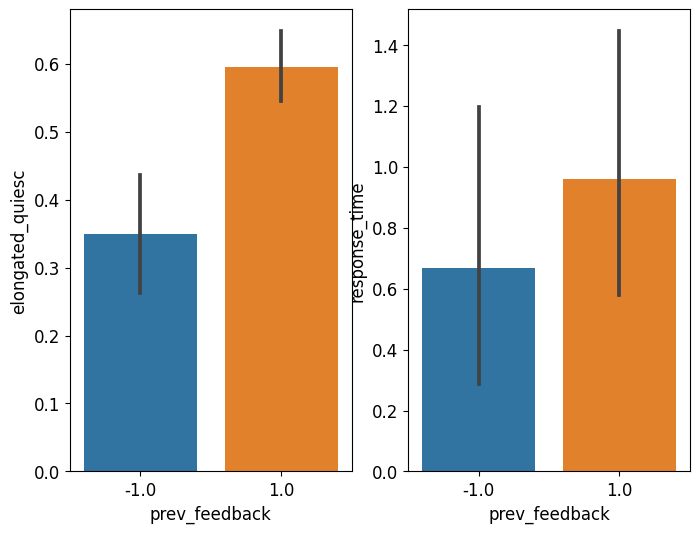

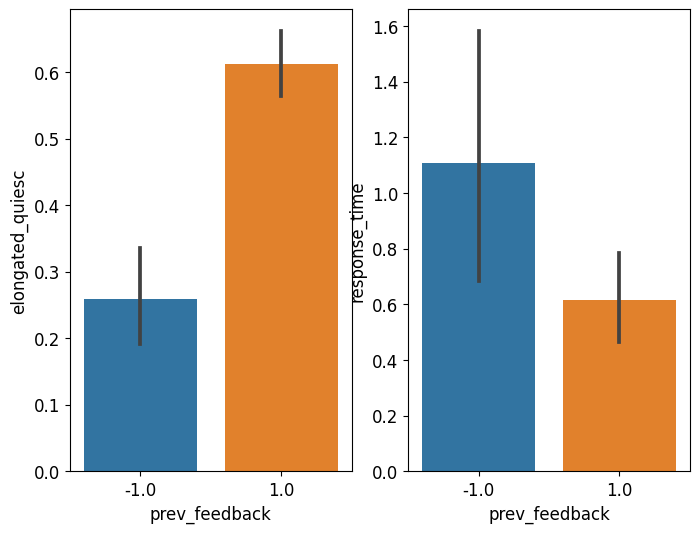

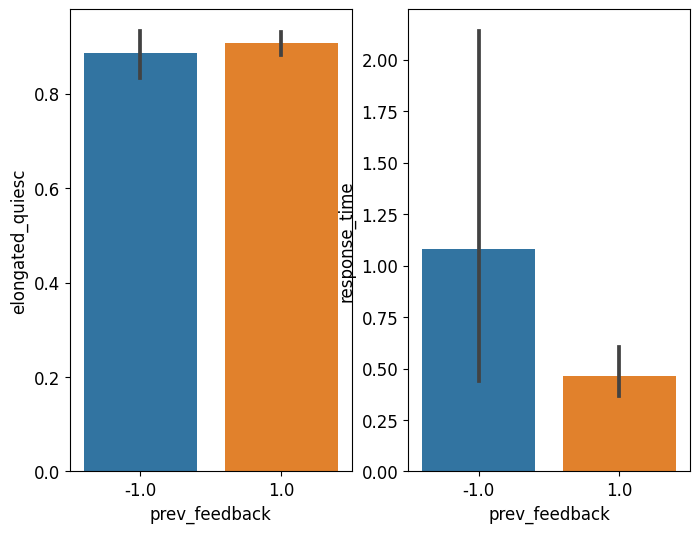

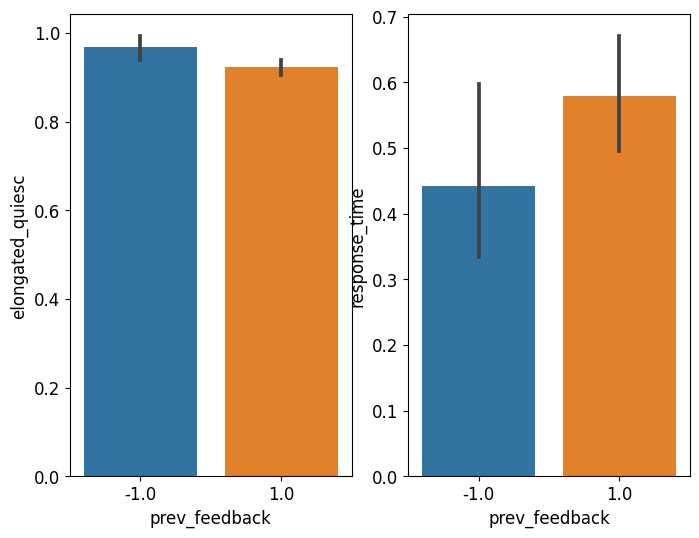

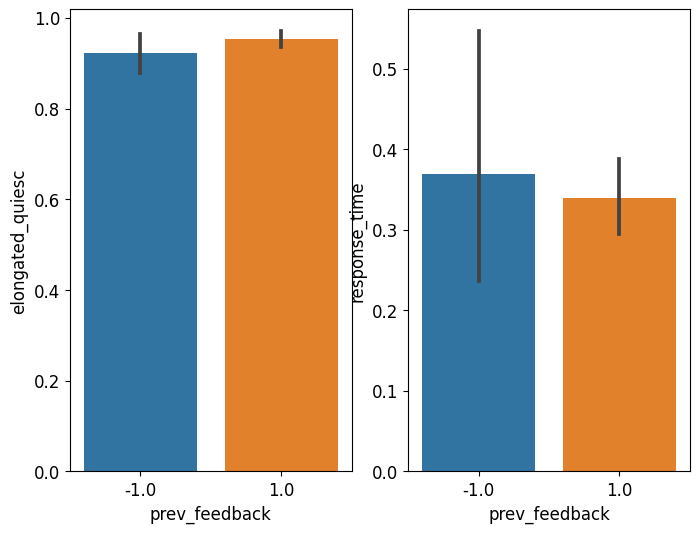

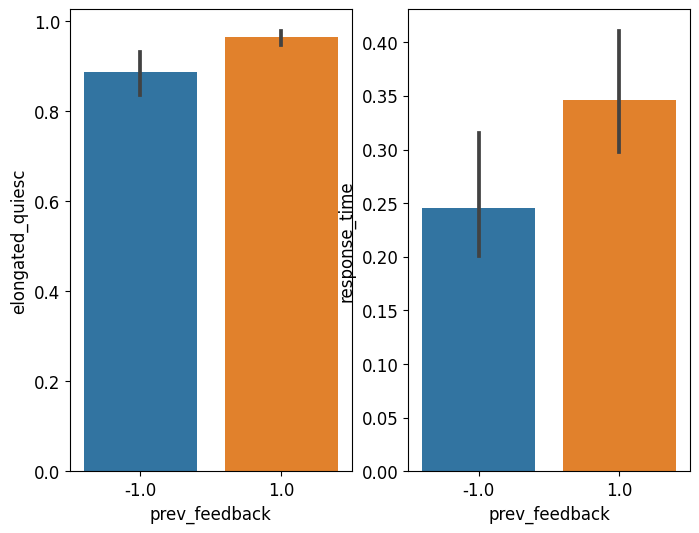

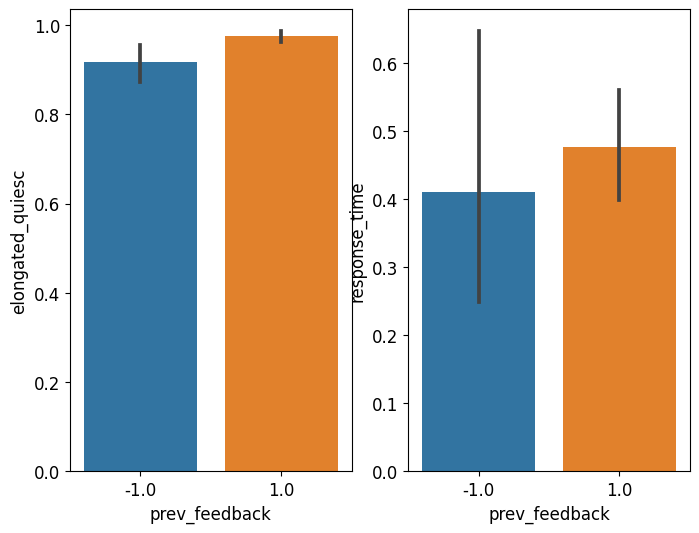

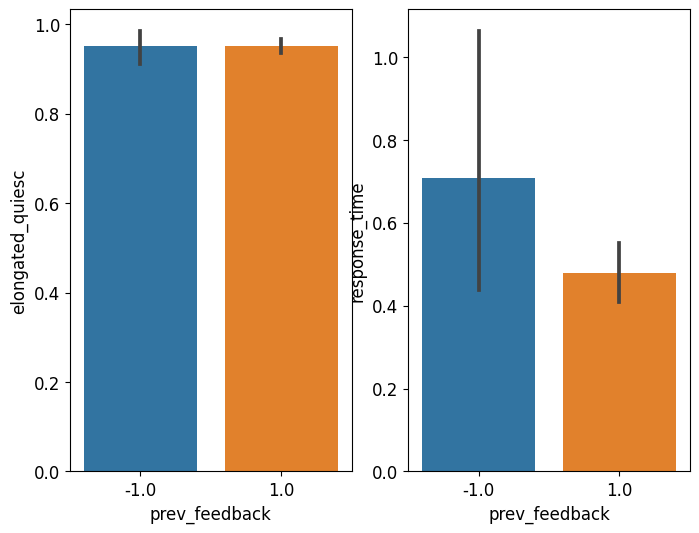

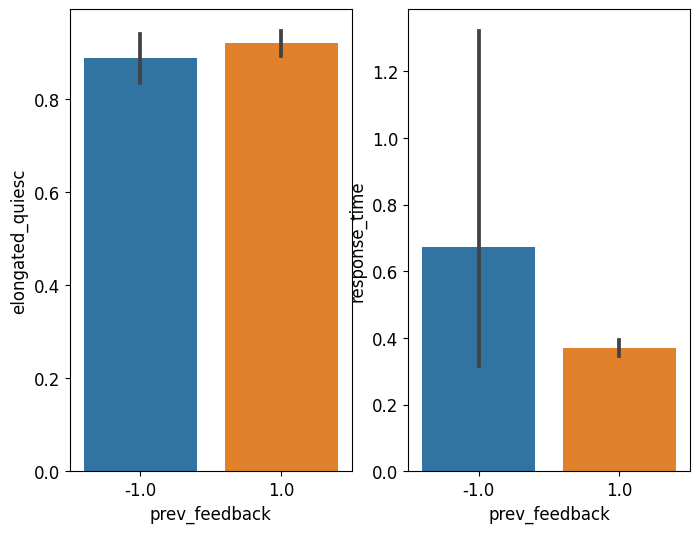

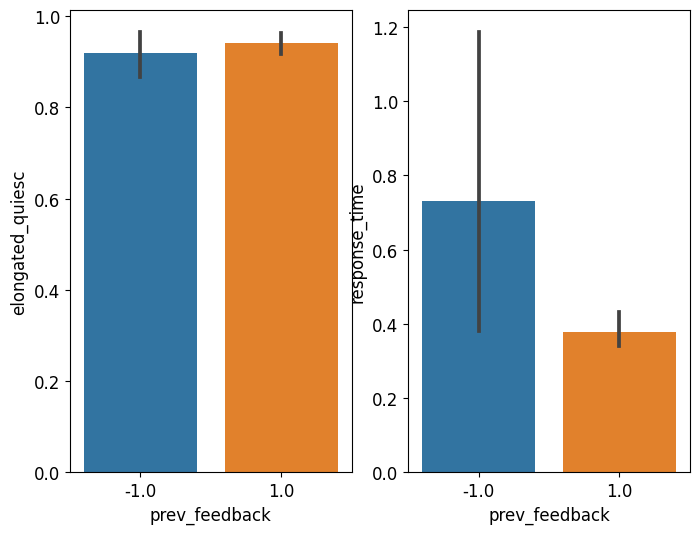

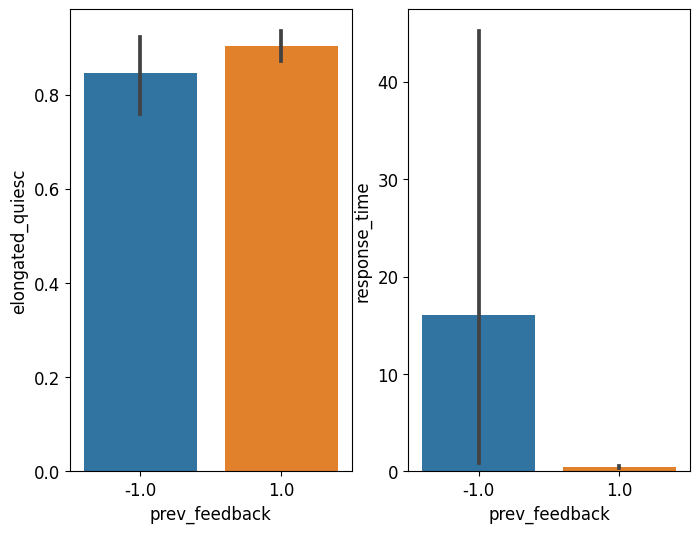

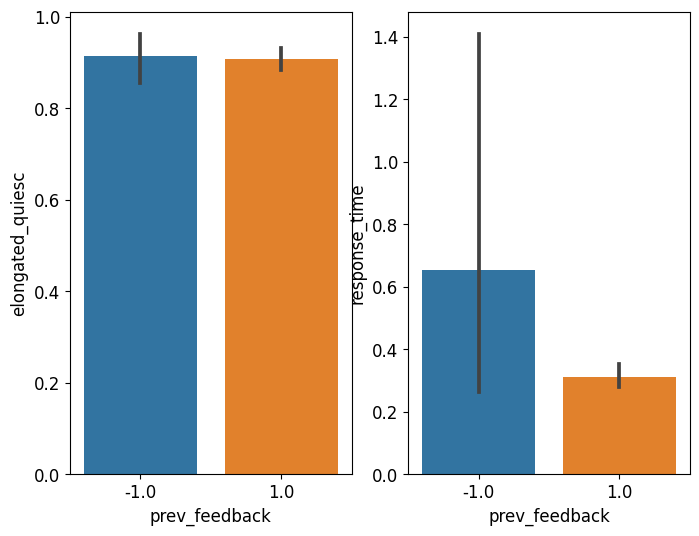

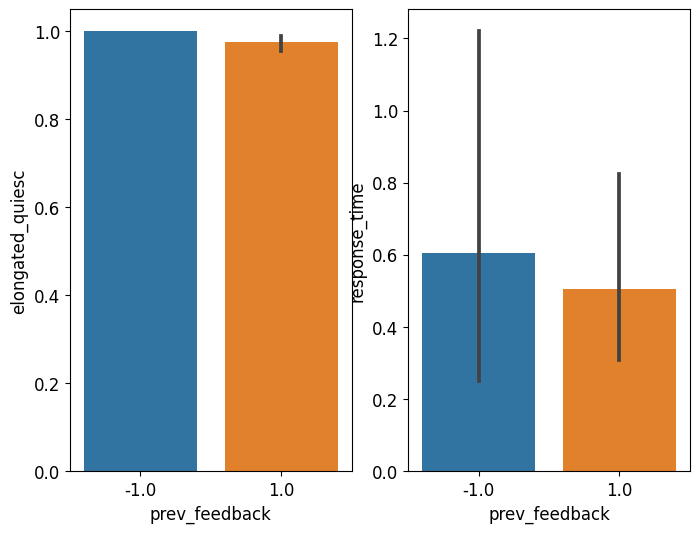

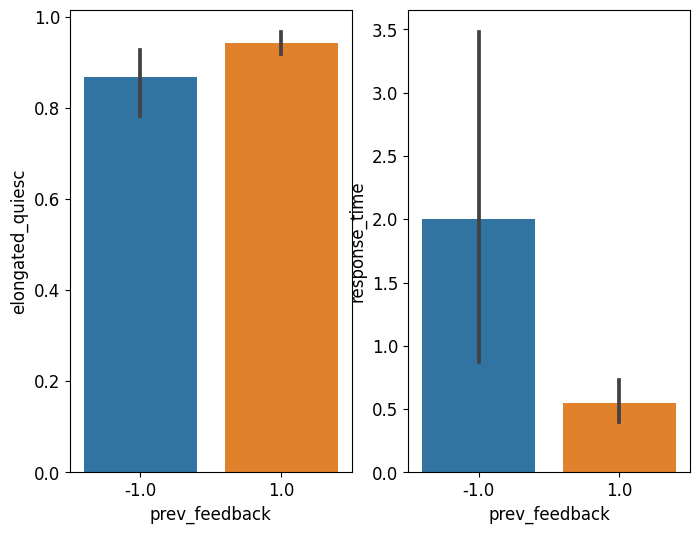

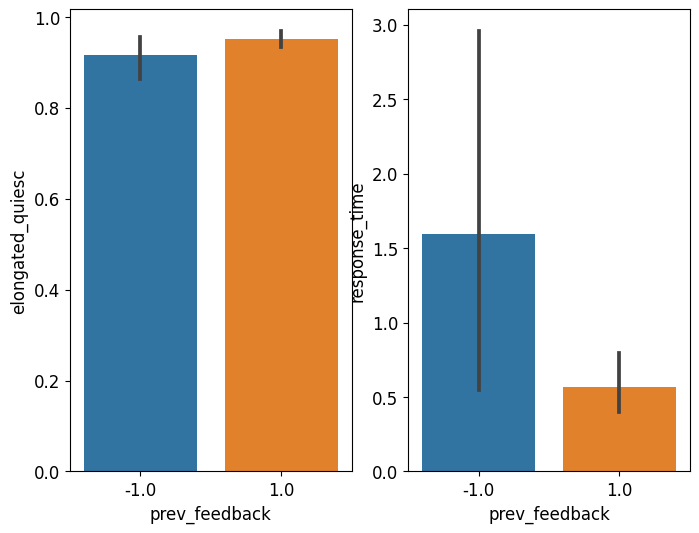

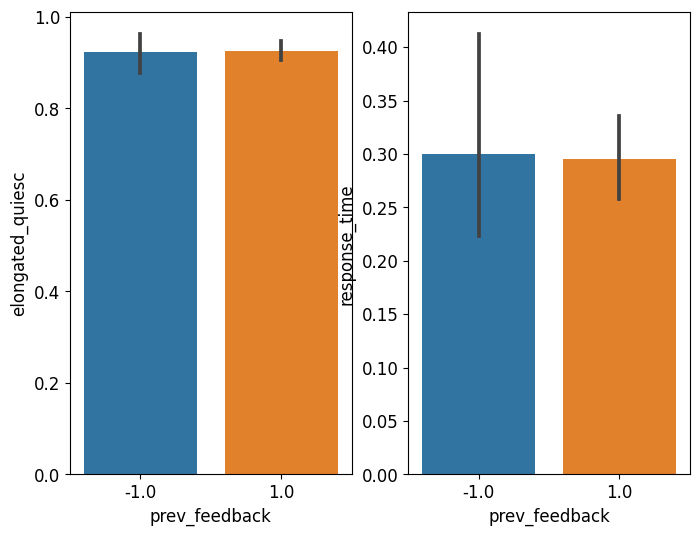

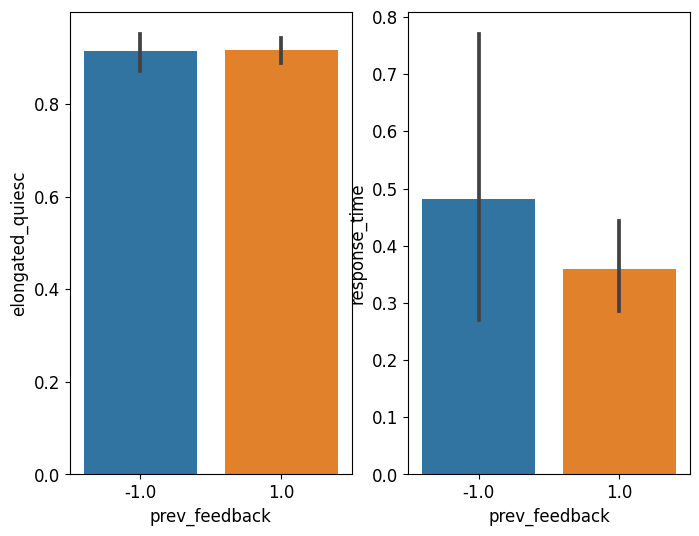

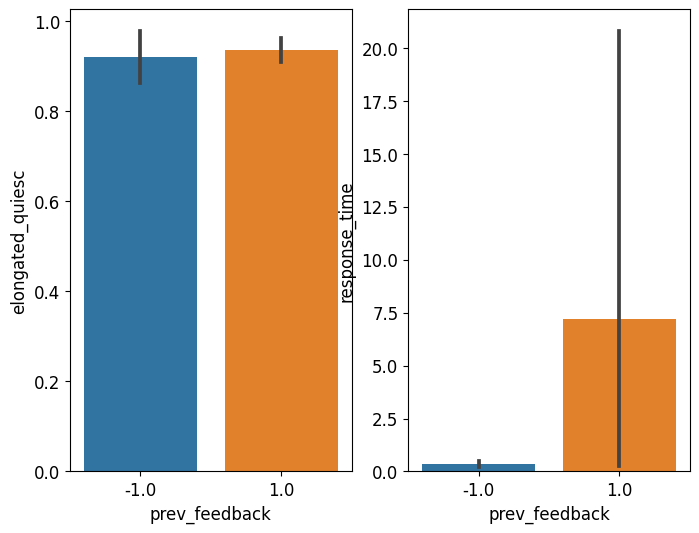

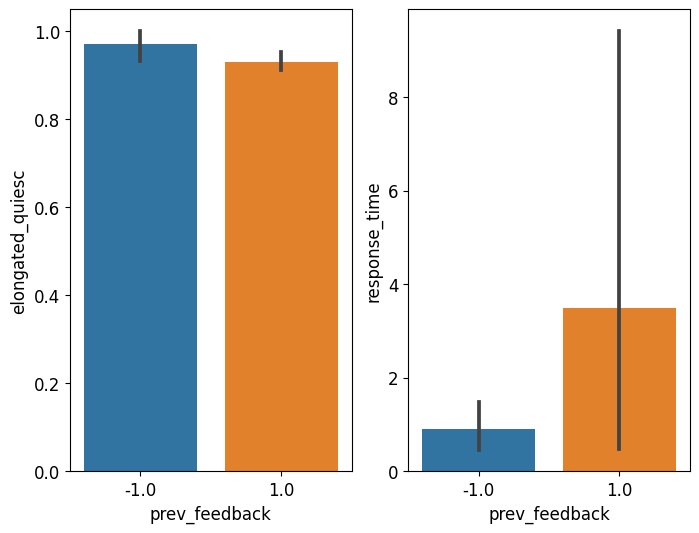

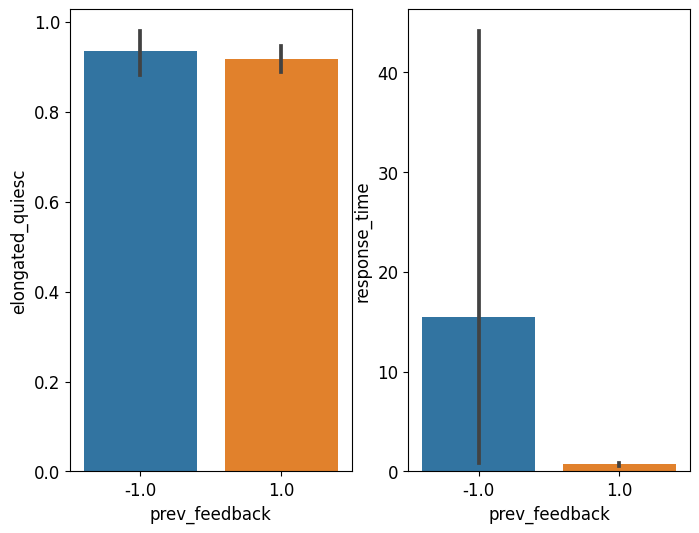

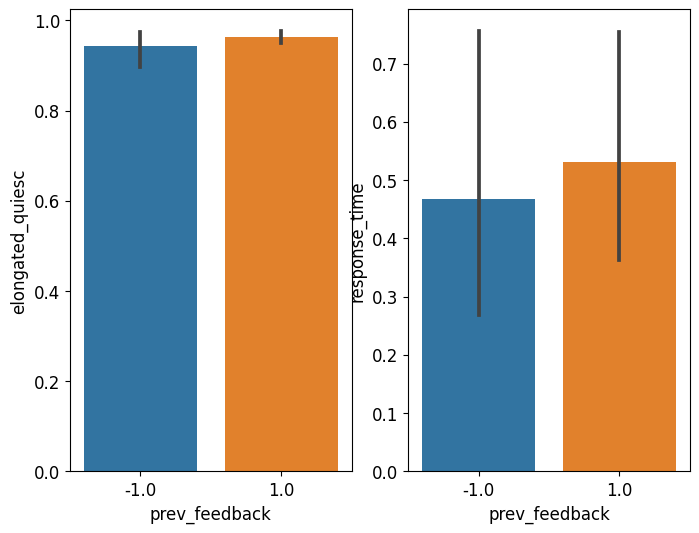

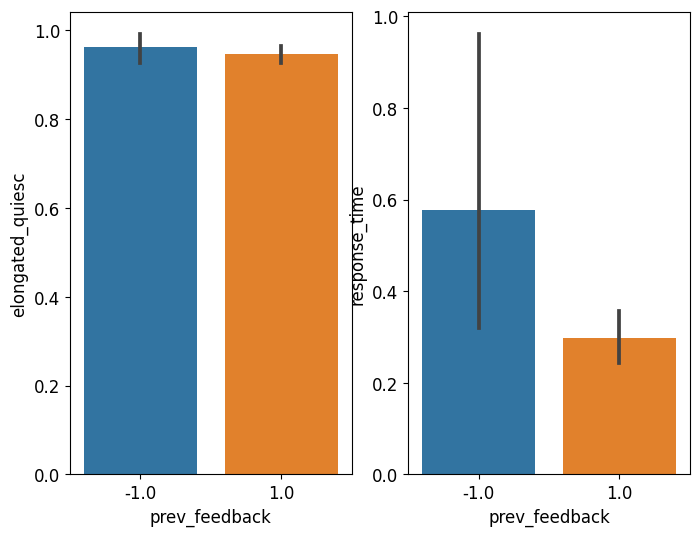

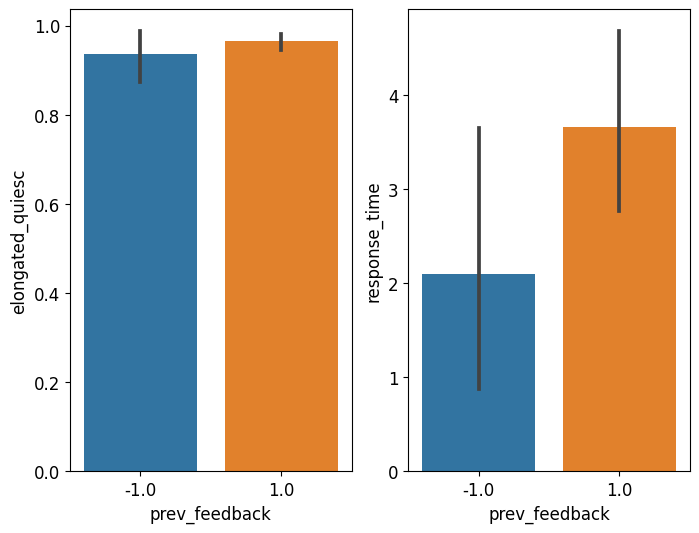

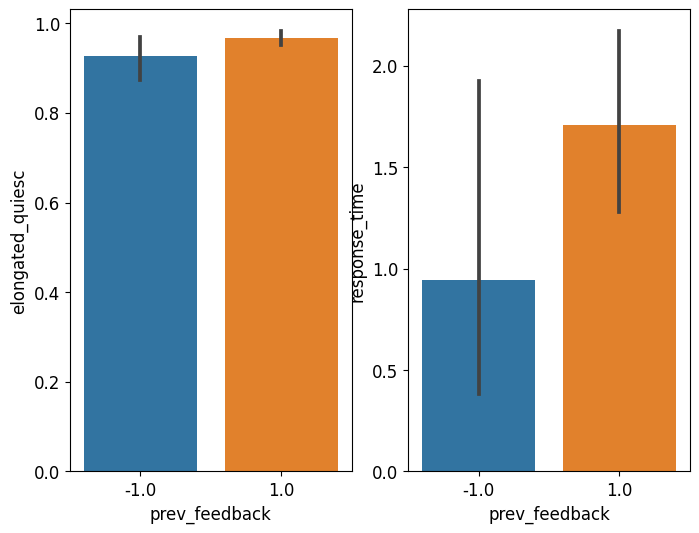

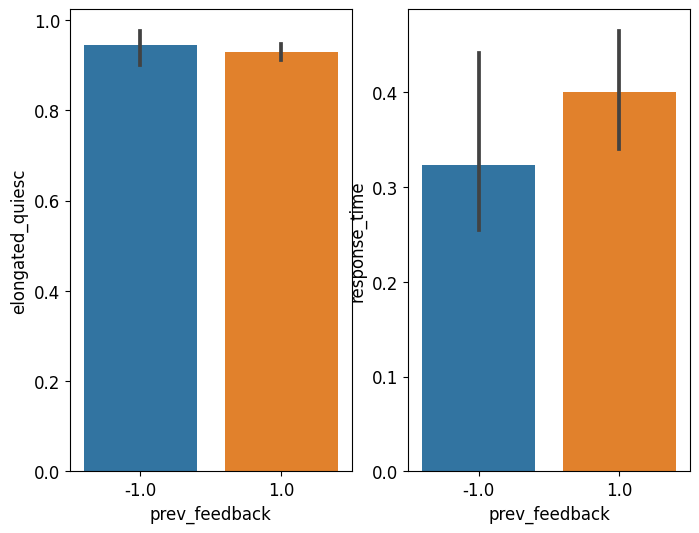

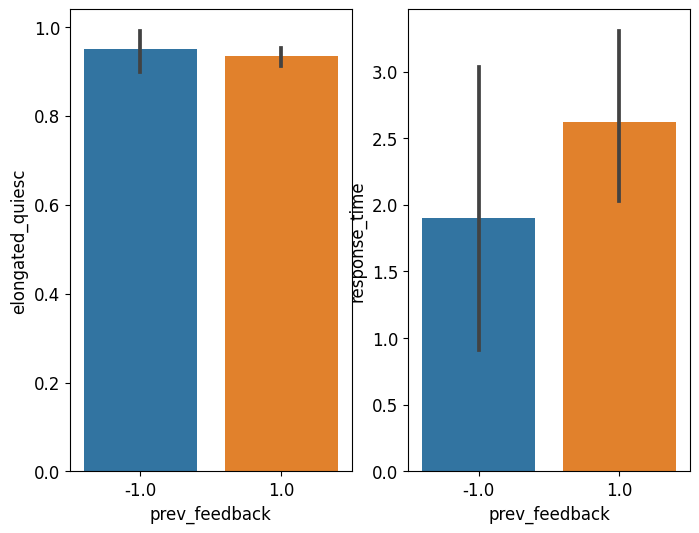

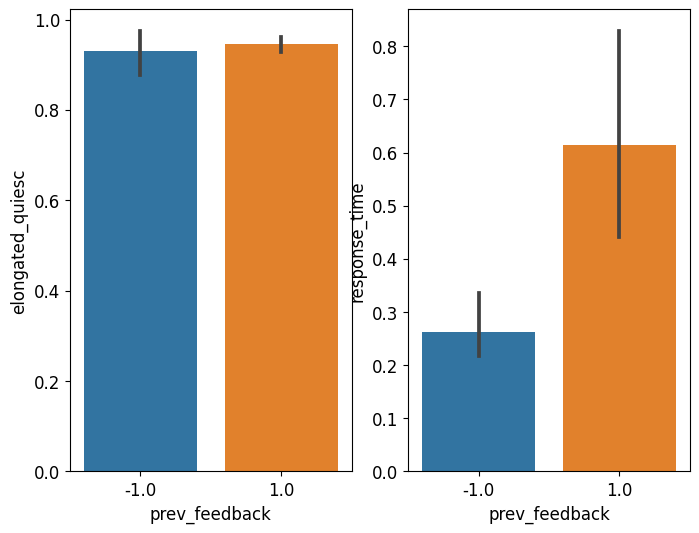

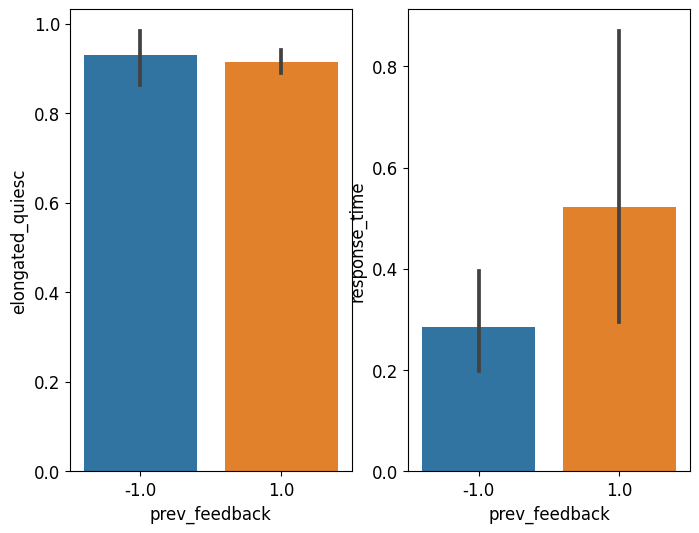

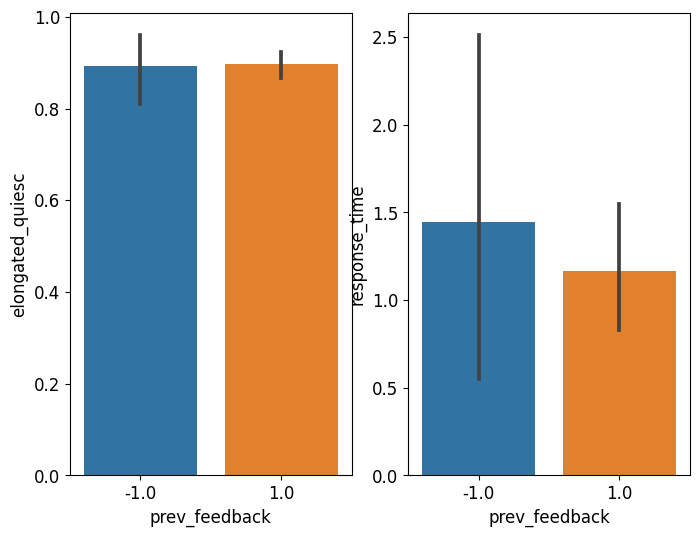

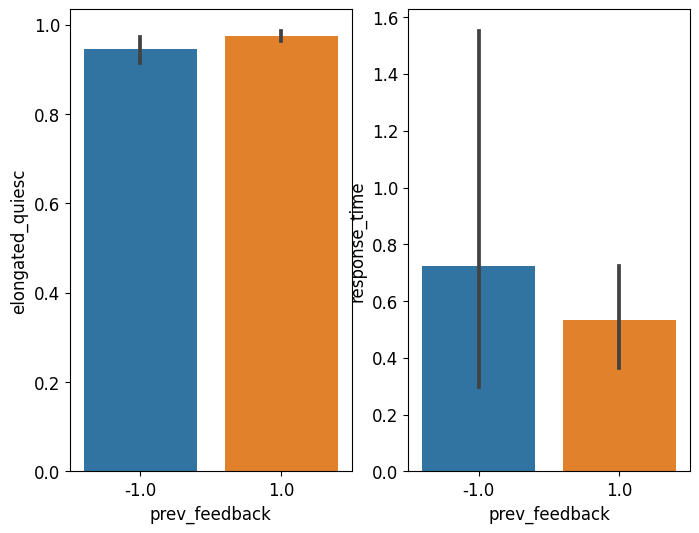

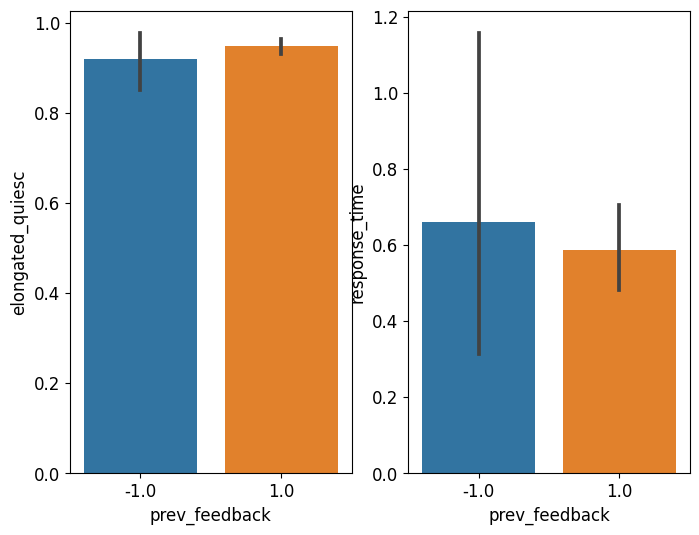

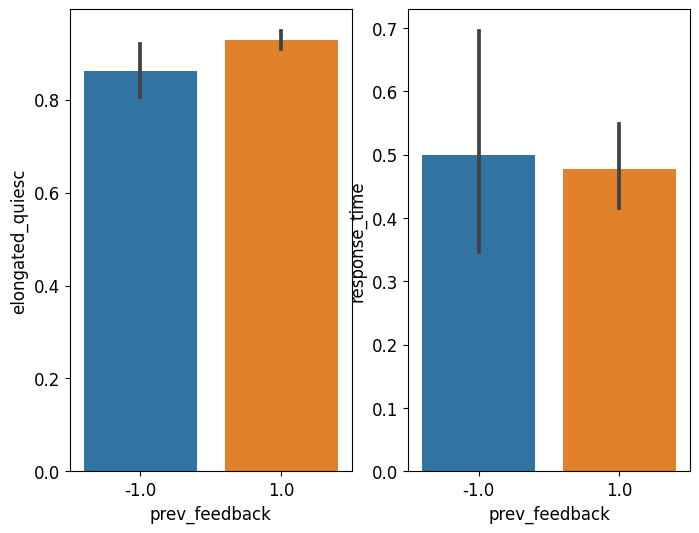

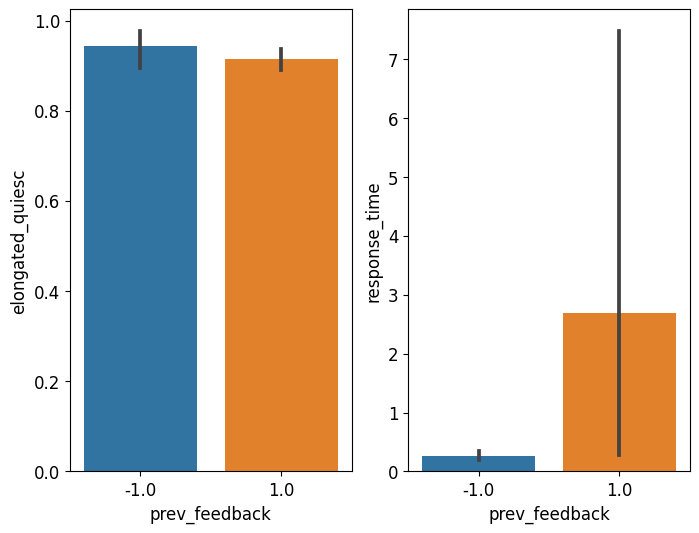

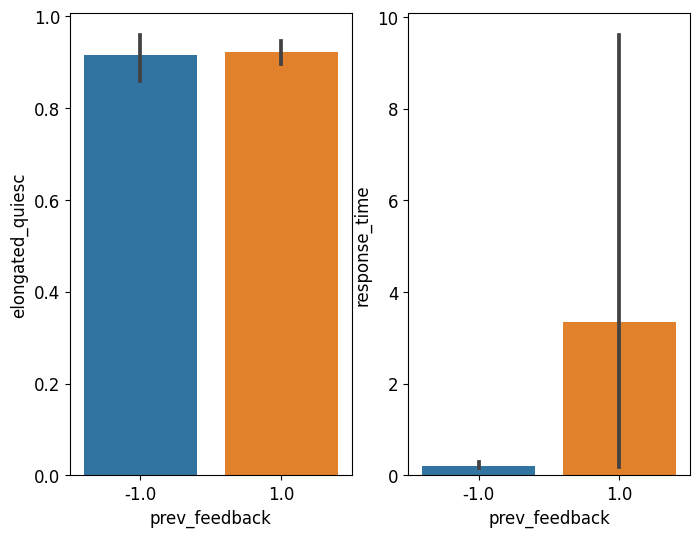

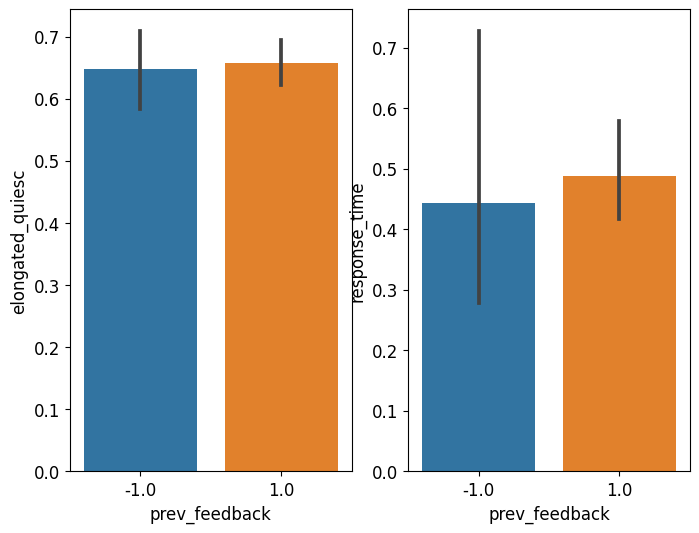

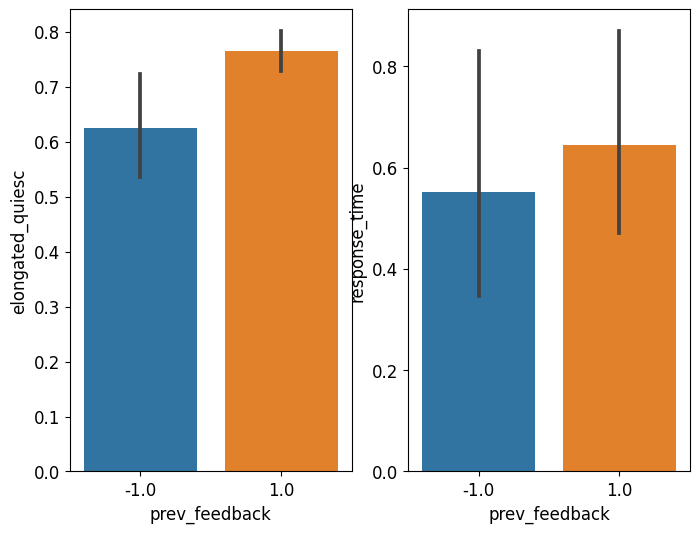

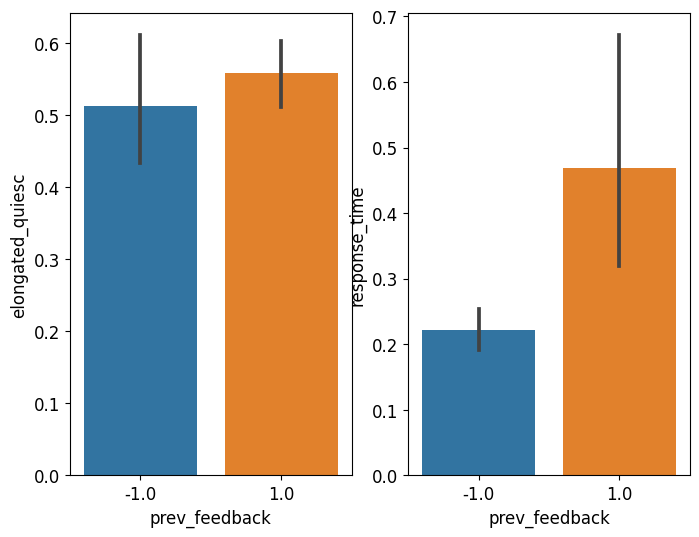

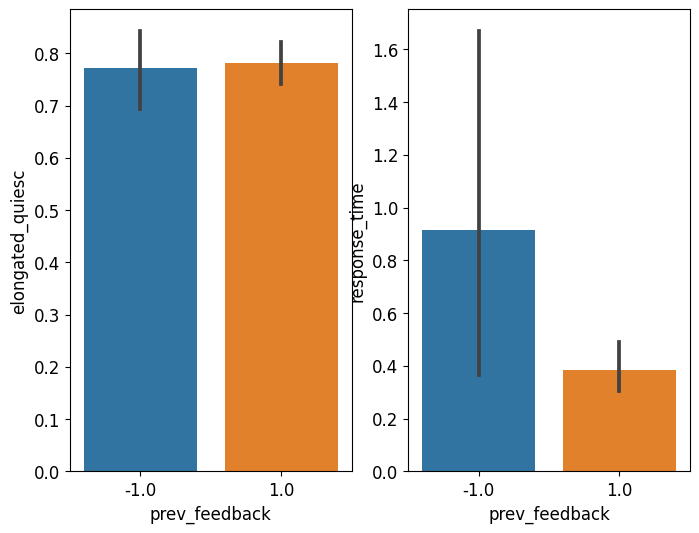

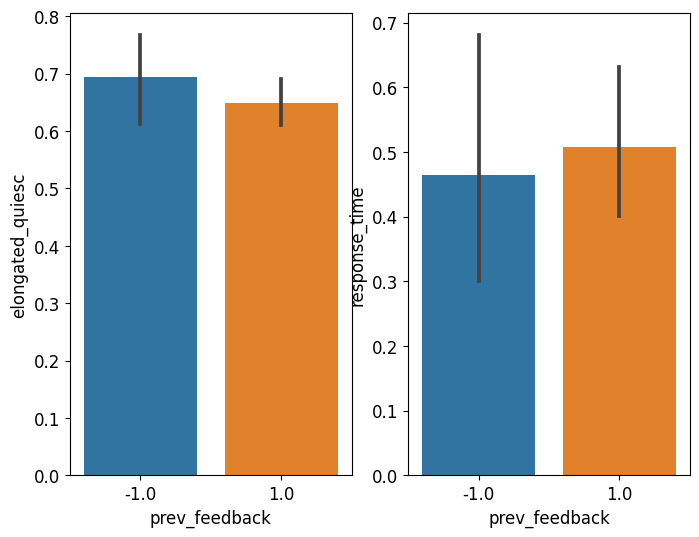

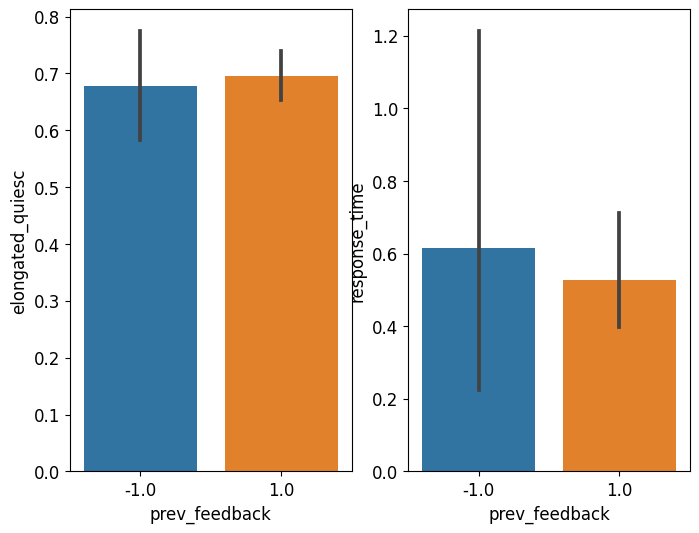

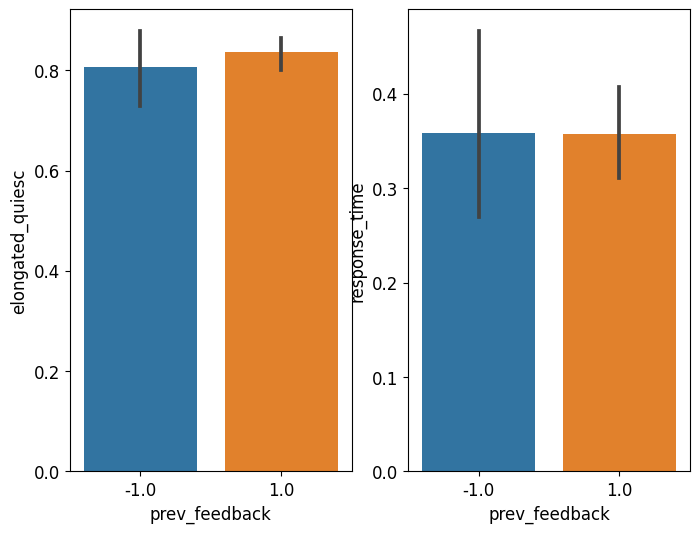

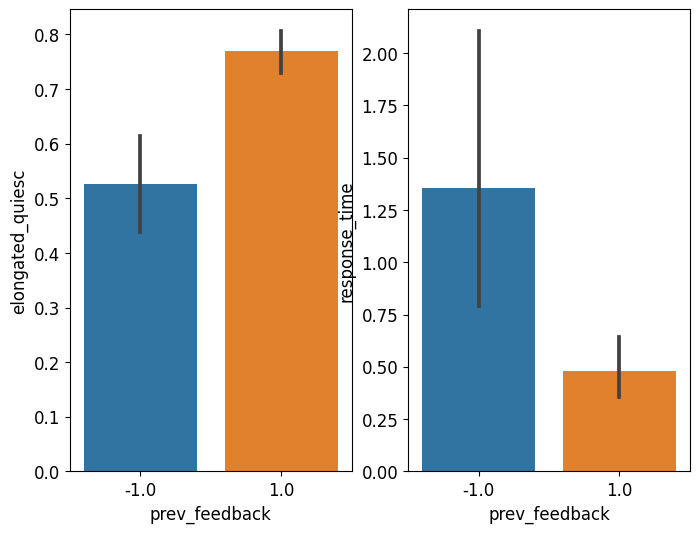

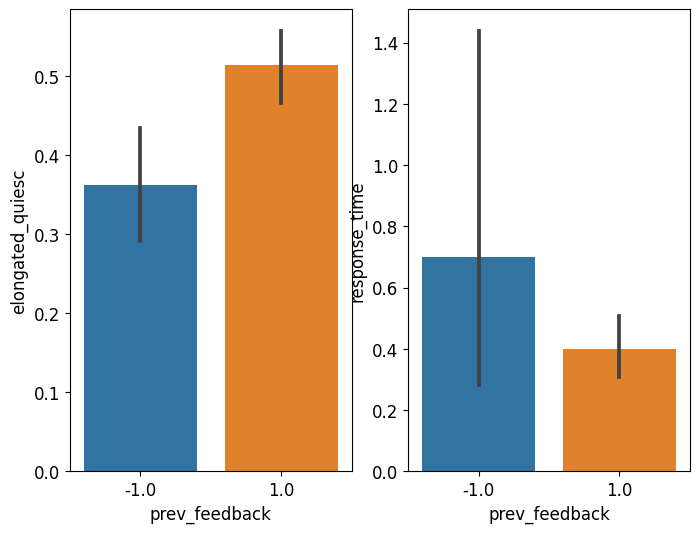

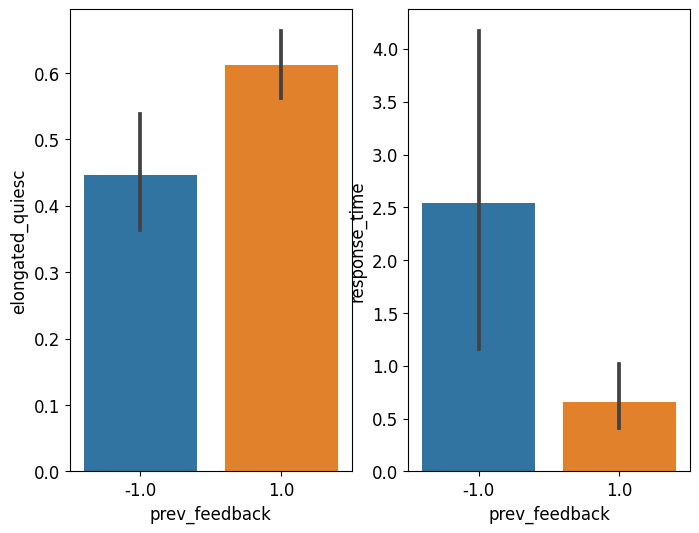

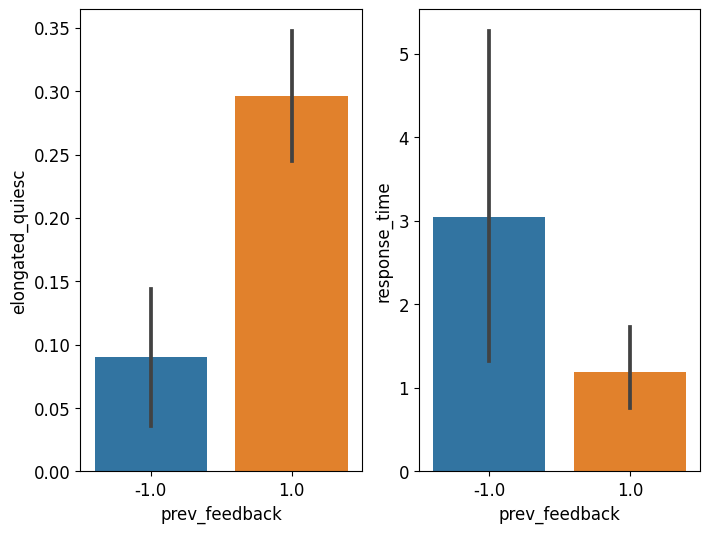

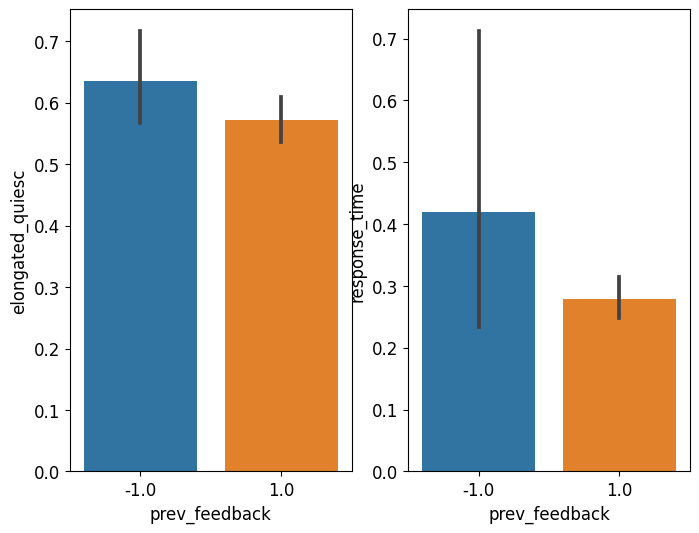

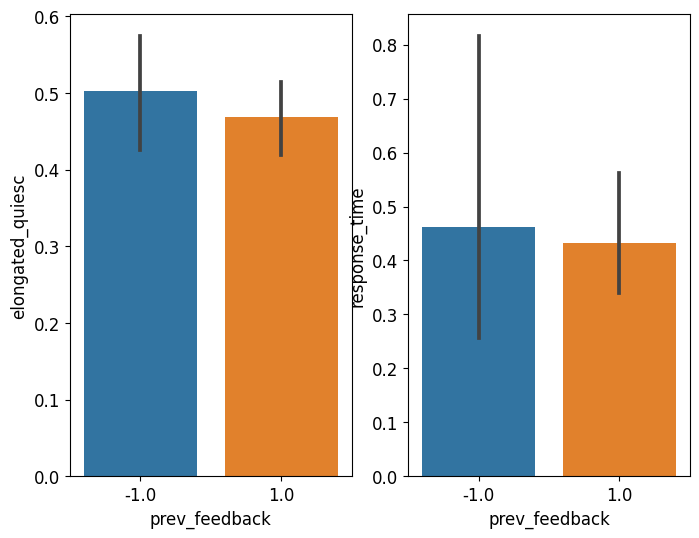

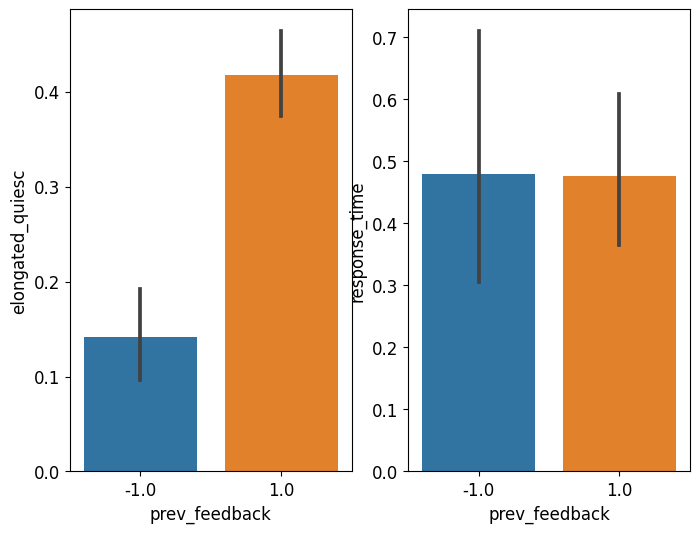

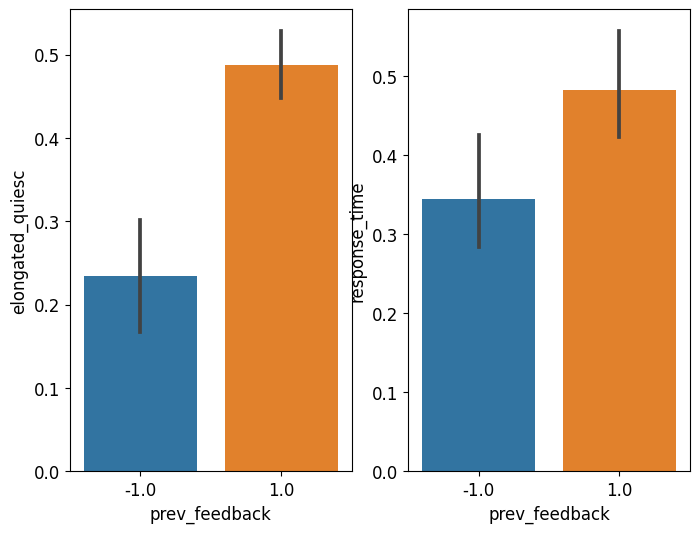

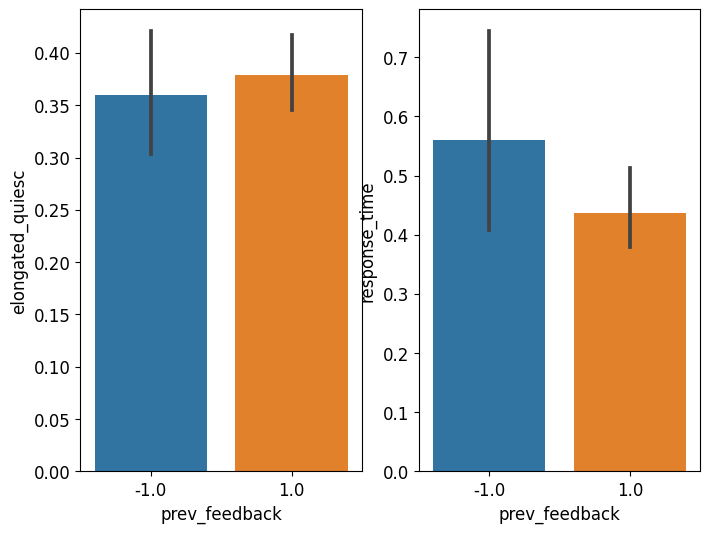

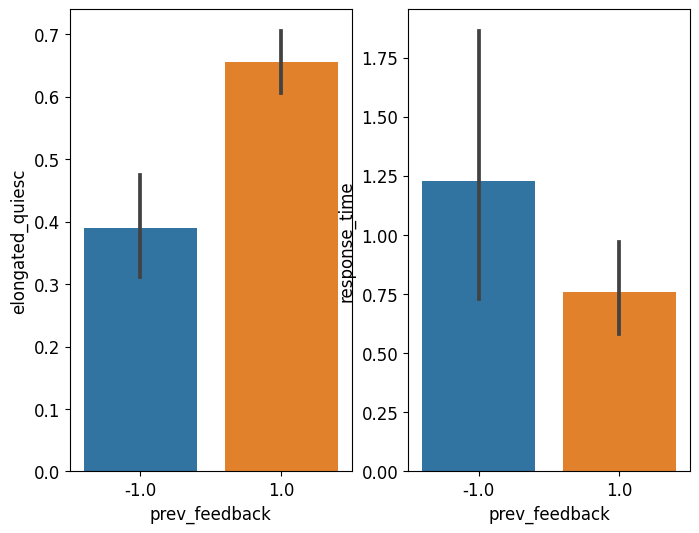

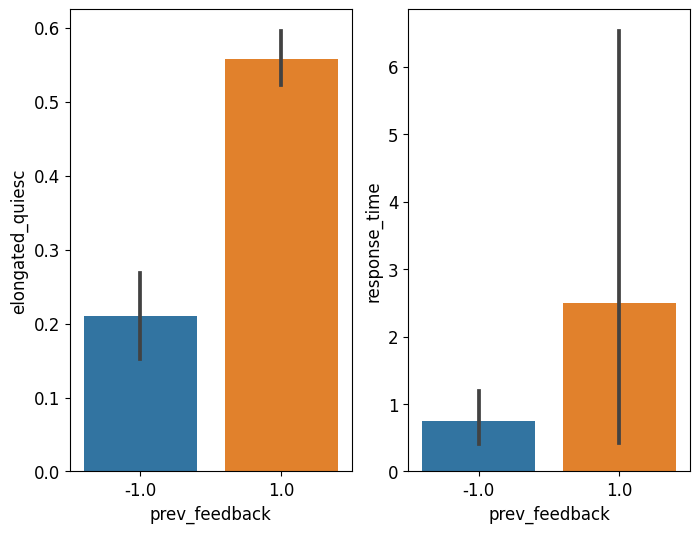

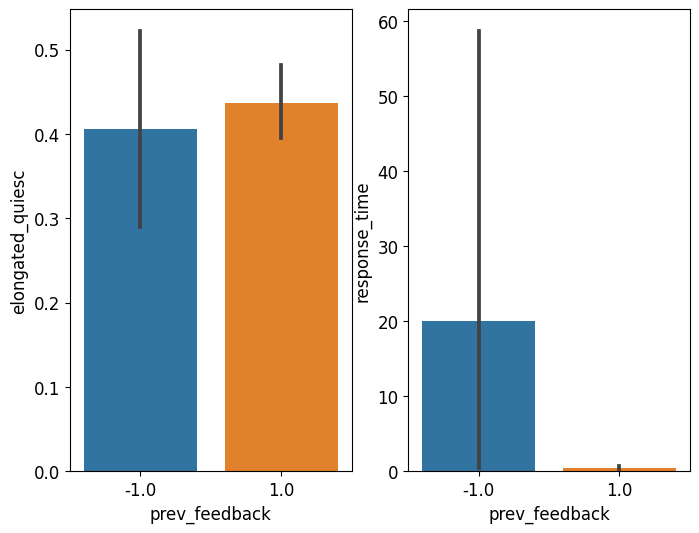

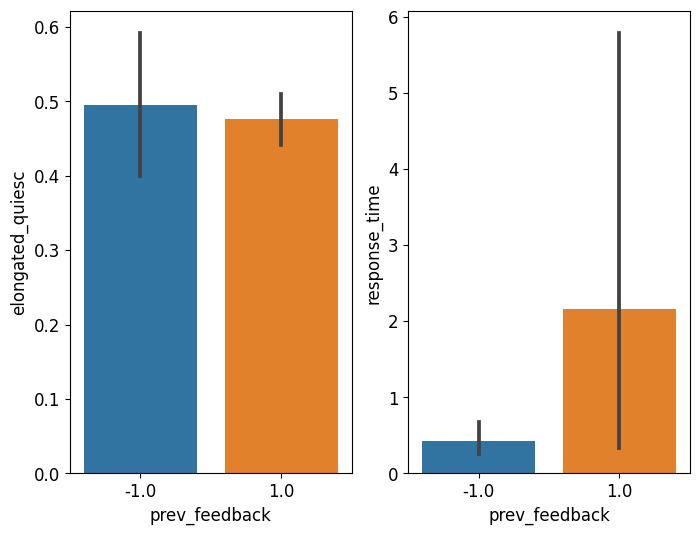

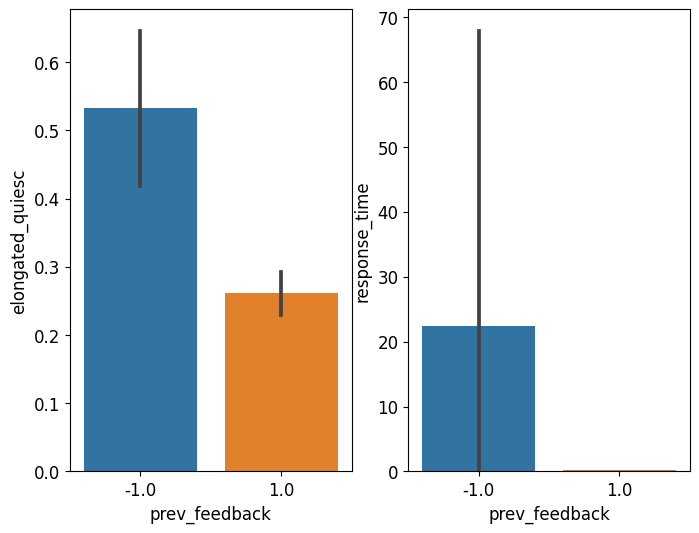

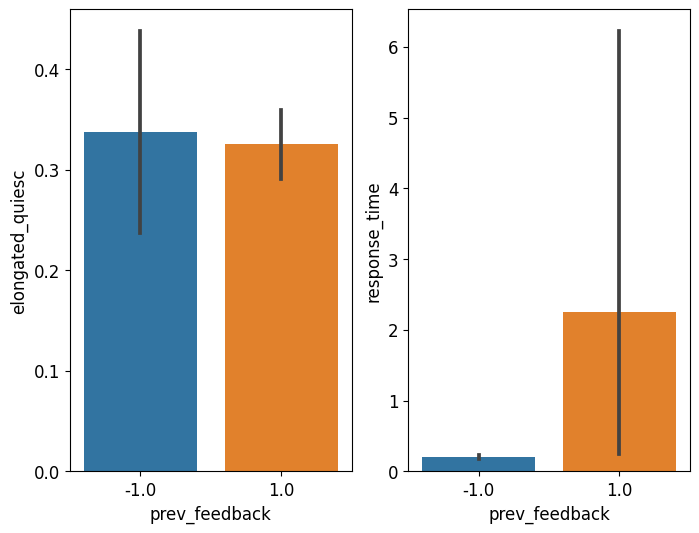

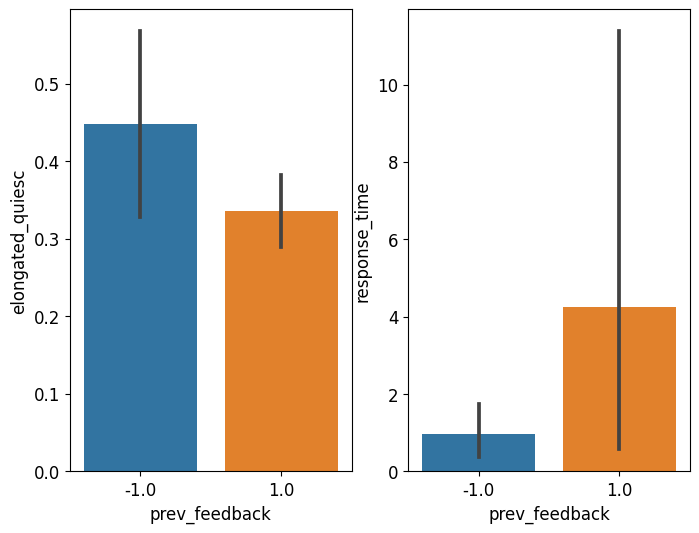

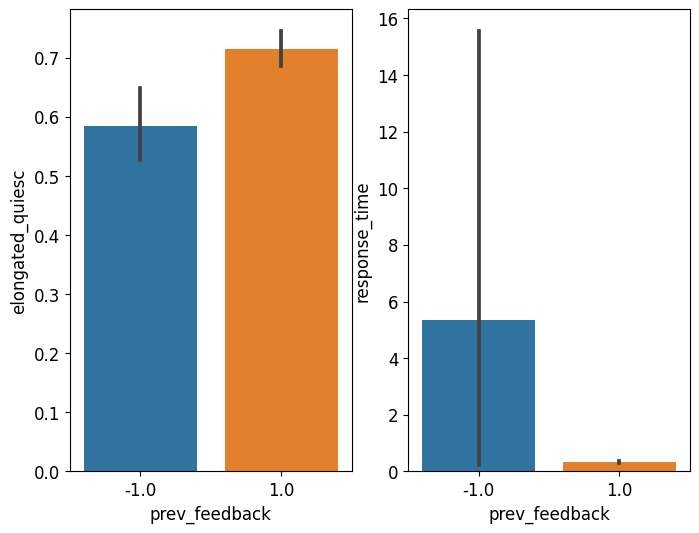

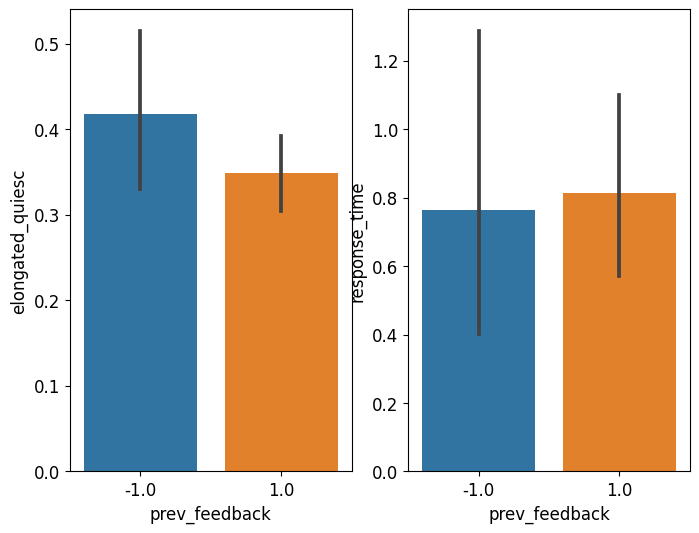

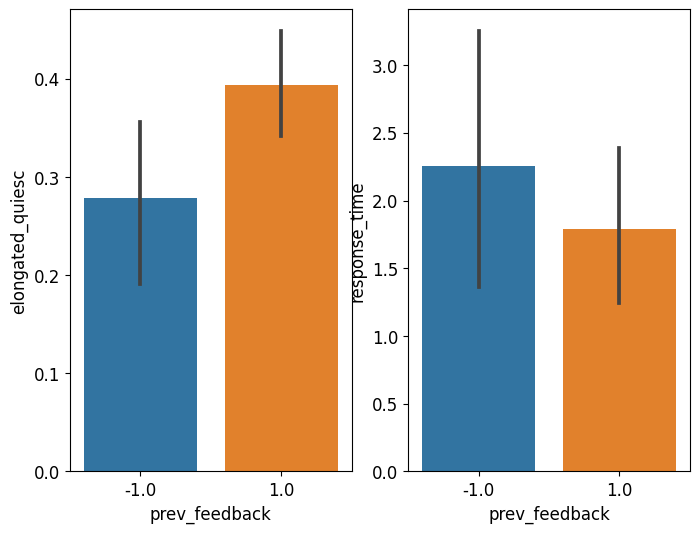

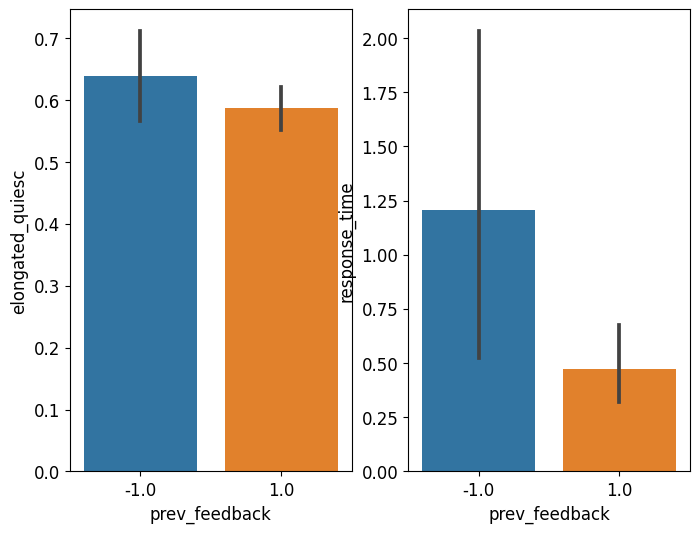

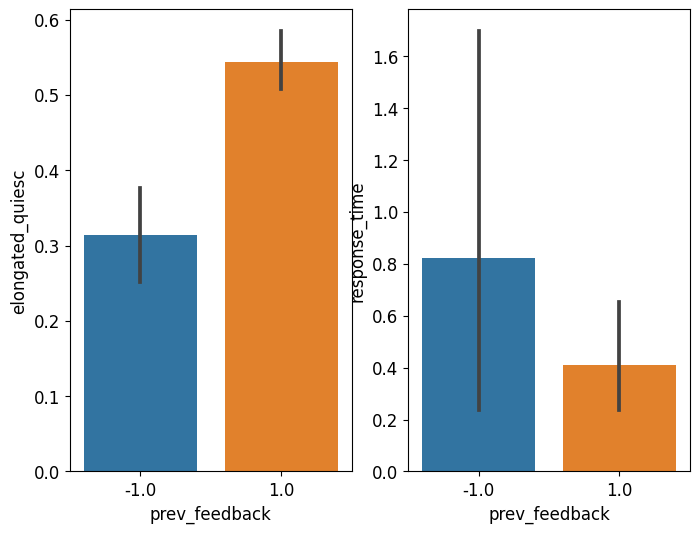

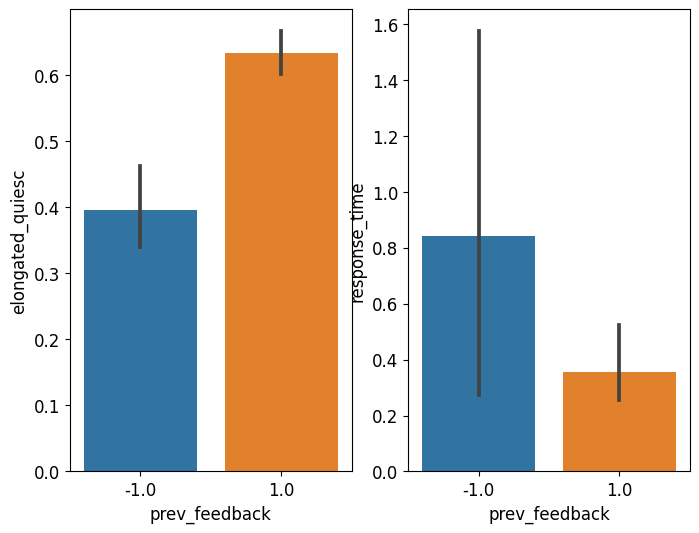

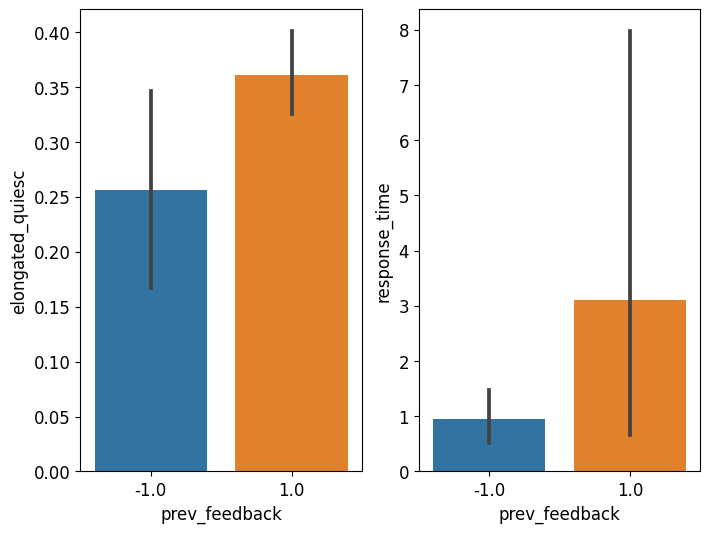

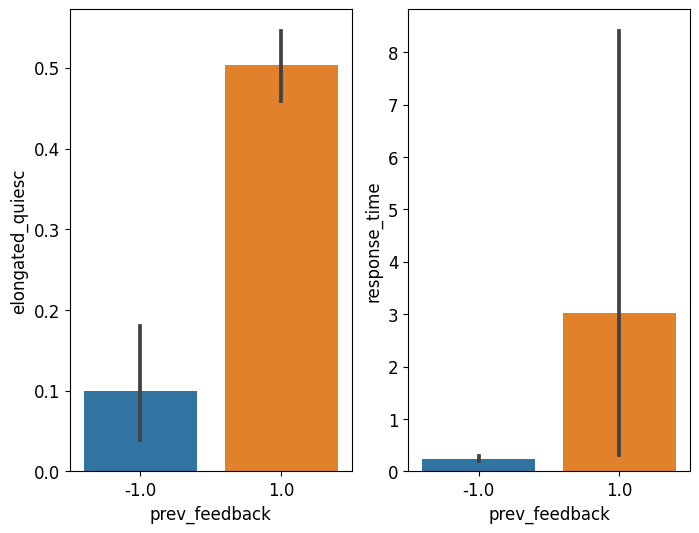

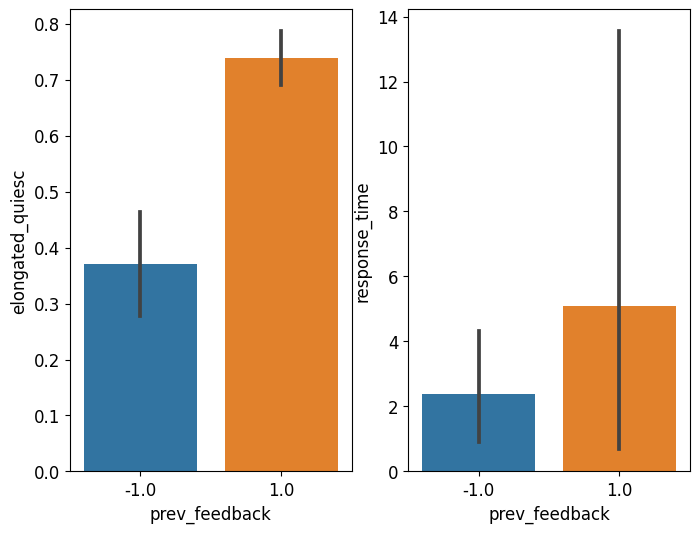

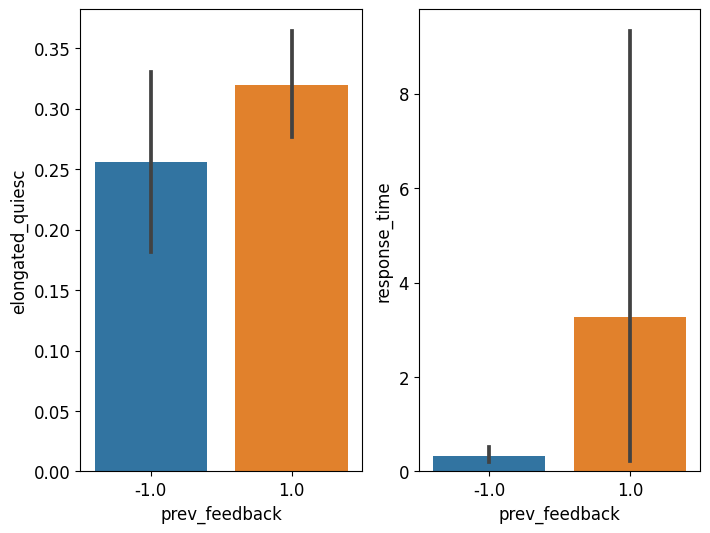

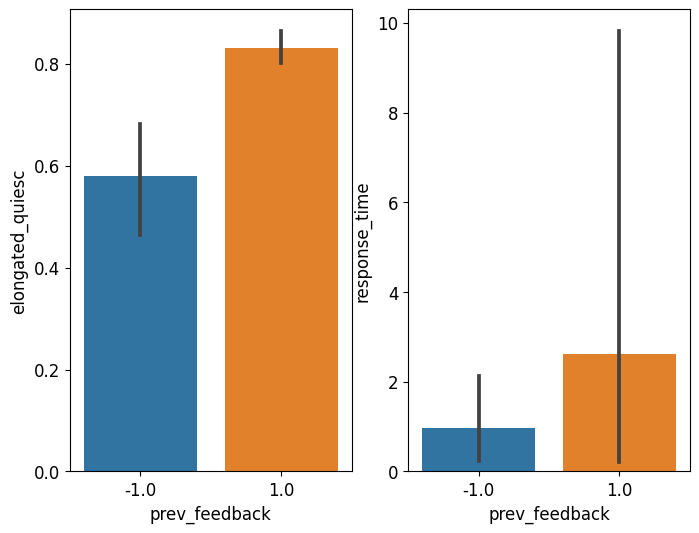

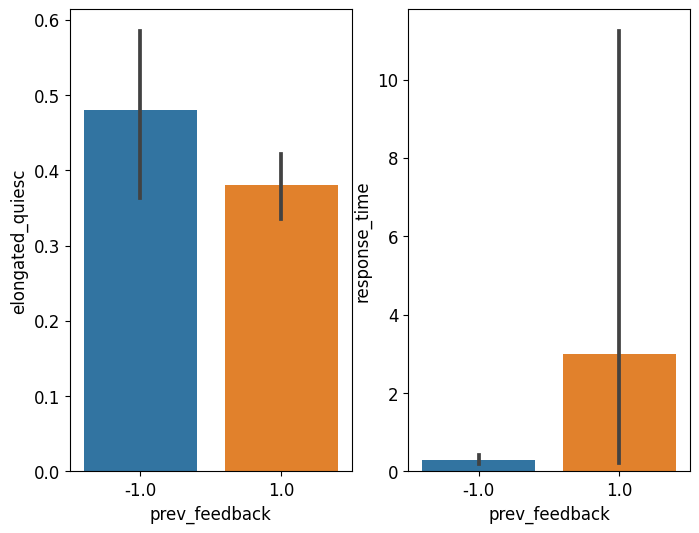

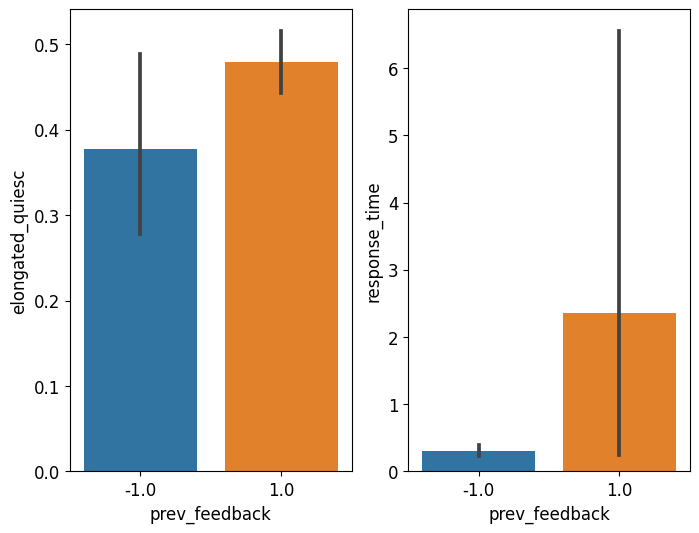

In [41]:
x = 'prev_feedback'
hue='feedbackType'
# x = 'feedbackType'
# x='elongated_quiesc'
vars_to_plot = ['failing_quiescence', 'reaction_time']
vars_to_plot = ['elongated_quiesc', 'response_time']
for s, session in enumerate(pass_qc['session_uuid']):
    
    # Get trials
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    
    use_trials = time_intervals(session_trials)

    # Plot distributions
    fig, axs = plt.subplots(nrows=1, ncols=len(vars_to_plot), sharex=True, sharey=False, figsize=[8, 6])
    plt.rc('font', size=12)
    
    for v, var in enumerate(vars_to_plot):
        # sns.histplot(x=var, hue='feedbackType', data=use_data)
        sns.barplot(x=x, y=var, data=use_trials, ax=axs[v])
    plt.show()



### Across sessions

In [76]:
cross_session = pd.DataFrame(columns=['session_uuid', 'performance_easy', 'fraction_elongated'], index=range(len(pass_qc))
                             )
for s, session in enumerate(pass_qc['session_uuid']):
    
    # Get trials
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    use_trials = time_intervals(session_trials)

    cross_session['session_uuid'][s] = session
    cross_session['performance_easy'][s] = len(use_trials.loc[use_trials['correct_easy']==1]
                                               ) / len(use_trials.loc[use_trials['contrast']>=0.5])
    cross_session['fraction_elongated'][s] = np.nanmean(use_trials['elongated_quiesc'])

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 15.7kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 14.1kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 18.3kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/Users/ineslaranjeira/Downloads/Flat

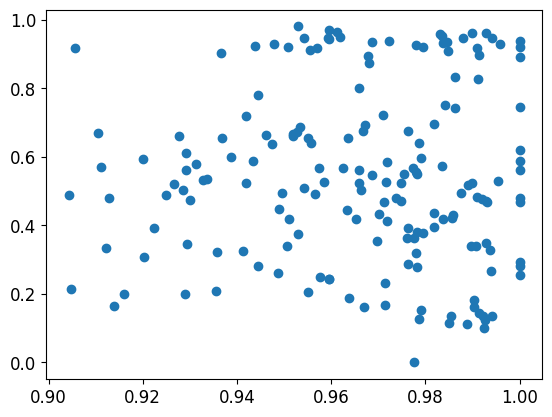

In [77]:
plt.scatter(cross_session['performance_easy'], cross_session['fraction_elongated'])

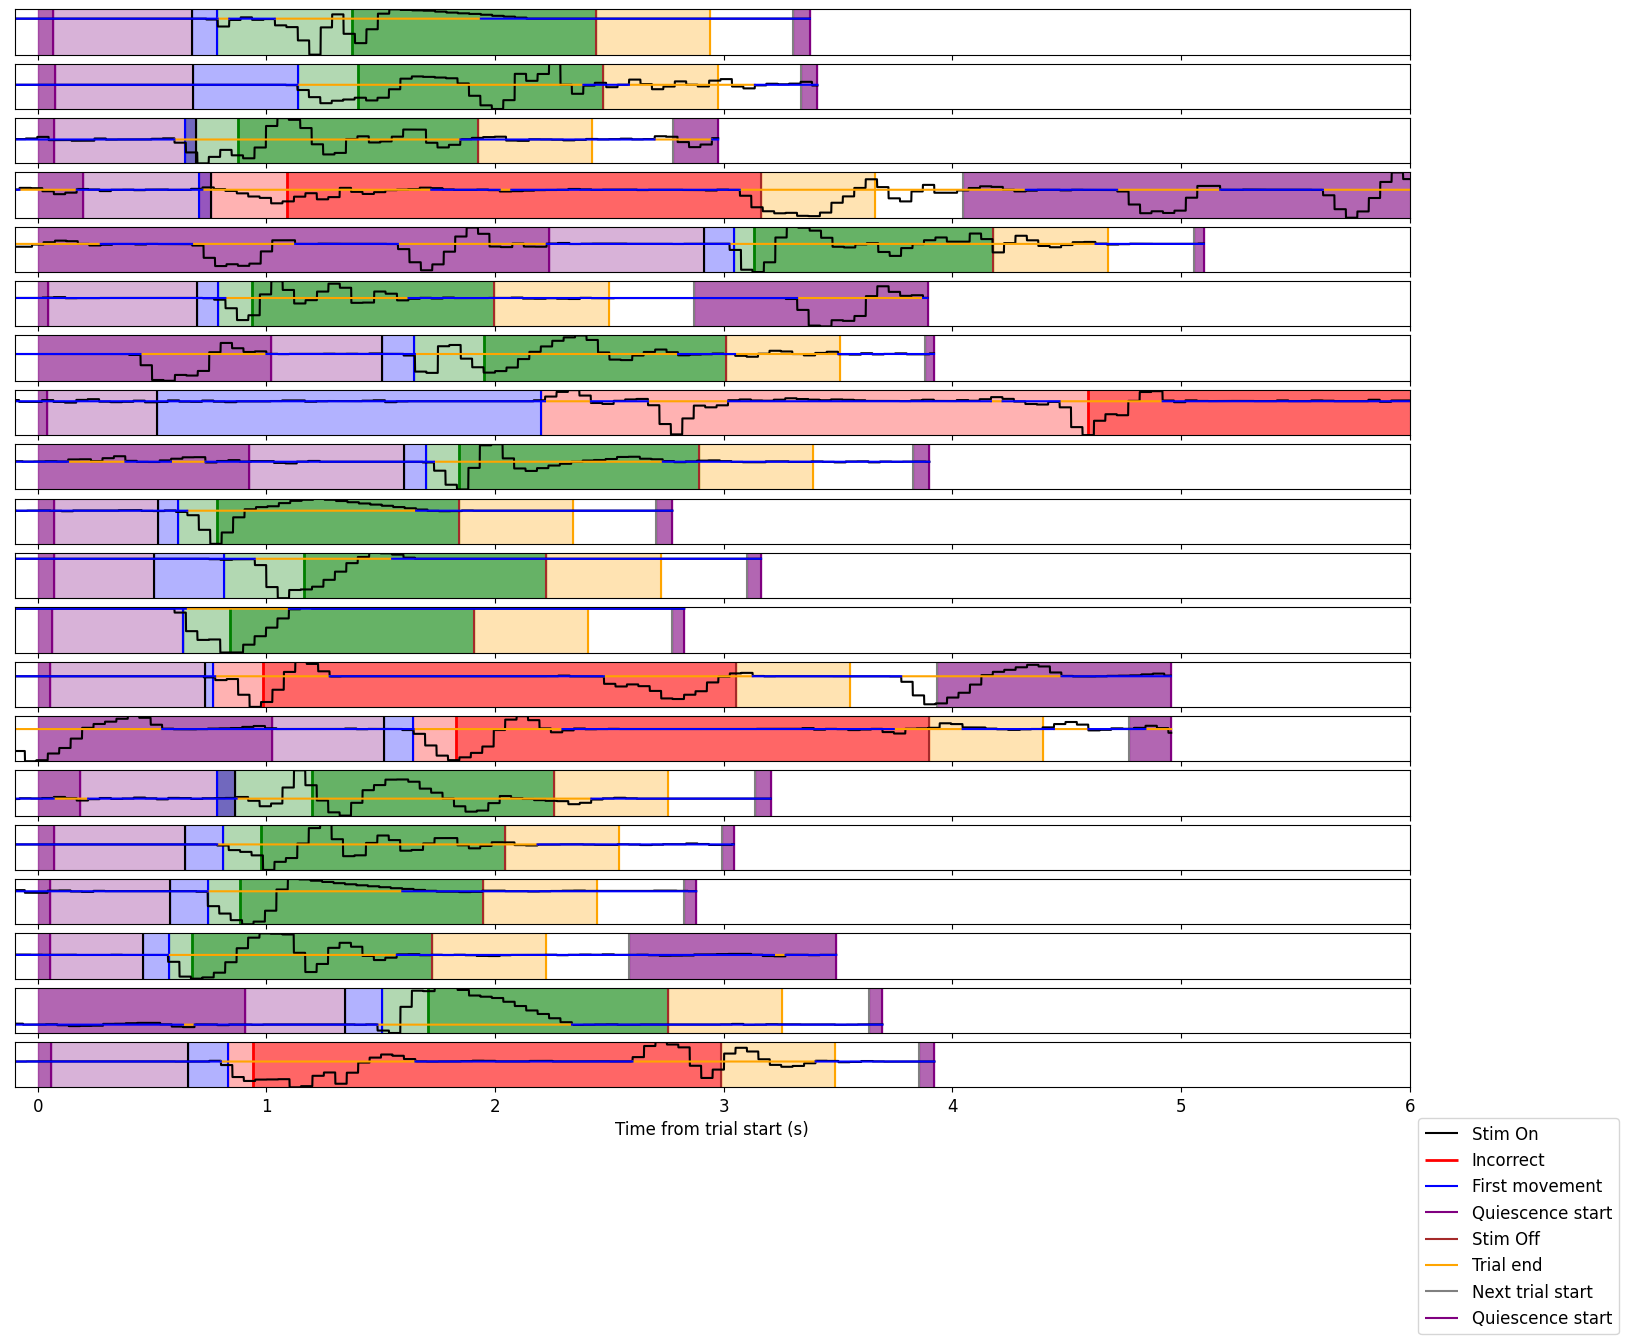

In [56]:
trials_to_plot = 20
time_max = 6
stack_trial_events(session_trials, trials_to_plot, session, time_max)

## Compute stillness

In [49]:
for s, session in enumerate(pass_qc['session_uuid'][0:1]):
    # Get trials
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    
    bin_size = 0.05
    df = wheel_trial_epoch(session_trials, session, bin_size).dropna()
    df['time_count'] = np.ones(len(df['movement']))
    
    processed_quiescence = process_quiescence(df)

/tmp/ipykernel_9412/474072190.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['movement_duration'][1:] = np.diff(new_df['movement_onset'])


In [62]:
processed_quiescence['next_feedback'] = processed_quiescence['feedback']*np.NaN
processed_quiescence['next_feedback'][:-1] = processed_quiescence['feedback'][1:]

/tmp/ipykernel_9412/4043752950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_quiescence['next_feedback'][:-1] = processed_quiescence['feedback'][1:]


In [64]:
processed_quiescence['feedback']

index trial  trial_epoch feedback prev_feedback signed_contrast  \
0       25947     0  trial_start      1.0           1.0            -1.0   
1       26012     0   quiescence      1.0           1.0            -1.0   
2       26622     0      stim_on      1.0           1.0            -1.0   
3       26731     0     movement      1.0           1.0            -1.0   
4       26734     0     movement      1.0           1.0            -1.0   
...       ...   ...          ...      ...           ...             ...   
3596  1723764   411      stim_on      1.0           1.0             1.0   
3597  1723779   411     movement      1.0           1.0             1.0   
3598  1723834   411     movement      1.0           1.0             1.0   
3599  1724052   411  post_choice      1.0           1.0             1.0   
3600  1725284   411  post_choice      1.0           1.0             1.0   

      movement  movement_onset  epoch_onset  movement_duration quiesc_length  \
0          0.0       25.963798    25.963798                NaN         0.076   
1          0.0       26.028798    26.028798              0.065         0.076   
2          0.0       26.638798    26.638798              0.610         0.076   
3          0.0       26.747798    26.747798              0.109         0.076   
4          1.0       26.750798    26.747798              0.003         0.076   
...        ...             ...          ...                ...           ...   
3596       0.0     1723.780798  1723.780798              0.458         0.061   
3597       0.0     1723.795798  1723.795798              0.015         0.061   
3598       1.0     1723.850798  1723.795798              0.055         0.061   
3599       1.0     1724.068798  1724.068798              0.218         0.061   
3600       0.0     1725.300798  1724.068798              1.232         0.061   

     time_to_quiesc pre_quiesc_move_duration pre_quiesc_move_count  \
0             1.925                    0.339                     1   
1             1.925                    0.339                     1   
2             1.925                    0.339                     1   
3             1.925                    0.339                     1   
4             1.925                    0.339                     1   
...             ...                      ...                   ...   
3596          2.196                    0.218                     1   
3597          2.196                    0.218                     1   
3598          2.196                    0.218                     1   
3599          2.196                    0.218                     1   
3600          2.196                    0.218                     1   

     next_feedback  
0              1.0  
1              1.0  
2              1.0  
3              1.0  
4              1.0  
...            ...  
3596           1.0  
3597           1.0  
3598           1.0  
3599           1.0  
3600           NaN  

[3601 rows x 15 columns]

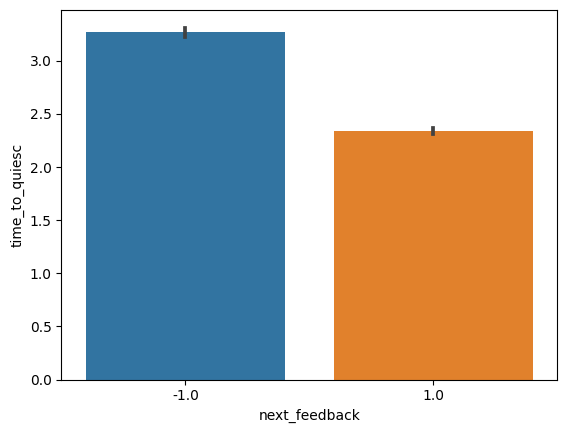

<AxesSubplot: xlabel='next_feedback', ylabel='time_to_quiesc'>

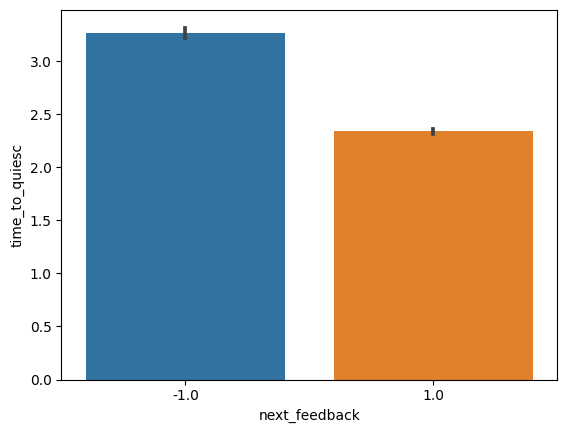

In [63]:
sns.barplot(y='time_to_quiesc', x='next_feedback', data=processed_quiescence)
# sns.catplot(y='time_to_quiesc', x='prev_feedback', data=processed_quiescence, alpha=0.5)
# plt.ylim([2, 3])
plt.show()
sns.barplot(y='time_to_quiesc', x='next_feedback', data=processed_quiescence)
# sns.catplot(y='time_to_quiesc', x='prev_feedback', data=processed_quiescence, alpha=0.5)
# plt.ylim([2, 3])

<AxesSubplot: xlabel='prev_feedback', ylabel='quiesc_length'>

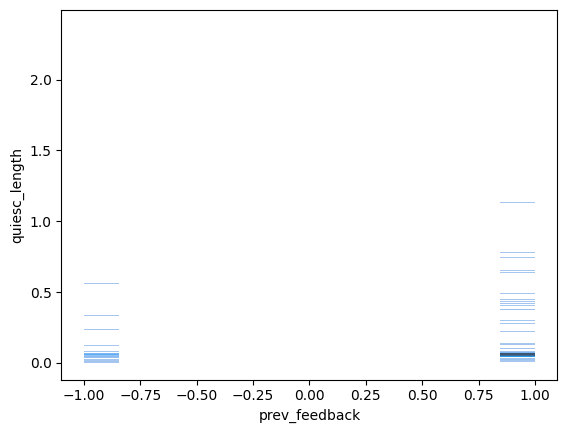

In [38]:
sns.histplot(y='quiesc_length', x='prev_feedback', data=processed_quiescence)
# plt.xlim([0,1])

## Analyze stillness and movement periods

d32876dd-8303-4720-8e7e-20678dc2fd71
72982282-e493-45ee-87ce-aa45cb3a3ec1
6434f2f5-6bce-42b8-8563-d93d493613a2
64e3fb86-928c-4079-865c-b364205b502e
15948667-747b-4702-9d53-354ac70e9119
288bfbf3-3700-4abe-b6e4-130b5c541e61
fc43390d-457e-463a-9fd4-b94a0a8b48f5
3d59aa1a-b4ba-47fe-b9cf-741b5fdb0c7b


/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


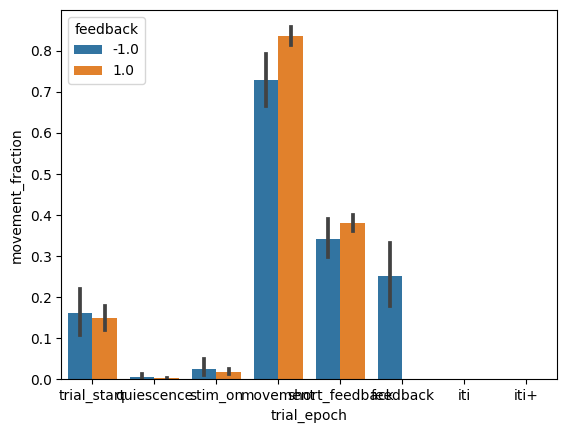

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


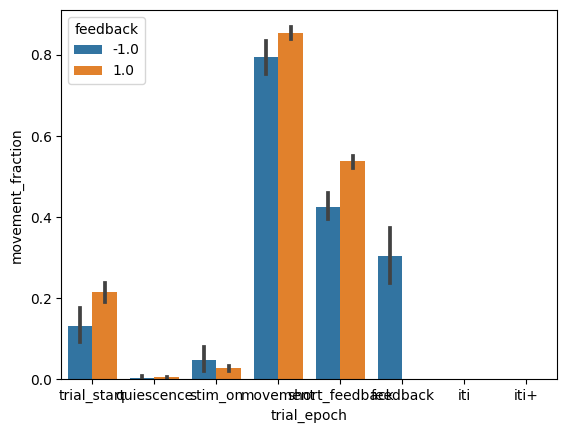

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


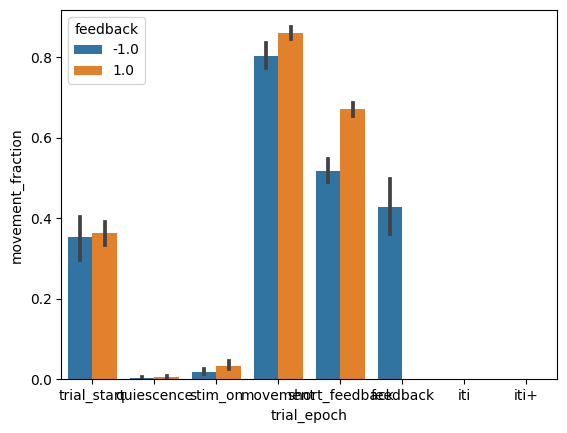

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


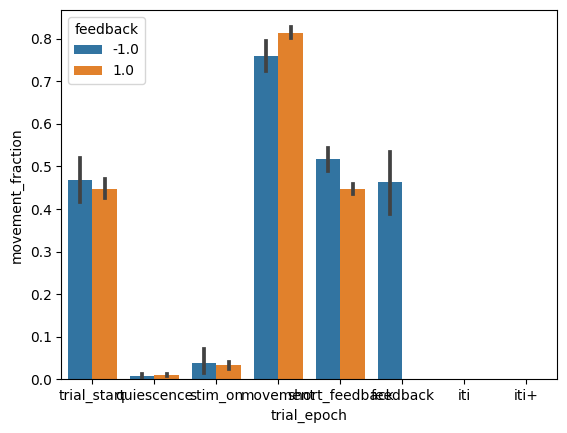

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


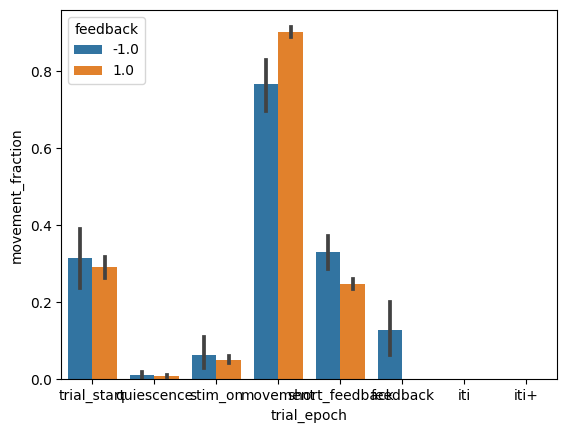

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


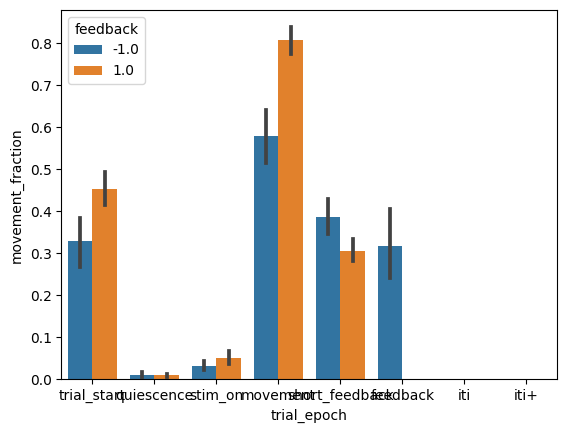

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


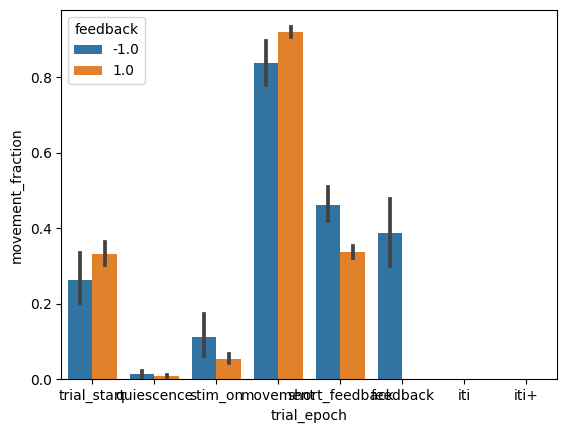

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.9kB/s]
/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


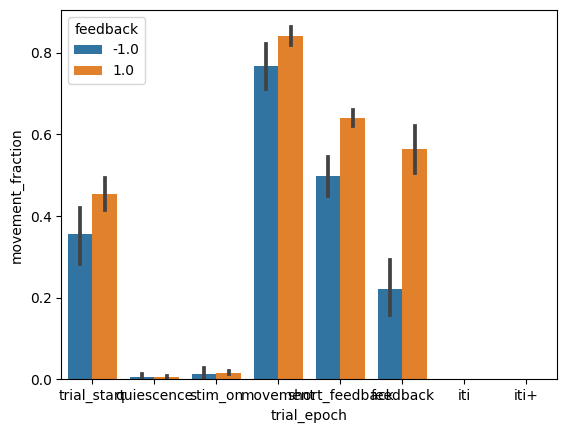

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


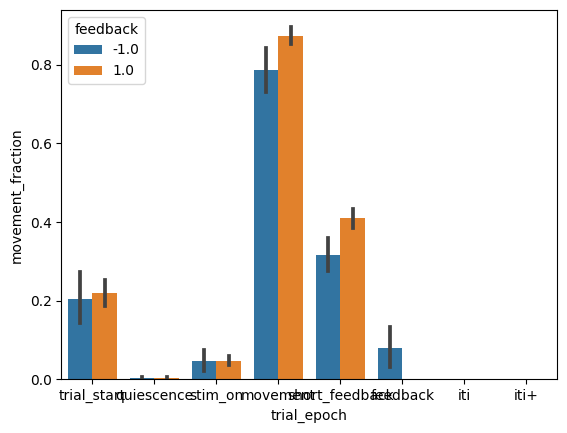

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


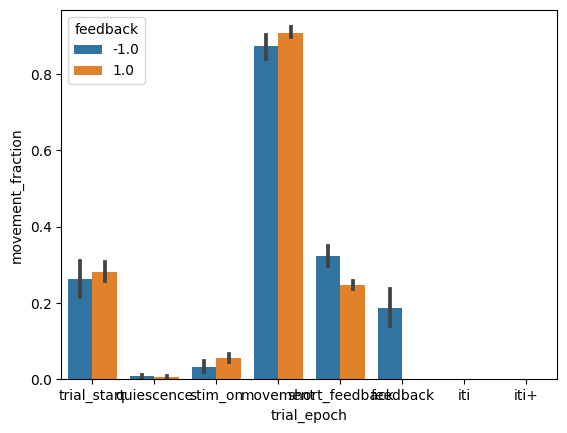

/tmp/ipykernel_19235/1074084796.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())


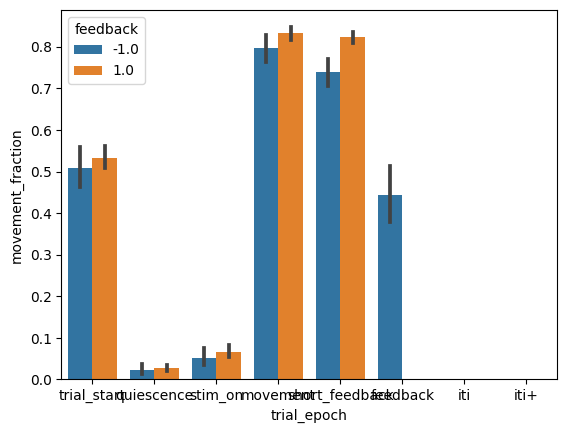

f312aaec-3b6f-44b3-86b4-3a0c119c0438


In [115]:
for s, session in enumerate(pass_qc['session_uuid'][10:]):
    try:
        # Get trials
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        
        bin_size = 0.05
        df = wheel_trial_epoch(session_trials, session, bin_size).dropna()
        df['time_count'] = np.ones(len(df['movement']))
        
        mean_label = pd.DataFrame(df.groupby(['trial', 'trial_epoch', 'feedback', 'prev_feedback'])['movement', 'time_count'].sum())
        mean_label = mean_label.reset_index(level=[0, 1, 2, 3])
        mean_label['movement_fraction'] = mean_label['movement'] / mean_label['time_count']
        
        # Stilness per trial epoch
        var_order = ['trial_start', 'quiescence', 'stim_on', 'movement', 'short_feedback', 'feedback', 'iti', 'iti+']
        sns.barplot(x='trial_epoch', hue='feedback', y = 'movement_fraction', data=mean_label, order=var_order)
        # plt.ylim([0, 1])
        plt.show()
    except:
        print(session)
